## Import libraries

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH="/content/drive/MyDrive/machine_learning_models_more_data"

Mounted at /content/drive


## Get data

I'm going to use the historical price data of Bitcoin to try and predict the future price of Bitcoin!

The data was procured from the CoinDesk website located at: https://coindesk.com/price/bitcoin.

In [ ]:
# !wget https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

## Importing time series with pandas since it's a library that can read csv data directly and create a DataFrame

In [ ]:
# Read our Bitcoin data and parse the data

timesteps = []
btc_prices = []
with open("/content/btc_more_data.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_prices.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_prices[:10]

([datetime.datetime(2013, 4, 28, 0, 0),
  datetime.datetime(2013, 4, 29, 0, 0),
  datetime.datetime(2013, 4, 30, 0, 0),
  datetime.datetime(2013, 5, 1, 0, 0),
  datetime.datetime(2013, 5, 2, 0, 0),
  datetime.datetime(2013, 5, 3, 0, 0),
  datetime.datetime(2013, 5, 4, 0, 0),
  datetime.datetime(2013, 5, 5, 0, 0),
  datetime.datetime(2013, 5, 6, 0, 0),
  datetime.datetime(2013, 5, 7, 0, 0)],
 [135.97999572753906,
  147.48800659179688,
  146.92999267578125,
  139.88999938964844,
  125.5999984741211,
  108.12799835205078,
  115.0,
  118.80000305175781,
  124.66300201416016,
  113.44400024414062])

In [ ]:
# Visualize our data as a dataframe
df = pd.read_csv("/content/btc_more_data.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.300003,135.979996,132.100006,134.210007,0.0,1.488567e+09
2013-04-29,134.444000,147.488007,134.000000,144.539993,0.0,1.603769e+09
2013-04-30,144.000000,146.929993,134.050003,139.000000,0.0,1.542813e+09
2013-05-01,139.000000,139.889999,107.720001,116.989998,0.0,1.298955e+09
2013-05-02,116.379997,125.599998,92.281898,105.209999,0.0,1.168517e+09


In [ ]:
# Get info about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3632 entries, 2013-04-28 to 2023-04-07
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3632 non-null   float64
 1   High        3632 non-null   float64
 2   Low         3632 non-null   float64
 3   Close       3632 non-null   float64
 4   Volume      3632 non-null   float64
 5   Market Cap  3632 non-null   float64
dtypes: float64(6)
memory usage: 198.6 KB


In [ ]:
# Now let's see how many data samples that we have
len(df)

3632

I've collected the historical price of Bitcoin for the past 8 years (aproximately) but there are only 2787 samples.

A smaller number of samples is something that is normal when dealing with time series data problems. The term to better describe this is seasonality.

**Note:** Seasonality means that a time series dataset is reffered as the number of samples per year. So for this Bitcoin data, it has a seasonlity of daily or value of 365 because I'm collecting one sample per day meaning I'm getting 365 samples per year.

More about this can be found here: https://otexts.com/fpp3/tspatterns.html

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-04-28,134.210007
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999


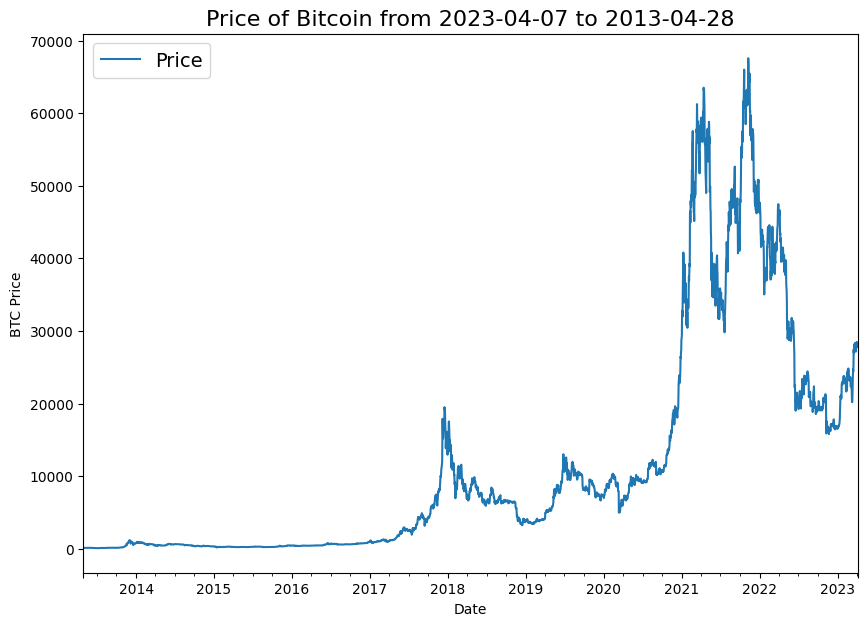

In [ ]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 2023-04-07 to 2013-04-28", fontsize=16)
plt.legend(fontsize=14)

## Format data: Create train and test sets of the time series data above

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-04-28T00:00:00.000000000', '2013-04-29T00:00:00.000000000',
        '2013-04-30T00:00:00.000000000', '2013-05-01T00:00:00.000000000',
        '2013-05-02T00:00:00.000000000', '2013-05-03T00:00:00.000000000',
        '2013-05-04T00:00:00.000000000', '2013-05-05T00:00:00.000000000',
        '2013-05-06T00:00:00.000000000', '2013-05-07T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([134.21000671, 144.53999329, 139.        , 116.98999786,
        105.20999908,  97.75      , 112.5       , 115.91000366,
        112.30000305, 111.5       ]))

In [ ]:
# Create train and test splits
split_size = int(0.9 * len(prices)) # 80% train and 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(3268, 364, 3268, 364)

In [ ]:
# Create function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of plot in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps: array of timesteps values
  values: array of values across time
  format: style of plot, defaul "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to start but for the end)
  label: label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

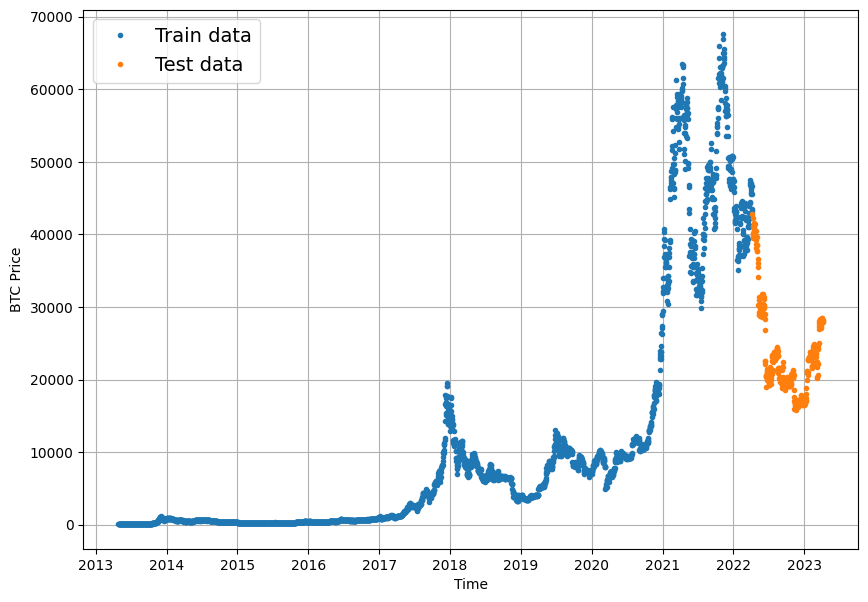

In [ ]:
# Plot made splits
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

I will run several modelling experiments to see which one performs the best.

Terms to be familiar with:

* Horizon = number of timesteps into the future we're going to predict
* Window size = number of timesteps we're going to use to predict horizon

Modelling experiments I'll be running:

* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast model (the baseline)
More info here: https://otexts.com/fpp3/simple-methods.html

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

The prediction at timestep t (the y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1

In [ ]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[:-10]

(array([42782.13531729, 42207.67096373, 39521.90132657, 40127.18208493,
        41166.73181225, 39935.51699921, 40553.46327189, 40424.48329332,
        39716.95422584, 40826.2143856 ]),
 array([42782.13531729, 42207.67096373, 39521.90132657, 40127.18208493,
        41166.73181225, 39935.51699921, 40553.46327189, 40424.48329332,
        39716.95422584, 40826.2143856 , 41502.75041942, 41374.3782012 ,
        40527.36408354, 39740.31985388, 39486.72871132, 39469.29355583,
        40458.30896455, 38117.46250783, 39241.12275076, 39773.82836757,
        38609.82319334, 37714.8755453 , 38469.09390254, 38529.3278009 ,
        37750.4539153 , 39698.37061967, 36575.1421327 , 36040.92235015,
        35501.9541442 , 34059.26425059, 30296.95340005, 31022.90541223,
        28936.35503111, 29047.75100385, 29283.10381154, 30101.26644598,
        31305.11256868, 29862.91824129, 30425.8572768 , 28720.27139975,
        30314.3349535 , 29200.74008778, 29432.22596348, 30323.72189527,
        29098.90974573

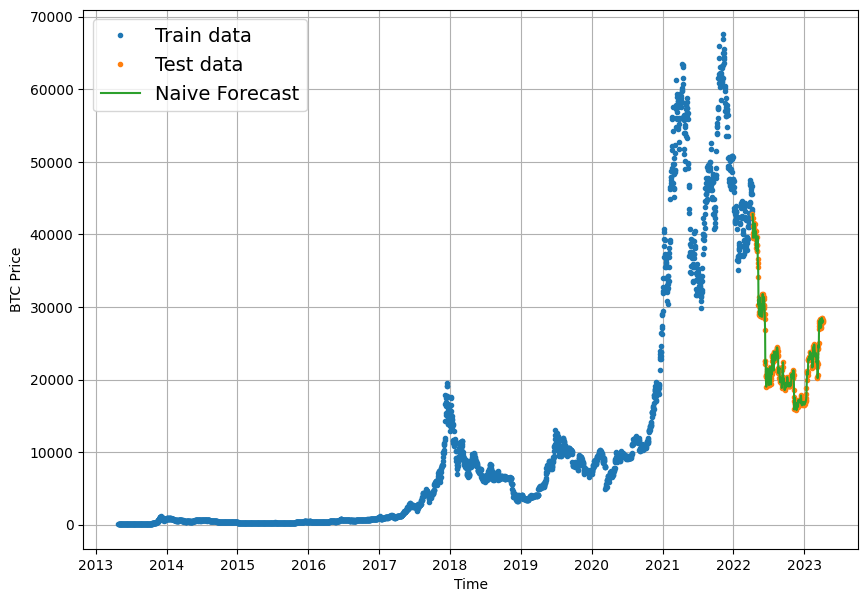

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

## Evaluating a time series model

I'm predicting a number, so that means I have a form of regression problem.

Because it is a regression problem, I'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, lower is better, for example, an MAE of 0 that is better than an MAE of 100.

The main thing that I'm evaluating here is: how the model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mea_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1])) # our seasonality is 1 day (hence the shift is 1)
  
  return mae / mea_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

1.0003256357448982

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatyep (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float64)
  y_pred = tf.cast(y_pred, dtype=tf.float64)

  # Calculate various evaluation metrcs#
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for diffrent size metrics (for longer horizons, we want to reduce metrics to a singular value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 513.9048932946307,
 'mse': 626920.7254833803,
 'rmse': 791.7832566323818,
 'mape': 2.151778424376041,
 'mase': 1.0003256357448982}

## Window the dataset

I need to window the serues dataset to turn the data into a supervised learning problem.

```
Ex:
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
bitcoin_prices["Price"][:7]

Date
2013-04-28    134.210007
2013-04-29    144.539993
2013-04-30    139.000000
2013-05-01    116.989998
2013-05-02    105.209999
2013-05-03     97.750000
2013-05-04    112.500000
Name: Price, dtype: float64

In [ ]:
# What I want to do with the Bitcoin data
print(f"I want to use this: {btc_prices[:7]} to predict this: {btc_prices[7]}")

I want to use this: [135.97999572753906, 147.48800659179688, 146.92999267578125, 139.88999938964844, 125.5999984741211, 108.12799835205078, 115.0] to predict this: 118.80000305175781


In [ ]:
# Global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the windows labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) + 1, axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [ ]:
# Create function to view numpy arrays as windows by following this article:
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """

  # Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)), axis=0).T # create 2D array of windows of size window_size

  # Index on the target array (a time series) with 2D array of multiple window steps
  window_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = get_labelled_windows(window_array, horizon=horizon)
  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(3625, 3625)

In [ ]:
# View the first 3 windwos/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [134.21000671 144.53999329 139.         116.98999786 105.20999908
  97.75       112.5       ] -> Label: [115.91000366]
Window: [144.53999329 139.         116.98999786 105.20999908  97.75
 112.5        115.91000366] -> Label: [112.30000305]
Window: [139.         116.98999786 105.20999908  97.75       112.5
 115.91000366 112.30000305] -> Label: [111.5]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [28348.44234281 28033.5631504  28478.48460568 28462.94389343
 28199.30838377 27790.22085477 28168.0898164 ] -> Label: [28177.98355695]
Window: [28033.5631504  28478.48460568 28462.94389343 28199.30838377
 27790.22085477 28168.0898164  28177.98355695] -> Label: [28044.13975494]
Window: [28478.48460568 28462.94389343 28199.30838377 27790.22085477
 28168.0898164  28177.98355695 28044.13975494] -> Label: [27925.85940841]


## Turning windows into training and test sets

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.1):
  """
  Split matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3262, 363, 3262, 363)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[134.21000671, 144.53999329, 139.        , 116.98999786,
         105.20999908,  97.75      , 112.5       ],
        [144.53999329, 139.        , 116.98999786, 105.20999908,
          97.75      , 112.5       , 115.91000366],
        [139.        , 116.98999786, 105.20999908,  97.75      ,
         112.5       , 115.91000366, 112.30000305],
        [116.98999786, 105.20999908,  97.75      , 112.5       ,
         115.91000366, 112.30000305, 111.5       ],
        [105.20999908,  97.75      , 112.5       , 115.91000366,
         112.30000305, 111.5       , 113.56600189]]),
 array([[115.91000366],
        [112.30000305],
        [111.5       ],
        [113.56600189],
        [112.66999817]]))

In [ ]:
test_windows[:5], test_labels[:5]

(array([[46453.56707632, 46622.67441375, 45555.9934042 , 43206.73767257,
         43503.84916614, 42287.66351168, 42782.13531729],
        [46622.67441375, 45555.9934042 , 43206.73767257, 43503.84916614,
         42287.66351168, 42782.13531729, 42207.67096373],
        [45555.9934042 , 43206.73767257, 43503.84916614, 42287.66351168,
         42782.13531729, 42207.67096373, 39521.90132657],
        [43206.73767257, 43503.84916614, 42287.66351168, 42782.13531729,
         42207.67096373, 39521.90132657, 40127.18208493],
        [43503.84916614, 42287.66351168, 42782.13531729, 42207.67096373,
         39521.90132657, 40127.18208493, 41166.73181225]]),
 array([[42207.67096373],
        [39521.90132657],
        [40127.18208493],
        [41166.73181225],
        [39935.51699921]]))

In [ ]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

In [ ]:
train_labels[:5].shape

(5, 1)

## Make a modelling checkpoint callback

Because the model's performance will flactuate from experiment to experiment I need to write a model checkpoint so that I can compare a model's performance to anothers.

For example, if the model performs the best on epoch 55 out of 100, I would like to save the model's performance and weights on that checkpoint.

In [ ]:
# Create a function to implement a ModelCheckoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="/content/drive/MyDrive/machine_learning_models_more_data"):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(save_path, model_name),
      verbosity=0, # only output a limited amount of text
      save_best_only=True
  )

## Model 1: Dense model (window = 7, horizon = 1)

The first deep model is going to be a simple dense model and is going to have the following parameters:

* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128
* 100 epochs

Those parameters are picked to experiment and test this model to see it's performance.

In [ ]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense")

# Compile the model
model_1.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_1.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_1.name)]
)

Epoch 1/100
 1/26 [>.............................] - ETA: 16s - loss: 13475.4795 - mae: 13475.4795 - mse: 613952128.0000

26/26 [==============================] - 3s 76ms/step - loss: 4188.8672 - mae: 4188.8672 - mse: 104003944.0000 - val_loss: 2309.6521 - val_mae: 2309.6521 - val_mse: 8316530.0000
Epoch 2/100
 1/26 [>.............................] - ETA: 0s - loss: 712.6579 - mae: 712.6579 - mse: 3239287.0000

26/26 [==============================] - 1s 29ms/step - loss: 718.1708 - mae: 718.1708 - mse: 2735373.0000 - val_loss: 1247.0898 - val_mae: 1247.0898 - val_mse: 2798100.7500
Epoch 3/100
 1/26 [>.............................] - ETA: 0s - loss: 823.2377 - mae: 823.2377 - mse: 2974098.5000

26/26 [==============================] - 1s 23ms/step - loss: 610.7980 - mae: 610.7980 - mse: 1989021.8750 - val_loss: 1060.0234 - val_mae: 1060.0234 - val_mse: 2653160.7500
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 545.4041 - mae: 545.4041 - mse: 1613787.1250 - val_loss: 1431.6962 - val_mae: 1431.6963 - val_mse: 3747884.5000
Epoch 5/100
 1/26 [>.............................] - ETA: 0s - loss: 410.3672 - mae: 410.3672 - mse: 1295373.0000

26/26 [==============================] - 1s 21ms/step - loss: 529.2228 - mae: 529.2228 - mse: 1542818.6250 - val_loss: 900.2000 - val_mae: 900.2000 - val_mse: 1948942.7500
Epoch 6/100
 1/26 [>.............................] - ETA: 0s - loss: 645.7908 - mae: 645.7908 - mse: 2000399.8750

26/26 [==============================] - 1s 21ms/step - loss: 491.4303 - mae: 491.4303 - mse: 1318087.6250 - val_loss: 848.2189 - val_mae: 848.2189 - val_mse: 1729433.2500
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 474.1161 - mae: 474.1161 - mse: 1230327.0000 - val_loss: 1070.5372 - val_mae: 1070.5372 - val_mse: 2271833.5000
Epoch 8/100
 1/26 [>.............................] - ETA: 0s - loss: 678.1846 - mae: 678.1846 - mse: 2183078.5000

26/26 [==============================] - 1s 22ms/step - loss: 468.9384 - mae: 468.9384 - mse: 1202860.7500 - val_loss: 749.1078 - val_mae: 749.1078 - val_mse: 1305044.7500
Epoch 9/100
 1/26 [>.............................] - ETA: 0s - loss: 306.9471 - mae: 306.9471 - mse: 483053.4688

26/26 [==============================] - 1s 21ms/step - loss: 438.1062 - mae: 438.1062 - mse: 1047302.5000 - val_loss: 707.5682 - val_mae: 707.5682 - val_mse: 1198982.6250
Epoch 10/100
26/26 [==============================] - 0s 2ms/step - loss: 412.3664 - mae: 412.3664 - mse: 923494.5625 - val_loss: 738.2894 - val_mae: 738.2894 - val_mse: 1107548.5000
Epoch 11/100
26/26 [==============================] - 0s 3ms/step - loss: 406.3823 - mae: 406.3823 - mse: 936761.0625 - val_loss: 767.0338 - val_mae: 767.0338 - val_mse: 1103526.6250
Epoch 12/100
26/26 [==============================] - 0s 3ms/step - loss: 390.5761 - mae: 390.5761 - mse: 855820.5000 - val_loss: 730.6658 - val_mae: 730.6658 - val_mse: 1147907.7500
Epoch 13/100
 1/26 [>.............................] - ETA: 0s - loss: 473.6962 - mae: 473.6962 - mse: 1182599.0000

26/26 [==============================] - 1s 21ms/step - loss: 384.4331 - mae: 384.4331 - mse: 814146.8750 - val_loss: 646.8380 - val_mae: 646.8380 - val_mse: 950918.5000
Epoch 14/100
26/26 [==============================] - 0s 2ms/step - loss: 363.1620 - mae: 363.1620 - mse: 747346.9375 - val_loss: 761.6842 - val_mae: 761.6842 - val_mse: 1169898.6250
Epoch 15/100
 1/26 [>.............................] - ETA: 0s - loss: 341.8160 - mae: 341.8160 - mse: 634184.6250

26/26 [==============================] - 1s 21ms/step - loss: 349.4852 - mae: 349.4852 - mse: 697547.0000 - val_loss: 626.3533 - val_mae: 626.3532 - val_mse: 818087.8750
Epoch 16/100
26/26 [==============================] - 0s 2ms/step - loss: 353.2492 - mae: 353.2492 - mse: 718918.6875 - val_loss: 763.8936 - val_mae: 763.8936 - val_mse: 1143980.1250
Epoch 17/100
 1/26 [>.............................] - ETA: 0s - loss: 427.3171 - mae: 427.3171 - mse: 977969.8750

26/26 [==============================] - 1s 22ms/step - loss: 358.5891 - mae: 358.5891 - mse: 729064.0000 - val_loss: 601.6831 - val_mae: 601.6831 - val_mse: 814515.6875
Epoch 18/100
 1/26 [>.............................] - ETA: 0s - loss: 309.0383 - mae: 309.0383 - mse: 642162.0625

26/26 [==============================] - 1s 20ms/step - loss: 344.1854 - mae: 344.1854 - mse: 680818.7500 - val_loss: 575.8181 - val_mae: 575.8181 - val_mse: 757393.8750
Epoch 19/100
26/26 [==============================] - 0s 2ms/step - loss: 331.4069 - mae: 331.4069 - mse: 640452.8750 - val_loss: 581.2532 - val_mae: 581.2532 - val_mse: 767033.6250
Epoch 20/100
 1/26 [>.............................] - ETA: 0s - loss: 272.7598 - mae: 272.7598 - mse: 366452.4375

26/26 [==============================] - 1s 21ms/step - loss: 332.5823 - mae: 332.5823 - mse: 651112.2500 - val_loss: 561.5927 - val_mae: 561.5927 - val_mse: 726503.6875
Epoch 21/100
26/26 [==============================] - 0s 2ms/step - loss: 328.8474 - mae: 328.8474 - mse: 642772.3750 - val_loss: 653.7033 - val_mae: 653.7033 - val_mse: 896195.8125
Epoch 22/100
26/26 [==============================] - 0s 2ms/step - loss: 323.9464 - mae: 323.9464 - mse: 625477.0625 - val_loss: 596.7250 - val_mae: 596.7250 - val_mse: 787265.3125
Epoch 23/100
26/26 [==============================] - 0s 2ms/step - loss: 318.8427 - mae: 318.8427 - mse: 607379.5625 - val_loss: 631.8285 - val_mae: 631.8285 - val_mse: 773499.4375
Epoch 24/100
26/26 [==============================] - 0s 2ms/step - loss: 331.2867 - mae: 331.2867 - mse: 633380.1250 - val_loss: 1064.5616 - val_mae: 1064.5615 - val_mse: 1582732.3750
Epoch 25/100
26/26 [==============================] - 0s 2ms/step - loss: 343.8687 - mae: 343.8687 

26/26 [==============================] - 1s 23ms/step - loss: 325.2822 - mae: 325.2822 - mse: 615829.0625 - val_loss: 547.5190 - val_mae: 547.5190 - val_mse: 692702.6250
Epoch 27/100
26/26 [==============================] - 0s 3ms/step - loss: 316.8269 - mae: 316.8269 - mse: 601611.5000 - val_loss: 582.8802 - val_mae: 582.8802 - val_mse: 755340.8125
Epoch 28/100
26/26 [==============================] - 0s 3ms/step - loss: 344.5590 - mae: 344.5590 - mse: 664621.6875 - val_loss: 580.6577 - val_mae: 580.6577 - val_mse: 751428.5625
Epoch 29/100
26/26 [==============================] - 0s 3ms/step - loss: 316.1897 - mae: 316.1897 - mse: 610307.8750 - val_loss: 550.2396 - val_mae: 550.2396 - val_mse: 672038.8125
Epoch 30/100
26/26 [==============================] - 0s 2ms/step - loss: 335.3648 - mae: 335.3648 - mse: 650082.1250 - val_loss: 557.3764 - val_mae: 557.3764 - val_mse: 712691.8125
Epoch 31/100
26/26 [==============================] - 0s 2ms/step - loss: 317.2740 - mae: 317.2740 - m

26/26 [==============================] - 1s 21ms/step - loss: 309.3197 - mae: 309.3197 - mse: 582823.8125 - val_loss: 533.7061 - val_mae: 533.7061 - val_mse: 661657.4375
Epoch 35/100
26/26 [==============================] - 0s 3ms/step - loss: 308.9790 - mae: 308.9790 - mse: 575410.6875 - val_loss: 606.4333 - val_mae: 606.4333 - val_mse: 785419.1250
Epoch 36/100
 1/26 [>.............................] - ETA: 0s - loss: 481.4285 - mae: 481.4285 - mse: 1334680.3750

26/26 [==============================] - 1s 22ms/step - loss: 310.5157 - mae: 310.5157 - mse: 590304.1250 - val_loss: 533.5151 - val_mae: 533.5151 - val_mse: 669596.0625
Epoch 37/100
26/26 [==============================] - 0s 3ms/step - loss: 310.6690 - mae: 310.6690 - mse: 592787.1250 - val_loss: 534.6095 - val_mae: 534.6095 - val_mse: 646961.1250
Epoch 38/100
26/26 [==============================] - 0s 3ms/step - loss: 320.0792 - mae: 320.0792 - mse: 608303.1875 - val_loss: 555.1329 - val_mae: 555.1329 - val_mse: 701798.2500
Epoch 39/100
26/26 [==============================] - 0s 3ms/step - loss: 338.8769 - mae: 338.8769 - mse: 675772.1250 - val_loss: 626.4727 - val_mae: 626.4727 - val_mse: 749998.4375
Epoch 40/100
26/26 [==============================] - 0s 2ms/step - loss: 311.4370 - mae: 311.4370 - mse: 569964.2500 - val_loss: 548.9709 - val_mae: 548.9709 - val_mse: 695840.6875
Epoch 41/100
26/26 [==============================] - 0s 3ms/step - loss: 307.5792 - mae: 307.5792 - m

26/26 [==============================] - 1s 39ms/step - loss: 324.8259 - mae: 324.8259 - mse: 614191.5625 - val_loss: 527.0353 - val_mae: 527.0353 - val_mse: 650541.3750
Epoch 46/100
26/26 [==============================] - 0s 3ms/step - loss: 305.9767 - mae: 305.9767 - mse: 571402.5000 - val_loss: 538.5825 - val_mae: 538.5825 - val_mse: 672746.5000
Epoch 47/100
26/26 [==============================] - 0s 3ms/step - loss: 308.8624 - mae: 308.8624 - mse: 578586.6250 - val_loss: 569.1044 - val_mae: 569.1044 - val_mse: 718519.5000
Epoch 48/100
26/26 [==============================] - 0s 4ms/step - loss: 303.4697 - mae: 303.4697 - mse: 572515.2500 - val_loss: 688.6127 - val_mae: 688.6127 - val_mse: 923431.2500
Epoch 49/100
26/26 [==============================] - 0s 3ms/step - loss: 333.5100 - mae: 333.5100 - mse: 634978.7500 - val_loss: 559.5460 - val_mae: 559.5460 - val_mse: 663288.7500
Epoch 50/100
26/26 [==============================] - 0s 3ms/step - loss: 329.5625 - mae: 329.5625 - m

26/26 [==============================] - 1s 27ms/step - loss: 313.6464 - mae: 313.6464 - mse: 590063.4375 - val_loss: 523.3386 - val_mae: 523.3386 - val_mse: 629128.8750
Epoch 52/100
26/26 [==============================] - 0s 3ms/step - loss: 303.7590 - mae: 303.7590 - mse: 570740.8750 - val_loss: 531.0593 - val_mae: 531.0593 - val_mse: 656503.4375
Epoch 53/100
26/26 [==============================] - 0s 3ms/step - loss: 303.8596 - mae: 303.8596 - mse: 557568.5000 - val_loss: 578.8713 - val_mae: 578.8713 - val_mse: 732990.1250
Epoch 54/100
 1/26 [>.............................] - ETA: 0s - loss: 320.7161 - mae: 320.7161 - mse: 656556.0000

26/26 [==============================] - 1s 26ms/step - loss: 317.2903 - mae: 317.2903 - mse: 593566.1250 - val_loss: 519.7825 - val_mae: 519.7825 - val_mse: 629326.9375
Epoch 55/100
26/26 [==============================] - 0s 2ms/step - loss: 305.7165 - mae: 305.7165 - mse: 569996.3125 - val_loss: 554.0588 - val_mae: 554.0588 - val_mse: 694607.8750
Epoch 56/100
26/26 [==============================] - 0s 2ms/step - loss: 310.5881 - mae: 310.5881 - mse: 580467.8750 - val_loss: 608.5988 - val_mae: 608.5988 - val_mse: 780100.5000
Epoch 57/100
26/26 [==============================] - 0s 2ms/step - loss: 302.3418 - mae: 302.3418 - mse: 563155.1250 - val_loss: 525.6093 - val_mae: 525.6093 - val_mse: 629056.0625
Epoch 58/100
26/26 [==============================] - 0s 2ms/step - loss: 305.6930 - mae: 305.6930 - mse: 582683.3125 - val_loss: 639.8854 - val_mae: 639.8854 - val_mse: 763269.3125
Epoch 59/100
 1/26 [>.............................] - ETA: 0s - loss: 299.7045 - mae: 299.7045 - mse: 

26/26 [==============================] - 1s 22ms/step - loss: 314.9292 - mae: 314.9292 - mse: 594154.1875 - val_loss: 518.5964 - val_mae: 518.5964 - val_mse: 625544.3125
Epoch 60/100
26/26 [==============================] - 0s 3ms/step - loss: 313.6854 - mae: 313.6854 - mse: 590545.3750 - val_loss: 523.2650 - val_mae: 523.2650 - val_mse: 626148.1250
Epoch 61/100
26/26 [==============================] - 0s 2ms/step - loss: 328.1918 - mae: 328.1918 - mse: 617403.8125 - val_loss: 520.0511 - val_mae: 520.0511 - val_mse: 637251.8125
Epoch 62/100
26/26 [==============================] - 0s 3ms/step - loss: 303.0985 - mae: 303.0985 - mse: 568055.4375 - val_loss: 552.5617 - val_mae: 552.5617 - val_mse: 655078.6875
Epoch 63/100
26/26 [==============================] - 0s 2ms/step - loss: 302.1224 - mae: 302.1224 - mse: 547250.5625 - val_loss: 647.8879 - val_mae: 647.8879 - val_mse: 848488.8125
Epoch 64/100
 1/26 [>.............................] - ETA: 0s - loss: 327.0497 - mae: 327.0497 - mse: 

26/26 [==============================] - 1s 22ms/step - loss: 308.2274 - mae: 308.2274 - mse: 581481.5625 - val_loss: 517.2822 - val_mae: 517.2822 - val_mse: 624464.0625
Epoch 65/100
26/26 [==============================] - 0s 2ms/step - loss: 314.1288 - mae: 314.1288 - mse: 583668.0625 - val_loss: 543.7266 - val_mae: 543.7266 - val_mse: 676840.8125
Epoch 66/100
26/26 [==============================] - 0s 2ms/step - loss: 341.8109 - mae: 341.8109 - mse: 679406.1875 - val_loss: 688.6639 - val_mae: 688.6639 - val_mse: 920693.9375
Epoch 67/100
26/26 [==============================] - 0s 2ms/step - loss: 309.0728 - mae: 309.0728 - mse: 594712.1250 - val_loss: 517.5914 - val_mae: 517.5914 - val_mse: 623513.8125
Epoch 68/100
26/26 [==============================] - 0s 2ms/step - loss: 306.6427 - mae: 306.6427 - mse: 566978.2500 - val_loss: 829.8335 - val_mae: 829.8335 - val_mse: 1065125.5000
Epoch 69/100
26/26 [==============================] - 0s 3ms/step - loss: 358.5040 - mae: 358.5040 - 

26/26 [==============================] - 1s 20ms/step - loss: 309.4030 - mae: 309.4030 - mse: 574551.1250 - val_loss: 517.1655 - val_mae: 517.1655 - val_mse: 623759.6250
Epoch 75/100
26/26 [==============================] - 0s 3ms/step - loss: 314.9737 - mae: 314.9737 - mse: 594442.2500 - val_loss: 518.1743 - val_mae: 518.1743 - val_mse: 621583.7500
Epoch 76/100
26/26 [==============================] - 0s 3ms/step - loss: 301.5738 - mae: 301.5738 - mse: 553283.1250 - val_loss: 527.9330 - val_mae: 527.9330 - val_mse: 652294.8125
Epoch 77/100
 1/26 [>.............................] - ETA: 0s - loss: 283.5567 - mae: 283.5567 - mse: 487214.5000

26/26 [==============================] - 1s 21ms/step - loss: 307.5739 - mae: 307.5739 - mse: 592436.7500 - val_loss: 516.9358 - val_mae: 516.9358 - val_mse: 621792.4375
Epoch 78/100
26/26 [==============================] - 0s 3ms/step - loss: 307.9844 - mae: 307.9844 - mse: 567497.4375 - val_loss: 520.4577 - val_mae: 520.4577 - val_mse: 622723.5000
Epoch 79/100
26/26 [==============================] - 0s 2ms/step - loss: 297.1200 - mae: 297.1200 - mse: 553169.3750 - val_loss: 635.7841 - val_mae: 635.7841 - val_mse: 825961.0625
Epoch 80/100
 1/26 [>.............................] - ETA: 0s - loss: 303.5874 - mae: 303.5874 - mse: 628425.4375

26/26 [==============================] - 1s 21ms/step - loss: 304.1614 - mae: 304.1614 - mse: 575054.3750 - val_loss: 515.8095 - val_mae: 515.8095 - val_mse: 622266.8750
Epoch 81/100
26/26 [==============================] - 0s 2ms/step - loss: 306.1818 - mae: 306.1818 - mse: 574286.9375 - val_loss: 584.1187 - val_mae: 584.1187 - val_mse: 690625.4375
Epoch 82/100
26/26 [==============================] - 0s 2ms/step - loss: 311.0042 - mae: 311.0042 - mse: 589685.4375 - val_loss: 774.5455 - val_mae: 774.5455 - val_mse: 1078928.3750
Epoch 83/100
26/26 [==============================] - 0s 3ms/step - loss: 319.0346 - mae: 319.0346 - mse: 602523.9375 - val_loss: 528.4462 - val_mae: 528.4462 - val_mse: 630966.6250
Epoch 84/100
26/26 [==============================] - 0s 2ms/step - loss: 297.0016 - mae: 297.0016 - mse: 547382.3750 - val_loss: 517.2721 - val_mae: 517.2721 - val_mse: 632686.0625
Epoch 85/100
26/26 [==============================] - 0s 2ms/step - loss: 303.0687 - mae: 303.0687 - 

26/26 [==============================] - 1s 21ms/step - loss: 336.6587 - mae: 336.6587 - mse: 658036.9375 - val_loss: 514.9407 - val_mae: 514.9407 - val_mse: 621558.8750
Epoch 87/100
26/26 [==============================] - 0s 3ms/step - loss: 298.9214 - mae: 298.9214 - mse: 558075.4375 - val_loss: 521.7711 - val_mae: 521.7711 - val_mse: 624955.1250
Epoch 88/100
 1/26 [>.............................] - ETA: 0s - loss: 220.7449 - mae: 220.7449 - mse: 345774.7500

26/26 [==============================] - 1s 21ms/step - loss: 307.9923 - mae: 307.9923 - mse: 574224.0000 - val_loss: 514.5369 - val_mae: 514.5369 - val_mse: 623810.9375
Epoch 89/100
26/26 [==============================] - 0s 3ms/step - loss: 297.1864 - mae: 297.1864 - mse: 554292.3750 - val_loss: 528.0092 - val_mae: 528.0092 - val_mse: 651890.3750
Epoch 90/100
26/26 [==============================] - 0s 2ms/step - loss: 353.1564 - mae: 353.1564 - mse: 698454.3750 - val_loss: 693.2845 - val_mae: 693.2845 - val_mse: 930720.2500
Epoch 91/100
26/26 [==============================] - 0s 3ms/step - loss: 326.1510 - mae: 326.1510 - mse: 612865.4375 - val_loss: 672.7510 - val_mae: 672.7510 - val_mse: 809030.4375
Epoch 92/100
26/26 [==============================] - 0s 3ms/step - loss: 341.2367 - mae: 341.2367 - mse: 645798.3750 - val_loss: 708.6292 - val_mae: 708.6292 - val_mse: 863583.3125
Epoch 93/100
26/26 [==============================] - 0s 3ms/step - loss: 312.4582 - mae: 312.4582 - m

26/26 [==============================] - 1s 21ms/step - loss: 294.3008 - mae: 294.3008 - mse: 549682.2500 - val_loss: 514.3973 - val_mae: 514.3973 - val_mse: 619117.9375


In [ ]:
# Evaluate model on test_data
model_1.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 1ms/step - loss: 514.3973 - mae: 514.3973 - mse: 619117.8750


[514.3972778320312, 514.3972778320312, 619117.875]

In [ ]:
# Load in the best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_1_dense")
model_1.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 2ms/step - loss: 514.3973 - mae: 514.3973 - mse: 619117.8750


[514.3972778320312, 514.3972778320312, 619117.875]

## Making forecasts with the model (on the test dataset)

To make "forecasts" in the test dataset (note: this won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future)"

Now to make those forecasts I'm going to create a function to do this:

(What the function parameters will be)
1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the prediction

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #  return 1D array of predictions

In [ ]:
# Make predicitons using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

12/12 [==============================] - 0s 1ms/step


(363,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([42605.83 , 42124.68 , 39553.84 , 40003.785, 40799.5  , 39942.15 ,
        40486.04 , 40208.695, 39698.684, 40723.812], dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels), y_pred = model_1_preds)
model_1_results

{'mae': 514.3972509476023,
 'mse': 619117.758227413,
 'rmse': 786.8403638778409,
 'mape': 2.161884110645021,
 'mase': 1.0012840192680927}

In [ ]:
naive_results

{'mae': 513.9048932946307,
 'mse': 626920.7254833803,
 'rmse': 791.7832566323818,
 'mape': 2.151778424376041,
 'mase': 1.0003256357448982}

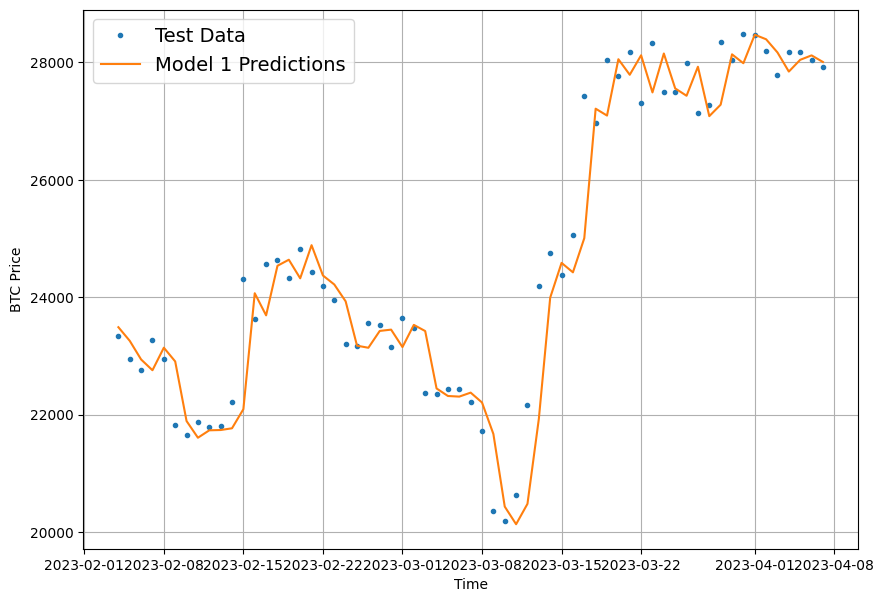

In [ ]:
# Plot our model 1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model 1 Predictions")

## Model 2: Dense model (window = 30, horizon = 1)

(Same as model 1 but different Hypeparameters)

In [ ]:
WINDOW_SIZE = 30 # use 30 timesteps in the past
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)

In [ ]:
# Make window data with appropiate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3602, 3602)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows,
    labels=full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3241, 361, 3241, 361)

In [ ]:
train_windows[:3], train_labels[:3]

(array([[134.21000671, 144.53999329, 139.        , 116.98999786,
         105.20999908,  97.75      , 112.5       , 115.91000366,
         112.30000305, 111.5       , 113.56600189, 112.66999817,
         117.19999695, 115.24299622, 115.        , 117.98000336,
         111.5       , 114.22000122, 118.76000214, 123.01499939,
         123.4980011 , 121.98999786, 122.        , 122.87999725,
         123.88899994, 126.69999695, 133.19999695, 131.97999573,
         133.47999573, 129.74499512],
        [144.53999329, 139.        , 116.98999786, 105.20999908,
          97.75      , 112.5       , 115.91000366, 112.30000305,
         111.5       , 113.56600189, 112.66999817, 117.19999695,
         115.24299622, 115.        , 117.98000336, 111.5       ,
         114.22000122, 118.76000214, 123.01499939, 123.4980011 ,
         121.98999786, 122.        , 122.87999725, 123.88899994,
         126.69999695, 133.19999695, 131.97999573, 133.47999573,
         129.74499512, 129.        ],
        [139. 

In [ ]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_2_dense")

# Compile the model
model_2.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_2.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_2.name)]
)

Epoch 1/100
21/26 [=======================>......] - ETA: 0s - loss: 3139.2061 - mae: 3139.2061 - mse: 55315260.0000    

26/26 [==============================] - 3s 110ms/step - loss: 2797.0188 - mae: 2797.0188 - mse: 46957424.0000 - val_loss: 2932.8823 - val_mae: 2932.8823 - val_mse: 14830964.0000
Epoch 2/100
 1/26 [>.............................] - ETA: 0s - loss: 1008.2796 - mae: 1008.2796 - mse: 4475144.0000

26/26 [==============================] - 1s 37ms/step - loss: 873.0778 - mae: 873.0778 - mse: 3759270.7500 - val_loss: 1332.6350 - val_mae: 1332.6350 - val_mse: 3106866.0000
Epoch 3/100
 1/26 [>.............................] - ETA: 0s - loss: 951.6086 - mae: 951.6086 - mse: 4610702.0000

26/26 [==============================] - 1s 22ms/step - loss: 667.1702 - mae: 667.1702 - mse: 2322605.0000 - val_loss: 1018.9119 - val_mae: 1018.9119 - val_mse: 2222789.5000
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 626.0201 - mae: 626.0201 - mse: 2059456.3750 - val_loss: 1477.8228 - val_mae: 1477.8228 - val_mse: 3829268.5000
Epoch 5/100
 1/26 [>.............................] - ETA: 0s - loss: 721.0143 - mae: 721.0143 - mse: 2218967.0000

26/26 [==============================] - 1s 21ms/step - loss: 615.1793 - mae: 615.1793 - mse: 2030638.0000 - val_loss: 866.6395 - val_mae: 866.6395 - val_mse: 1662938.3750
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 500.5883 - mae: 500.5883 - mse: 1398809.1250 - val_loss: 1118.1049 - val_mae: 1118.1049 - val_mse: 2377163.7500
Epoch 7/100
 1/26 [>.............................] - ETA: 0s - loss: 428.6212 - mae: 428.6212 - mse: 806770.6250

26/26 [==============================] - 1s 22ms/step - loss: 525.3891 - mae: 525.3891 - mse: 1465638.5000 - val_loss: 798.7635 - val_mae: 798.7635 - val_mse: 1354352.5000
Epoch 8/100
 1/26 [>.............................] - ETA: 0s - loss: 559.5380 - mae: 559.5380 - mse: 1514144.7500

26/26 [==============================] - 1s 22ms/step - loss: 490.7996 - mae: 490.7996 - mse: 1339154.8750 - val_loss: 782.2773 - val_mae: 782.2773 - val_mse: 1275260.2500
Epoch 9/100
26/26 [==============================] - 0s 2ms/step - loss: 467.3778 - mae: 467.3778 - mse: 1186119.7500 - val_loss: 1136.3035 - val_mae: 1136.3035 - val_mse: 1982645.5000
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 451.6744 - mae: 451.6744 - mse: 1117392.6250 - val_loss: 1707.4197 - val_mae: 1707.4197 - val_mse: 4216333.0000
Epoch 11/100
 1/26 [>.............................] - ETA: 0s - loss: 709.3362 - mae: 709.3362 - mse: 3117871.7500

26/26 [==============================] - 1s 22ms/step - loss: 557.3428 - mae: 557.3428 - mse: 1594796.7500 - val_loss: 709.8458 - val_mae: 709.8458 - val_mse: 1072983.8750
Epoch 12/100
26/26 [==============================] - 0s 3ms/step - loss: 489.6352 - mae: 489.6352 - mse: 1279897.8750 - val_loss: 788.3776 - val_mae: 788.3776 - val_mse: 1258227.0000
Epoch 13/100
26/26 [==============================] - 0s 2ms/step - loss: 415.8983 - mae: 415.8983 - mse: 971406.2500 - val_loss: 767.2910 - val_mae: 767.2910 - val_mse: 1139208.6250
Epoch 14/100
 1/26 [>.............................] - ETA: 0s - loss: 454.2941 - mae: 454.2941 - mse: 839437.4375

26/26 [==============================] - 1s 21ms/step - loss: 539.6956 - mae: 539.6956 - mse: 1467517.8750 - val_loss: 675.5626 - val_mae: 675.5626 - val_mse: 968057.4375
Epoch 15/100
26/26 [==============================] - 0s 3ms/step - loss: 434.6665 - mae: 434.6665 - mse: 1023198.0625 - val_loss: 809.3376 - val_mae: 809.3376 - val_mse: 1277970.7500
Epoch 16/100
26/26 [==============================] - 0s 3ms/step - loss: 422.7338 - mae: 422.7338 - mse: 973271.5000 - val_loss: 1114.0963 - val_mae: 1114.0963 - val_mse: 2034136.2500
Epoch 17/100
26/26 [==============================] - 0s 3ms/step - loss: 436.9633 - mae: 436.9633 - mse: 1016184.6875 - val_loss: 737.2444 - val_mae: 737.2444 - val_mse: 1090493.2500
Epoch 18/100
 1/26 [>.............................] - ETA: 0s - loss: 405.2581 - mae: 405.2581 - mse: 1057536.8750

26/26 [==============================] - 1s 22ms/step - loss: 398.5569 - mae: 398.5569 - mse: 893745.6875 - val_loss: 671.6697 - val_mae: 671.6697 - val_mse: 958910.5625
Epoch 19/100
26/26 [==============================] - 0s 2ms/step - loss: 393.9224 - mae: 393.9224 - mse: 885903.6250 - val_loss: 686.1706 - val_mae: 686.1706 - val_mse: 943765.6875
Epoch 20/100
26/26 [==============================] - 0s 4ms/step - loss: 410.4923 - mae: 410.4923 - mse: 890829.5000 - val_loss: 1382.6288 - val_mae: 1382.6288 - val_mse: 2814390.2500
Epoch 21/100
26/26 [==============================] - 0s 2ms/step - loss: 409.9901 - mae: 409.9901 - mse: 940481.6875 - val_loss: 893.8691 - val_mae: 893.8691 - val_mse: 1423887.0000
Epoch 22/100
26/26 [==============================] - 0s 2ms/step - loss: 498.8499 - mae: 498.8499 - mse: 1328577.6250 - val_loss: 797.2537 - val_mae: 797.2537 - val_mse: 1186801.3750
Epoch 23/100
 1/26 [>.............................] - ETA: 0s - loss: 302.4436 - mae: 302.4436 -

26/26 [==============================] - 1s 21ms/step - loss: 391.4587 - mae: 391.4587 - mse: 848238.1875 - val_loss: 632.2367 - val_mae: 632.2368 - val_mse: 860988.2500
Epoch 24/100
26/26 [==============================] - 0s 3ms/step - loss: 367.7068 - mae: 367.7068 - mse: 774089.8750 - val_loss: 723.5505 - val_mae: 723.5505 - val_mse: 1029424.1250
Epoch 25/100
26/26 [==============================] - 0s 3ms/step - loss: 404.3873 - mae: 404.3873 - mse: 930410.6250 - val_loss: 649.7626 - val_mae: 649.7626 - val_mse: 886033.0000
Epoch 26/100
26/26 [==============================] - 0s 2ms/step - loss: 414.8669 - mae: 414.8669 - mse: 916164.1875 - val_loss: 666.9032 - val_mae: 666.9032 - val_mse: 882774.6875
Epoch 27/100
26/26 [==============================] - 0s 3ms/step - loss: 384.0868 - mae: 384.0868 - mse: 822114.2500 - val_loss: 864.4293 - val_mae: 864.4293 - val_mse: 1319307.2500
Epoch 28/100
 1/26 [>.............................] - ETA: 0s - loss: 314.2037 - mae: 314.2037 - mse

26/26 [==============================] - 1s 21ms/step - loss: 369.8967 - mae: 369.8967 - mse: 778289.0625 - val_loss: 594.1378 - val_mae: 594.1378 - val_mse: 780467.9375
Epoch 29/100
26/26 [==============================] - 0s 2ms/step - loss: 355.5755 - mae: 355.5755 - mse: 726664.3125 - val_loss: 615.9409 - val_mae: 615.9409 - val_mse: 821385.3125
Epoch 30/100
26/26 [==============================] - 0s 3ms/step - loss: 373.4079 - mae: 373.4079 - mse: 775643.6875 - val_loss: 704.0718 - val_mae: 704.0718 - val_mse: 933411.7500
Epoch 31/100
26/26 [==============================] - 0s 3ms/step - loss: 374.9434 - mae: 374.9434 - mse: 790340.1875 - val_loss: 777.3895 - val_mae: 777.3895 - val_mse: 1120822.5000
Epoch 32/100
26/26 [==============================] - 0s 3ms/step - loss: 392.4972 - mae: 392.4972 - mse: 865393.8750 - val_loss: 676.3232 - val_mae: 676.3232 - val_mse: 919016.5000
Epoch 33/100
26/26 [==============================] - 0s 2ms/step - loss: 382.9936 - mae: 382.9936 - 

26/26 [==============================] - 1s 22ms/step - loss: 397.6738 - mae: 397.6738 - mse: 873229.1875 - val_loss: 580.3232 - val_mae: 580.3232 - val_mse: 748672.5625
Epoch 36/100
26/26 [==============================] - 0s 2ms/step - loss: 357.7426 - mae: 357.7426 - mse: 725448.5625 - val_loss: 1044.3065 - val_mae: 1044.3065 - val_mse: 1733024.2500
Epoch 37/100
 1/26 [>.............................] - ETA: 0s - loss: 500.3575 - mae: 500.3575 - mse: 1272668.5000

26/26 [==============================] - 1s 21ms/step - loss: 379.5513 - mae: 379.5513 - mse: 807711.4375 - val_loss: 576.6993 - val_mae: 576.6993 - val_mse: 735761.1250
Epoch 38/100
26/26 [==============================] - 0s 3ms/step - loss: 344.2667 - mae: 344.2667 - mse: 692984.3125 - val_loss: 585.7233 - val_mae: 585.7233 - val_mse: 751974.3750
Epoch 39/100
 1/26 [>.............................] - ETA: 0s - loss: 227.0285 - mae: 227.0285 - mse: 273518.8125

26/26 [==============================] - 1s 23ms/step - loss: 368.2535 - mae: 368.2535 - mse: 745930.6875 - val_loss: 573.9402 - val_mae: 573.9402 - val_mse: 725335.0000
Epoch 40/100
26/26 [==============================] - 0s 3ms/step - loss: 393.5824 - mae: 393.5824 - mse: 878536.5000 - val_loss: 958.0692 - val_mae: 958.0692 - val_mse: 1431034.3750
Epoch 41/100
26/26 [==============================] - 0s 3ms/step - loss: 397.4344 - mae: 397.4344 - mse: 856238.8125 - val_loss: 584.8734 - val_mae: 584.8734 - val_mse: 749078.0625
Epoch 42/100
 1/26 [>.............................] - ETA: 0s - loss: 547.3257 - mae: 547.3257 - mse: 1328934.2500

26/26 [==============================] - 1s 22ms/step - loss: 351.5983 - mae: 351.5983 - mse: 708628.7500 - val_loss: 569.3118 - val_mae: 569.3118 - val_mse: 716299.8750
Epoch 43/100
26/26 [==============================] - 0s 3ms/step - loss: 363.6127 - mae: 363.6127 - mse: 769224.8750 - val_loss: 974.7676 - val_mae: 974.7676 - val_mse: 1553692.5000
Epoch 44/100
26/26 [==============================] - 0s 3ms/step - loss: 373.6168 - mae: 373.6168 - mse: 794595.5625 - val_loss: 765.6401 - val_mae: 765.6401 - val_mse: 1025391.6250
Epoch 45/100
26/26 [==============================] - 0s 4ms/step - loss: 388.7040 - mae: 388.7040 - mse: 836119.0000 - val_loss: 572.9470 - val_mae: 572.9470 - val_mse: 720360.6250
Epoch 46/100
26/26 [==============================] - 0s 3ms/step - loss: 335.2968 - mae: 335.2968 - mse: 660447.0000 - val_loss: 695.9093 - val_mae: 695.9093 - val_mse: 903299.1875
Epoch 47/100
26/26 [==============================] - 0s 3ms/step - loss: 453.9071 - mae: 453.9071 -

26/26 [==============================] - 1s 26ms/step - loss: 341.3237 - mae: 341.3237 - mse: 679511.9375 - val_loss: 564.4586 - val_mae: 564.4586 - val_mse: 695428.3750
Epoch 56/100
26/26 [==============================] - 0s 4ms/step - loss: 337.9180 - mae: 337.9180 - mse: 671396.5625 - val_loss: 772.0724 - val_mae: 772.0724 - val_mse: 1029058.8125
Epoch 57/100
26/26 [==============================] - 0s 4ms/step - loss: 410.9413 - mae: 410.9413 - mse: 924843.0000 - val_loss: 626.0922 - val_mae: 626.0922 - val_mse: 805115.9375
Epoch 58/100
26/26 [==============================] - 0s 3ms/step - loss: 342.1918 - mae: 342.1918 - mse: 660539.5000 - val_loss: 619.4855 - val_mae: 619.4855 - val_mse: 777898.4375
Epoch 59/100
26/26 [==============================] - 0s 4ms/step - loss: 361.7541 - mae: 361.7541 - mse: 724422.0000 - val_loss: 796.4698 - val_mae: 796.4698 - val_mse: 1126723.0000
Epoch 60/100
26/26 [==============================] - 0s 3ms/step - loss: 353.8979 - mae: 353.8979 -

26/26 [==============================] - 1s 35ms/step - loss: 350.5872 - mae: 350.5872 - mse: 688061.5000 - val_loss: 554.4365 - val_mae: 554.4365 - val_mse: 667350.5625
Epoch 68/100
26/26 [==============================] - 0s 3ms/step - loss: 411.8792 - mae: 411.8792 - mse: 865058.8125 - val_loss: 1703.1991 - val_mae: 1703.1991 - val_mse: 3844429.2500
Epoch 69/100
26/26 [==============================] - 0s 2ms/step - loss: 422.8414 - mae: 422.8414 - mse: 987823.5625 - val_loss: 735.5240 - val_mae: 735.5240 - val_mse: 954002.4375
Epoch 70/100
26/26 [==============================] - 0s 3ms/step - loss: 346.7652 - mae: 346.7652 - mse: 688826.7500 - val_loss: 600.6057 - val_mae: 600.6057 - val_mse: 764455.6875
Epoch 71/100
26/26 [==============================] - 0s 2ms/step - loss: 369.8708 - mae: 369.8708 - mse: 759304.7500 - val_loss: 603.7488 - val_mae: 603.7488 - val_mse: 749523.6875
Epoch 72/100
26/26 [==============================] - 0s 3ms/step - loss: 394.7891 - mae: 394.7891 

26/26 [==============================] - 1s 21ms/step - loss: 357.9381 - mae: 357.9381 - mse: 747794.6250 - val_loss: 551.2482 - val_mae: 551.2482 - val_mse: 671646.6875
Epoch 84/100
26/26 [==============================] - 0s 2ms/step - loss: 409.6725 - mae: 409.6725 - mse: 894544.9375 - val_loss: 772.0861 - val_mae: 772.0861 - val_mse: 1075422.0000
Epoch 85/100
26/26 [==============================] - 0s 2ms/step - loss: 341.7183 - mae: 341.7183 - mse: 650640.2500 - val_loss: 580.3694 - val_mae: 580.3694 - val_mse: 703683.8125
Epoch 86/100
26/26 [==============================] - 0s 3ms/step - loss: 350.4003 - mae: 350.4003 - mse: 676130.1250 - val_loss: 555.0035 - val_mae: 555.0035 - val_mse: 674083.4375
Epoch 87/100
26/26 [==============================] - 0s 3ms/step - loss: 351.2849 - mae: 351.2849 - mse: 688411.5000 - val_loss: 554.8141 - val_mae: 554.8141 - val_mse: 669059.9375
Epoch 88/100
26/26 [==============================] - 0s 2ms/step - loss: 320.9146 - mae: 320.9146 - 

26/26 [==============================] - 1s 22ms/step - loss: 319.6223 - mae: 319.6223 - mse: 598692.3750 - val_loss: 550.7698 - val_mae: 550.7698 - val_mse: 667389.8750
Epoch 94/100
26/26 [==============================] - 0s 2ms/step - loss: 318.5544 - mae: 318.5544 - mse: 587705.5625 - val_loss: 894.8313 - val_mae: 894.8313 - val_mse: 1268204.6250
Epoch 95/100
 1/26 [>.............................] - ETA: 0s - loss: 549.7362 - mae: 549.7362 - mse: 1368951.7500

26/26 [==============================] - 1s 21ms/step - loss: 359.7146 - mae: 359.7146 - mse: 743257.5000 - val_loss: 544.9501 - val_mae: 544.9501 - val_mse: 656881.8125
Epoch 96/100
26/26 [==============================] - 0s 2ms/step - loss: 362.4606 - mae: 362.4606 - mse: 742522.0625 - val_loss: 1140.3589 - val_mae: 1140.3589 - val_mse: 1937178.2500
Epoch 97/100
26/26 [==============================] - 0s 3ms/step - loss: 350.0754 - mae: 350.0754 - mse: 688340.5625 - val_loss: 581.0610 - val_mae: 581.0610 - val_mse: 719379.8750
Epoch 98/100
26/26 [==============================] - 0s 2ms/step - loss: 352.8448 - mae: 352.8448 - mse: 684503.0000 - val_loss: 1589.3726 - val_mae: 1589.3726 - val_mse: 3364369.2500
Epoch 99/100
26/26 [==============================] - 0s 2ms/step - loss: 480.0979 - mae: 480.0979 - mse: 1177526.8750 - val_loss: 1650.7189 - val_mae: 1650.7189 - val_mse: 3592400.7500
Epoch 100/100
26/26 [==============================] - 0s 3ms/step - loss: 409.5760 - mae: 4

In [ ]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 1ms/step - loss: 563.1754 - mae: 563.1754 - mse: 679787.7500


[563.1753540039062, 563.1753540039062, 679787.75]

In [ ]:
# Load in the best performing model
model_2 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_2_dense")
model_2.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 1ms/step - loss: 544.9500 - mae: 544.9500 - mse: 656881.8125


[544.9500122070312, 544.9500122070312, 656881.8125]

In [ ]:
# Get the forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

12/12 [==============================] - 0s 2ms/step


In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_2_preds
)
model_2_results

{'mae': 544.9500916423335,
 'mse': 656881.8168602376,
 'rmse': 810.482459316818,
 'mape': 2.329833518943777,
 'mase': 1.0738993131138068}

In [ ]:
model_1_results

{'mae': 514.3972509476023,
 'mse': 619117.758227413,
 'rmse': 786.8403638778409,
 'mape': 2.161884110645021,
 'mase': 1.0012840192680927}

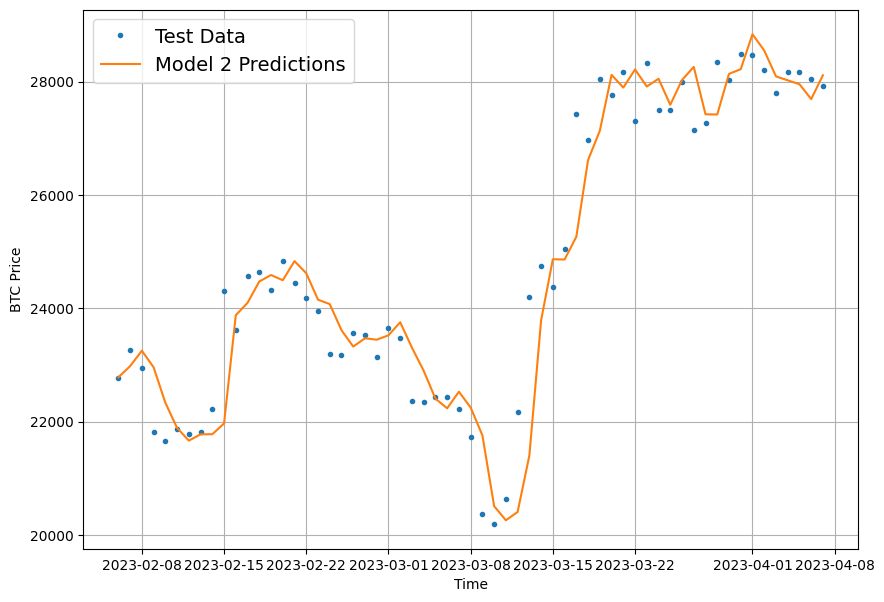

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model 2 Predictions")

## Model 3: Dense (window = 30, horizon = 7)

(Same as model 1 but different Hypeparameters)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3596, 3596)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows = full_windows,
    labels = full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3236, 360, 3236, 360)

In [ ]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_3_dense")

# Compile the model
model_3.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_3.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_3.name)]
)

Epoch 1/100
 1/26 [>.............................] - ETA: 11s - loss: 9608.5684 - mae: 9608.5684 - mse: 373144800.0000

26/26 [==============================] - 2s 63ms/step - loss: 3396.1638 - mae: 3396.1638 - mse: 85016472.0000 - val_loss: 3370.4570 - val_mae: 3370.4570 - val_mse: 21381058.0000
Epoch 2/100
 1/26 [>.............................] - ETA: 0s - loss: 1643.0580 - mae: 1643.0580 - mse: 14519667.0000

26/26 [==============================] - 1s 22ms/step - loss: 1247.6638 - mae: 1247.6638 - mse: 8139301.5000 - val_loss: 2208.7388 - val_mae: 2208.7388 - val_mse: 9169737.0000
Epoch 3/100
 1/26 [>.............................] - ETA: 0s - loss: 1234.6804 - mae: 1234.6804 - mse: 7376088.0000

26/26 [==============================] - 1s 23ms/step - loss: 1087.1219 - mae: 1087.1219 - mse: 6169298.0000 - val_loss: 2001.0507 - val_mae: 2001.0507 - val_mse: 7822139.5000
Epoch 4/100
 1/26 [>.............................] - ETA: 0s - loss: 1036.1586 - mae: 1036.1586 - mse: 5643188.0000

26/26 [==============================] - 1s 22ms/step - loss: 992.0070 - mae: 992.0070 - mse: 5206380.0000 - val_loss: 1799.4893 - val_mae: 1799.4893 - val_mse: 6490580.5000
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 945.5336 - mae: 945.5336 - mse: 4790716.0000 - val_loss: 1953.3359 - val_mae: 1953.3359 - val_mse: 7824075.5000
Epoch 6/100
 1/26 [>.............................] - ETA: 0s - loss: 754.4482 - mae: 754.4482 - mse: 2817053.5000

26/26 [==============================] - 1s 20ms/step - loss: 920.5593 - mae: 920.5593 - mse: 4555516.5000 - val_loss: 1773.4362 - val_mae: 1773.4362 - val_mse: 6418617.0000
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 875.2028 - mae: 875.2028 - mse: 4101259.0000 - val_loss: 1811.4668 - val_mae: 1811.4668 - val_mse: 7010380.0000
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 843.6271 - mae: 843.6271 - mse: 3917557.7500 - val_loss: 1821.4304 - val_mae: 1821.4304 - val_mse: 6957650.5000
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 839.9033 - mae: 839.9033 - mse: 3742025.5000 - val_loss: 1997.3137 - val_mae: 1997.3137 - val_mse: 7957719.5000
Epoch 10/100
24/26 [==========================>...] - ETA: 0s - loss: 832.1959 - mae: 832.1959 - mse: 3753646.0000

26/26 [==============================] - 1s 27ms/step - loss: 832.4274 - mae: 832.4274 - mse: 3747457.0000 - val_loss: 1576.0979 - val_mae: 1576.0979 - val_mse: 5508671.0000
Epoch 11/100
26/26 [==============================] - 0s 3ms/step - loss: 793.5567 - mae: 793.5567 - mse: 3492744.5000 - val_loss: 1639.3469 - val_mae: 1639.3469 - val_mse: 6005798.5000
Epoch 12/100
 1/26 [>.............................] - ETA: 0s - loss: 991.4293 - mae: 991.4293 - mse: 4465468.5000

26/26 [==============================] - 1s 26ms/step - loss: 810.0029 - mae: 810.0029 - mse: 3553726.7500 - val_loss: 1521.8451 - val_mae: 1521.8451 - val_mse: 5308768.0000
Epoch 13/100
 1/26 [>.............................] - ETA: 0s - loss: 828.1653 - mae: 828.1653 - mse: 3670514.5000

26/26 [==============================] - 1s 28ms/step - loss: 816.1255 - mae: 816.1255 - mse: 3564222.5000 - val_loss: 1518.0413 - val_mae: 1518.0413 - val_mse: 5307153.0000
Epoch 14/100
26/26 [==============================] - 0s 3ms/step - loss: 766.6000 - mae: 766.6000 - mse: 3292727.0000 - val_loss: 1523.2009 - val_mae: 1523.2009 - val_mse: 4530713.5000
Epoch 15/100
 1/26 [>.............................] - ETA: 0s - loss: 938.5714 - mae: 938.5714 - mse: 4553581.5000

26/26 [==============================] - 1s 25ms/step - loss: 774.4046 - mae: 774.4046 - mse: 3309456.0000 - val_loss: 1466.4316 - val_mae: 1466.4316 - val_mse: 4920854.0000
Epoch 16/100
 1/26 [>.............................] - ETA: 0s - loss: 751.7072 - mae: 751.7072 - mse: 3171075.7500

26/26 [==============================] - 1s 37ms/step - loss: 749.5765 - mae: 749.5765 - mse: 3139854.2500 - val_loss: 1411.2032 - val_mae: 1411.2032 - val_mse: 4215415.5000
Epoch 17/100
26/26 [==============================] - 0s 2ms/step - loss: 744.4282 - mae: 744.4282 - mse: 3087661.2500 - val_loss: 1427.7042 - val_mae: 1427.7042 - val_mse: 4215463.0000
Epoch 18/100
 1/26 [>.............................] - ETA: 0s - loss: 770.3993 - mae: 770.3993 - mse: 3546204.0000

26/26 [==============================] - 1s 22ms/step - loss: 746.5289 - mae: 746.5289 - mse: 3136750.0000 - val_loss: 1407.4824 - val_mae: 1407.4824 - val_mse: 4433239.5000
Epoch 19/100
26/26 [==============================] - 0s 3ms/step - loss: 721.9203 - mae: 721.9203 - mse: 2916107.7500 - val_loss: 1484.3478 - val_mae: 1484.3478 - val_mse: 5056606.0000
Epoch 20/100
 1/26 [>.............................] - ETA: 0s - loss: 776.7388 - mae: 776.7388 - mse: 3537607.0000

26/26 [==============================] - 1s 20ms/step - loss: 718.8157 - mae: 718.8157 - mse: 2892499.0000 - val_loss: 1295.6017 - val_mae: 1295.6017 - val_mse: 3793066.0000
Epoch 21/100
26/26 [==============================] - 0s 3ms/step - loss: 712.6643 - mae: 712.6643 - mse: 2840157.0000 - val_loss: 1450.4041 - val_mae: 1450.4041 - val_mse: 4223173.0000
Epoch 22/100
26/26 [==============================] - 0s 3ms/step - loss: 718.0091 - mae: 718.0091 - mse: 2857387.0000 - val_loss: 1310.3788 - val_mae: 1310.3788 - val_mse: 4093508.0000
Epoch 23/100
26/26 [==============================] - 0s 2ms/step - loss: 704.4529 - mae: 704.4529 - mse: 2771535.5000 - val_loss: 1313.8075 - val_mae: 1313.8075 - val_mse: 4145676.7500
Epoch 24/100
 1/26 [>.............................] - ETA: 0s - loss: 973.4880 - mae: 973.4880 - mse: 4262194.0000

26/26 [==============================] - 1s 22ms/step - loss: 696.0137 - mae: 696.0137 - mse: 2721833.2500 - val_loss: 1236.1401 - val_mae: 1236.1401 - val_mse: 3561388.0000
Epoch 25/100
26/26 [==============================] - 0s 3ms/step - loss: 707.3680 - mae: 707.3680 - mse: 2791530.0000 - val_loss: 1310.8527 - val_mae: 1310.8527 - val_mse: 3903566.5000
Epoch 26/100
26/26 [==============================] - 0s 3ms/step - loss: 716.4674 - mae: 716.4674 - mse: 2846771.5000 - val_loss: 1628.0527 - val_mae: 1628.0527 - val_mse: 5502380.0000
Epoch 27/100
26/26 [==============================] - 0s 2ms/step - loss: 720.3252 - mae: 720.3252 - mse: 2862796.5000 - val_loss: 1554.5139 - val_mae: 1554.5139 - val_mse: 5173071.0000
Epoch 28/100
 1/26 [>.............................] - ETA: 0s - loss: 677.3119 - mae: 677.3119 - mse: 2304142.7500

26/26 [==============================] - 1s 21ms/step - loss: 730.0201 - mae: 730.0201 - mse: 2969929.5000 - val_loss: 1211.8558 - val_mae: 1211.8558 - val_mse: 3457907.5000
Epoch 29/100
26/26 [==============================] - 0s 2ms/step - loss: 696.9572 - mae: 696.9572 - mse: 2741548.0000 - val_loss: 1299.9922 - val_mae: 1299.9922 - val_mse: 3958981.2500
Epoch 30/100
26/26 [==============================] - 0s 3ms/step - loss: 695.4001 - mae: 695.4001 - mse: 2646593.7500 - val_loss: 1301.1543 - val_mae: 1301.1543 - val_mse: 3969098.2500
Epoch 31/100
 1/26 [>.............................] - ETA: 0s - loss: 798.2164 - mae: 798.2164 - mse: 3339610.5000

26/26 [==============================] - 1s 23ms/step - loss: 677.7523 - mae: 677.7523 - mse: 2617304.5000 - val_loss: 1190.3977 - val_mae: 1190.3977 - val_mse: 3376416.0000
Epoch 32/100
26/26 [==============================] - 0s 3ms/step - loss: 691.3986 - mae: 691.3986 - mse: 2656274.7500 - val_loss: 1397.0085 - val_mae: 1397.0085 - val_mse: 4254679.0000
Epoch 33/100
26/26 [==============================] - 0s 3ms/step - loss: 694.7659 - mae: 694.7659 - mse: 2660747.5000 - val_loss: 1402.2273 - val_mae: 1402.2273 - val_mse: 4400907.5000
Epoch 34/100
 1/26 [>.............................] - ETA: 0s - loss: 626.3816 - mae: 626.3816 - mse: 2443891.7500

26/26 [==============================] - 1s 20ms/step - loss: 689.5895 - mae: 689.5895 - mse: 2649611.0000 - val_loss: 1187.3457 - val_mae: 1187.3458 - val_mse: 3423801.5000
Epoch 35/100
26/26 [==============================] - 0s 3ms/step - loss: 670.0840 - mae: 670.0840 - mse: 2504956.5000 - val_loss: 1474.7980 - val_mae: 1474.7980 - val_mse: 4471278.0000
Epoch 36/100
26/26 [==============================] - 0s 3ms/step - loss: 695.9991 - mae: 695.9991 - mse: 2677427.7500 - val_loss: 1276.4950 - val_mae: 1276.4950 - val_mse: 3462380.0000
Epoch 37/100
26/26 [==============================] - 0s 3ms/step - loss: 692.6649 - mae: 692.6649 - mse: 2676383.7500 - val_loss: 1339.8512 - val_mae: 1339.8512 - val_mse: 4121053.7500
Epoch 38/100
26/26 [==============================] - 0s 3ms/step - loss: 680.3575 - mae: 680.3575 - mse: 2561480.5000 - val_loss: 1247.7166 - val_mae: 1247.7166 - val_mse: 3338009.5000
Epoch 39/100
26/26 [==============================] - 0s 3ms/step - loss: 680.4505

26/26 [==============================] - 1s 22ms/step - loss: 652.2183 - mae: 652.2183 - mse: 2409671.2500 - val_loss: 1163.1206 - val_mae: 1163.1206 - val_mse: 3278383.2500
Epoch 43/100
26/26 [==============================] - 0s 3ms/step - loss: 652.2550 - mae: 652.2550 - mse: 2401629.2500 - val_loss: 1225.1567 - val_mae: 1225.1567 - val_mse: 3483813.2500
Epoch 44/100
26/26 [==============================] - 0s 3ms/step - loss: 663.2311 - mae: 663.2311 - mse: 2484920.2500 - val_loss: 1246.4441 - val_mae: 1246.4441 - val_mse: 3424337.0000
Epoch 45/100
26/26 [==============================] - 0s 3ms/step - loss: 677.5145 - mae: 677.5145 - mse: 2566319.5000 - val_loss: 1232.9741 - val_mae: 1232.9741 - val_mse: 3283932.0000
Epoch 46/100
26/26 [==============================] - 0s 2ms/step - loss: 651.8611 - mae: 651.8611 - mse: 2392704.7500 - val_loss: 1307.7875 - val_mae: 1307.7875 - val_mse: 3759631.7500
Epoch 47/100
26/26 [==============================] - 0s 3ms/step - loss: 662.3843

26/26 [==============================] - 1s 21ms/step - loss: 652.7448 - mae: 652.7448 - mse: 2404925.7500 - val_loss: 1147.5179 - val_mae: 1147.5179 - val_mse: 3055925.0000
Epoch 58/100
26/26 [==============================] - 0s 2ms/step - loss: 653.5925 - mae: 653.5925 - mse: 2386542.0000 - val_loss: 1171.5626 - val_mae: 1171.5626 - val_mse: 3090253.2500
Epoch 59/100
26/26 [==============================] - 0s 2ms/step - loss: 655.7302 - mae: 655.7302 - mse: 2426898.5000 - val_loss: 1222.8871 - val_mae: 1222.8871 - val_mse: 3143099.0000
Epoch 60/100
26/26 [==============================] - 0s 2ms/step - loss: 666.8912 - mae: 666.8912 - mse: 2475157.0000 - val_loss: 1198.0028 - val_mae: 1198.0028 - val_mse: 3231748.2500
Epoch 61/100
26/26 [==============================] - 0s 2ms/step - loss: 665.3722 - mae: 665.3722 - mse: 2450363.5000 - val_loss: 1362.9630 - val_mae: 1362.9630 - val_mse: 4162389.0000
Epoch 62/100
26/26 [==============================] - 0s 3ms/step - loss: 674.4401

26/26 [==============================] - 1s 21ms/step - loss: 643.0084 - mae: 643.0084 - mse: 2361183.0000 - val_loss: 1139.8337 - val_mae: 1139.8337 - val_mse: 3044566.5000
Epoch 66/100
26/26 [==============================] - 0s 3ms/step - loss: 641.2960 - mae: 641.2960 - mse: 2315942.2500 - val_loss: 1263.2216 - val_mae: 1263.2216 - val_mse: 3600223.0000
Epoch 67/100
26/26 [==============================] - 0s 3ms/step - loss: 642.9962 - mae: 642.9962 - mse: 2304337.2500 - val_loss: 1381.2303 - val_mae: 1381.2303 - val_mse: 3839719.0000
Epoch 68/100
26/26 [==============================] - 0s 3ms/step - loss: 656.9392 - mae: 656.9392 - mse: 2395720.2500 - val_loss: 1214.1453 - val_mae: 1214.1453 - val_mse: 3214102.0000
Epoch 69/100
26/26 [==============================] - 0s 3ms/step - loss: 655.7218 - mae: 655.7218 - mse: 2383542.0000 - val_loss: 1163.8893 - val_mae: 1163.8893 - val_mse: 3262493.5000
Epoch 70/100
26/26 [==============================] - 0s 2ms/step - loss: 640.5678

26/26 [==============================] - 1s 27ms/step - loss: 674.3130 - mae: 674.3130 - mse: 2516277.5000 - val_loss: 1124.0409 - val_mae: 1124.0410 - val_mse: 2959887.7500
Epoch 75/100
26/26 [==============================] - 0s 3ms/step - loss: 659.4864 - mae: 659.4864 - mse: 2435822.5000 - val_loss: 1233.6776 - val_mae: 1233.6776 - val_mse: 3352689.0000
Epoch 76/100
26/26 [==============================] - 0s 3ms/step - loss: 627.7274 - mae: 627.7274 - mse: 2237158.0000 - val_loss: 1130.4493 - val_mae: 1130.4493 - val_mse: 2984776.5000
Epoch 77/100
26/26 [==============================] - 0s 3ms/step - loss: 636.8703 - mae: 636.8703 - mse: 2261239.0000 - val_loss: 1325.9176 - val_mae: 1325.9177 - val_mse: 3714857.0000
Epoch 78/100
26/26 [==============================] - 0s 3ms/step - loss: 646.3458 - mae: 646.3458 - mse: 2333642.7500 - val_loss: 1135.8429 - val_mae: 1135.8429 - val_mse: 2959151.2500
Epoch 79/100
26/26 [==============================] - 0s 4ms/step - loss: 638.6121

26/26 [==============================] - 1s 27ms/step - loss: 685.2419 - mae: 685.2419 - mse: 2549088.5000 - val_loss: 1109.3013 - val_mae: 1109.3013 - val_mse: 2956781.7500
Epoch 84/100
26/26 [==============================] - 0s 3ms/step - loss: 644.2616 - mae: 644.2616 - mse: 2326704.7500 - val_loss: 1112.2865 - val_mae: 1112.2865 - val_mse: 2869783.0000
Epoch 85/100
26/26 [==============================] - 0s 3ms/step - loss: 634.3354 - mae: 634.3354 - mse: 2277334.2500 - val_loss: 1127.7667 - val_mae: 1127.7667 - val_mse: 3162444.7500
Epoch 86/100
26/26 [==============================] - 0s 3ms/step - loss: 624.4200 - mae: 624.4200 - mse: 2226100.5000 - val_loss: 1254.8392 - val_mae: 1254.8392 - val_mse: 3599793.7500
Epoch 87/100
26/26 [==============================] - 0s 3ms/step - loss: 634.7720 - mae: 634.7720 - mse: 2265249.2500 - val_loss: 1164.3778 - val_mae: 1164.3778 - val_mse: 3280076.7500
Epoch 88/100
26/26 [==============================] - 0s 4ms/step - loss: 637.6114

26/26 [==============================] - 1s 22ms/step - loss: 642.8787 - mae: 642.8787 - mse: 2309987.2500 - val_loss: 1091.7507 - val_mae: 1091.7507 - val_mse: 2882729.0000
Epoch 100/100
26/26 [==============================] - 0s 3ms/step - loss: 617.5503 - mae: 617.5503 - mse: 2188638.2500 - val_loss: 1116.7811 - val_mae: 1116.7811 - val_mse: 2834413.5000


In [ ]:
# Evaluate model 2 on test data
model_3.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 2ms/step - loss: 1116.7810 - mae: 1116.7810 - mse: 2834413.7500


[1116.781005859375, 1116.781005859375, 2834413.75]

In [ ]:
# Load in the best performing model
model_3 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_3_dense")
model_3.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 1ms/step - loss: 1091.7507 - mae: 1091.7507 - mse: 2882729.5000


[1091.750732421875, 1091.750732421875, 2882729.5]

In [ ]:
# Get the forecasting predictions for model 3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

12/12 [==============================] - 0s 1ms/step


In [ ]:
# Evaluate results for model 3 predictions
model_3_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_3_preds
)
model_3_results

{'mae': 1091.75078419198,
 'mse': 2882729.1728933454,
 'rmse': 1251.6930340386107,
 'mape': 4.723550099053911,
 'mase': 2.1238375507626173}

In [ ]:
model_1_results, model_2_results

({'mae': 514.3972509476023,
  'mse': 619117.758227413,
  'rmse': 786.8403638778409,
  'mape': 2.161884110645021,
  'mase': 1.0012840192680927},
 {'mae': 544.9500916423335,
  'mse': 656881.8168602376,
  'rmse': 810.482459316818,
  'mape': 2.329833518943777,
  'mase': 1.0738993131138068})

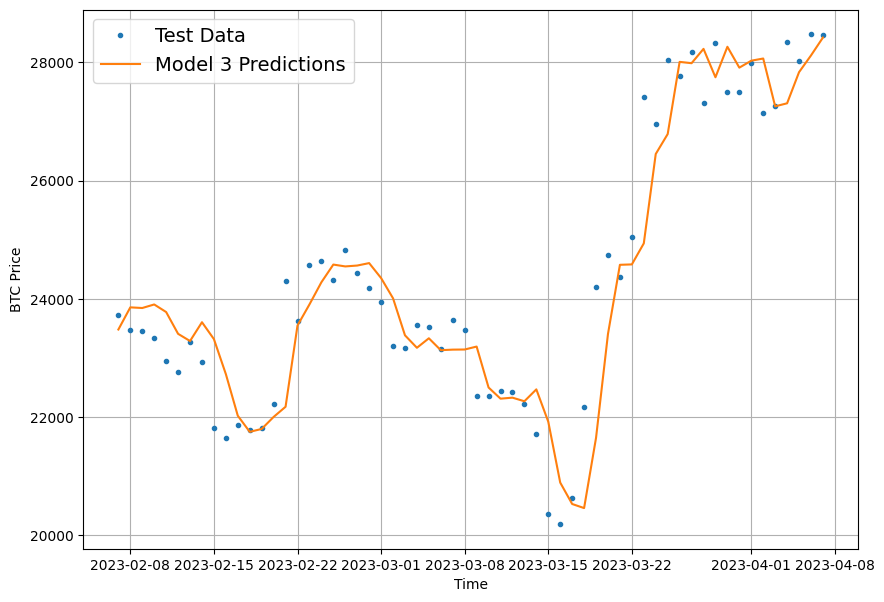

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-", label="Model 3 Predictions")

## Comparing the models build so far to see how well they performed

<Axes: >

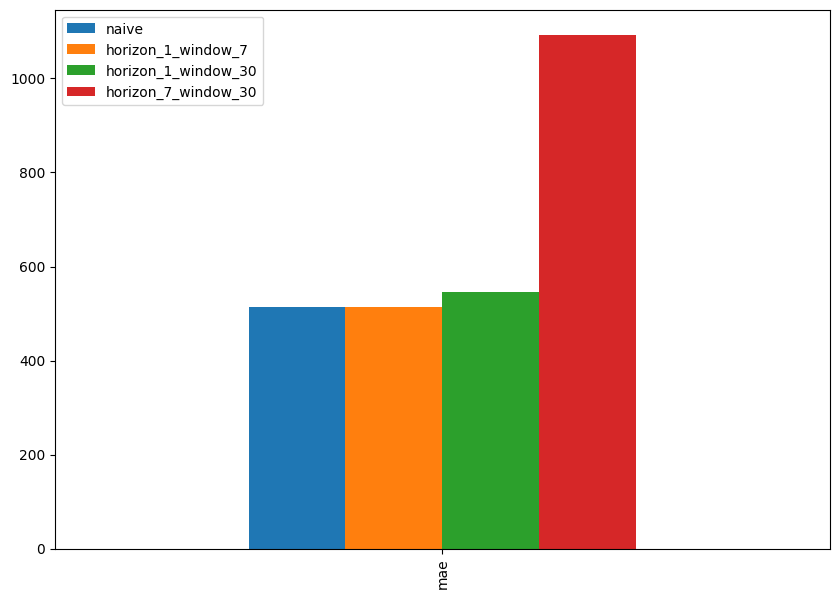

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]
              }, index=["mae"]).plot(figsize=(10, 7), kind="bar")

Note: You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

## Model 4: Conv1D

In [ ]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3625, 3625)

In [ ]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3262, 363, 3262, 363)

We need an input shape of: `(batch_size, timesteps, input_dim)`...

However the data isn't in that shape yet

In [ ]:
# Check data input shape
train_windows[0].shape # returns (WINDOWS_SIZE, )

(7,)

In [ ]:
# Before I pass the data to the Conv1D layer, I will need to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([134.21000671, 144.53999329, 139.        , 116.98999786,
       105.20999908,  97.75      , 112.5       ])>

In [ ]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an exate dimension for input dim

In [ ]:
# Test the lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE, )
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output =  (WINDOW_SIZE, HORIZON)
print(f"Original values with expanded shape: \n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: 
 [[134.21]
 [144.54]
 [139.  ]
 [116.99]
 [105.21]
 [ 97.75]
 [112.5 ]]


In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    expand_dims_layer,
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear", name="output_layer")
], name="model_4_Conv1D")

# Compile the model
model_4.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_4.fit(
    train_windows,
    train_labels,
    batch_size=128,
    epochs=100,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_4.name)]
)

Epoch 1/100
 1/26 [>.............................] - ETA: 18s - loss: 13837.4590 - mae: 13837.4590 - mse: 647405312.0000

26/26 [==============================] - 3s 86ms/step - loss: 5437.7290 - mae: 5437.7290 - mse: 147047168.0000 - val_loss: 2834.2261 - val_mae: 2834.2263 - val_mse: 11068782.0000
Epoch 2/100
 1/26 [>.............................] - ETA: 0s - loss: 841.8613 - mae: 841.8613 - mse: 3940333.0000

26/26 [==============================] - 1s 29ms/step - loss: 890.1837 - mae: 890.1837 - mse: 4069291.5000 - val_loss: 1026.7074 - val_mae: 1026.7074 - val_mse: 2424079.2500
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 554.8643 - mae: 554.8643 - mse: 1656376.3750 - val_loss: 1115.3594 - val_mae: 1115.3594 - val_mse: 2688146.7500
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 532.5423 - mae: 532.5423 - mse: 1525734.8750 - val_loss: 1043.2864 - val_mae: 1043.2864 - val_mse: 2438463.0000
Epoch 5/100
 1/26 [>.............................] - ETA: 0s - loss: 352.7414 - mae: 352.7414 - mse: 832724.8125

26/26 [==============================] - 1s 31ms/step - loss: 527.9867 - mae: 527.9867 - mse: 1515192.3750 - val_loss: 894.8691 - val_mae: 894.8691 - val_mse: 1894361.2500
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 513.4461 - mae: 513.4461 - mse: 1443363.0000 - val_loss: 918.4697 - val_mae: 918.4697 - val_mse: 2012973.5000
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 505.9661 - mae: 505.9661 - mse: 1399577.2500 - val_loss: 1073.2521 - val_mae: 1073.2521 - val_mse: 2437752.5000
Epoch 8/100
 1/26 [>.............................] - ETA: 0s - loss: 713.8580 - mae: 713.8580 - mse: 2546356.7500

26/26 [==============================] - 1s 29ms/step - loss: 505.7947 - mae: 505.7947 - mse: 1414207.0000 - val_loss: 853.1577 - val_mae: 853.1577 - val_mse: 1757721.7500
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 489.3840 - mae: 489.3840 - mse: 1311311.2500 - val_loss: 896.1343 - val_mae: 896.1343 - val_mse: 1873660.8750
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 488.1866 - mae: 488.1866 - mse: 1309438.6250 - val_loss: 888.4315 - val_mae: 888.4315 - val_mse: 1825252.5000
Epoch 11/100
 1/26 [>.............................] - ETA: 0s - loss: 543.8199 - mae: 543.8199 - mse: 1453354.3750

26/26 [==============================] - 1s 30ms/step - loss: 474.3450 - mae: 474.3450 - mse: 1239718.5000 - val_loss: 809.2369 - val_mae: 809.2369 - val_mse: 1578650.2500
Epoch 12/100
 1/26 [>.............................] - ETA: 0s - loss: 374.3038 - mae: 374.3038 - mse: 769330.4375

26/26 [==============================] - 1s 28ms/step - loss: 464.5222 - mae: 464.5222 - mse: 1192860.0000 - val_loss: 790.2733 - val_mae: 790.2733 - val_mse: 1502605.7500
Epoch 13/100
 1/26 [>.............................] - ETA: 0s - loss: 506.1813 - mae: 506.1813 - mse: 1297376.7500

26/26 [==============================] - 1s 30ms/step - loss: 452.9785 - mae: 452.9785 - mse: 1127888.5000 - val_loss: 773.8037 - val_mae: 773.8037 - val_mse: 1441137.7500
Epoch 14/100
26/26 [==============================] - 0s 2ms/step - loss: 444.5409 - mae: 444.5409 - mse: 1074607.5000 - val_loss: 1016.1948 - val_mae: 1016.1948 - val_mse: 2041621.3750
Epoch 15/100
26/26 [==============================] - 0s 3ms/step - loss: 452.9609 - mae: 452.9609 - mse: 1148935.8750 - val_loss: 954.9630 - val_mae: 954.9630 - val_mse: 1846791.6250
Epoch 16/100
26/26 [==============================] - 0s 2ms/step - loss: 437.6783 - mae: 437.6783 - mse: 1047517.3125 - val_loss: 874.1708 - val_mae: 874.1708 - val_mse: 1611595.5000
Epoch 17/100
 1/26 [>.............................] - ETA: 0s - loss: 502.6125 - mae: 502.6125 - mse: 1394280.8750

26/26 [==============================] - 1s 30ms/step - loss: 425.0593 - mae: 425.0593 - mse: 985078.5000 - val_loss: 679.0808 - val_mae: 679.0808 - val_mse: 1110398.3750
Epoch 18/100
26/26 [==============================] - 0s 2ms/step - loss: 400.5351 - mae: 400.5351 - mse: 896799.1875 - val_loss: 776.1493 - val_mae: 776.1493 - val_mse: 1301208.6250
Epoch 19/100
 1/26 [>.............................] - ETA: 0s - loss: 428.8661 - mae: 428.8661 - mse: 1041360.2500

26/26 [==============================] - 1s 27ms/step - loss: 388.9920 - mae: 388.9920 - mse: 841765.2500 - val_loss: 650.1138 - val_mae: 650.1138 - val_mse: 978482.9375
Epoch 20/100
26/26 [==============================] - 0s 3ms/step - loss: 384.2198 - mae: 384.2198 - mse: 808345.4375 - val_loss: 670.9629 - val_mae: 670.9629 - val_mse: 1034180.2500
Epoch 21/100
26/26 [==============================] - 0s 3ms/step - loss: 376.8788 - mae: 376.8788 - mse: 797530.5000 - val_loss: 816.6008 - val_mae: 816.6008 - val_mse: 1332610.0000
Epoch 22/100
 1/26 [>.............................] - ETA: 0s - loss: 455.3692 - mae: 455.3692 - mse: 1153846.0000

26/26 [==============================] - 1s 29ms/step - loss: 379.2993 - mae: 379.2993 - mse: 813695.6875 - val_loss: 637.1166 - val_mae: 637.1166 - val_mse: 877979.3125
Epoch 23/100
 1/26 [>.............................] - ETA: 0s - loss: 309.7116 - mae: 309.7116 - mse: 575257.3125

26/26 [==============================] - 1s 46ms/step - loss: 361.7057 - mae: 361.7057 - mse: 743362.6250 - val_loss: 605.0090 - val_mae: 605.0090 - val_mse: 835433.0625
Epoch 24/100
 1/26 [>.............................] - ETA: 0s - loss: 276.3730 - mae: 276.3730 - mse: 347959.2500

26/26 [==============================] - 1s 37ms/step - loss: 356.5326 - mae: 356.5326 - mse: 744764.2500 - val_loss: 592.0581 - val_mae: 592.0581 - val_mse: 818833.6250
Epoch 25/100
26/26 [==============================] - 0s 3ms/step - loss: 373.0111 - mae: 373.0111 - mse: 787760.7500 - val_loss: 748.7102 - val_mae: 748.7102 - val_mse: 1134797.3750
Epoch 26/100
26/26 [==============================] - 0s 3ms/step - loss: 341.7197 - mae: 341.7197 - mse: 675534.0000 - val_loss: 594.2743 - val_mae: 594.2743 - val_mse: 782114.6250
Epoch 27/100
26/26 [==============================] - ETA: 0s - loss: 341.3615 - mae: 341.3615 - mse: 679356.3750 

26/26 [==============================] - 1s 39ms/step - loss: 341.3615 - mae: 341.3615 - mse: 679356.3750 - val_loss: 576.9108 - val_mae: 576.9108 - val_mse: 762989.5000
Epoch 28/100
26/26 [==============================] - 0s 4ms/step - loss: 341.1285 - mae: 341.1285 - mse: 671345.0625 - val_loss: 787.5880 - val_mae: 787.5880 - val_mse: 1187590.7500
Epoch 29/100
26/26 [==============================] - 0s 4ms/step - loss: 344.8482 - mae: 344.8482 - mse: 697978.1875 - val_loss: 597.3237 - val_mae: 597.3237 - val_mse: 814011.7500
Epoch 30/100
26/26 [==============================] - 0s 3ms/step - loss: 336.6529 - mae: 336.6529 - mse: 665104.5625 - val_loss: 587.9173 - val_mae: 587.9173 - val_mse: 745058.6250
Epoch 31/100
26/26 [==============================] - 0s 3ms/step - loss: 331.0277 - mae: 331.0277 - mse: 628877.3125 - val_loss: 628.9067 - val_mae: 628.9067 - val_mse: 787536.8125
Epoch 32/100
26/26 [==============================] - 0s 2ms/step - loss: 335.8428 - mae: 335.8428 - 

26/26 [==============================] - 1s 29ms/step - loss: 349.4150 - mae: 349.4150 - mse: 667762.5625 - val_loss: 554.3184 - val_mae: 554.3184 - val_mse: 712404.4375
Epoch 35/100
26/26 [==============================] - 0s 2ms/step - loss: 330.9643 - mae: 330.9643 - mse: 633563.1250 - val_loss: 570.1187 - val_mae: 570.1187 - val_mse: 746632.1250
Epoch 36/100
26/26 [==============================] - 0s 3ms/step - loss: 326.2462 - mae: 326.2462 - mse: 629819.1250 - val_loss: 575.7213 - val_mae: 575.7213 - val_mse: 710717.6875
Epoch 37/100
26/26 [==============================] - 0s 3ms/step - loss: 325.8614 - mae: 325.8614 - mse: 631259.5000 - val_loss: 568.1313 - val_mae: 568.1313 - val_mse: 701206.1875
Epoch 38/100
26/26 [==============================] - 0s 3ms/step - loss: 319.7458 - mae: 319.7458 - mse: 608636.6250 - val_loss: 638.1272 - val_mae: 638.1272 - val_mse: 856104.8750
Epoch 39/100
 1/26 [>.............................] - ETA: 0s - loss: 314.8781 - mae: 314.8781 - mse: 

26/26 [==============================] - 1s 30ms/step - loss: 324.0772 - mae: 324.0772 - mse: 628518.9375 - val_loss: 544.9809 - val_mae: 544.9809 - val_mse: 683337.1250
Epoch 40/100
26/26 [==============================] - 0s 2ms/step - loss: 318.4894 - mae: 318.4894 - mse: 604228.6250 - val_loss: 547.7040 - val_mae: 547.7040 - val_mse: 678227.7500
Epoch 41/100
 1/26 [>.............................] - ETA: 0s - loss: 349.1457 - mae: 349.1457 - mse: 928698.1250

26/26 [==============================] - 1s 28ms/step - loss: 320.1182 - mae: 320.1182 - mse: 615934.2500 - val_loss: 544.5623 - val_mae: 544.5623 - val_mse: 687004.5625
Epoch 42/100
26/26 [==============================] - 0s 2ms/step - loss: 324.5810 - mae: 324.5810 - mse: 616280.6875 - val_loss: 553.7293 - val_mae: 553.7293 - val_mse: 676752.2500
Epoch 43/100
26/26 [==============================] - 0s 3ms/step - loss: 324.1881 - mae: 324.1881 - mse: 609845.3125 - val_loss: 811.2836 - val_mae: 811.2836 - val_mse: 1177327.1250
Epoch 44/100
26/26 [==============================] - 0s 3ms/step - loss: 334.6968 - mae: 334.6968 - mse: 651927.3125 - val_loss: 805.9855 - val_mae: 805.9855 - val_mse: 1048566.6250
Epoch 45/100
 1/26 [>.............................] - ETA: 0s - loss: 465.7568 - mae: 465.7568 - mse: 830474.6250

26/26 [==============================] - 1s 30ms/step - loss: 337.8374 - mae: 337.8374 - mse: 645096.3125 - val_loss: 541.0323 - val_mae: 541.0323 - val_mse: 679680.0000
Epoch 46/100
 1/26 [>.............................] - ETA: 0s - loss: 209.9845 - mae: 209.9845 - mse: 278981.6875

26/26 [==============================] - 1s 28ms/step - loss: 318.5277 - mae: 318.5277 - mse: 596157.0625 - val_loss: 539.4377 - val_mae: 539.4377 - val_mse: 663043.1875
Epoch 47/100
26/26 [==============================] - 0s 3ms/step - loss: 312.5526 - mae: 312.5526 - mse: 589465.6875 - val_loss: 579.5162 - val_mae: 579.5162 - val_mse: 745509.3750
Epoch 48/100
26/26 [==============================] - 0s 3ms/step - loss: 313.4372 - mae: 313.4372 - mse: 598138.8750 - val_loss: 620.9832 - val_mae: 620.9832 - val_mse: 811376.5000
Epoch 49/100
26/26 [==============================] - 0s 3ms/step - loss: 327.1587 - mae: 327.1587 - mse: 636756.6875 - val_loss: 543.8256 - val_mae: 543.8256 - val_mse: 684801.1250
Epoch 50/100
26/26 [==============================] - 0s 2ms/step - loss: 311.1340 - mae: 311.1340 - mse: 588348.3750 - val_loss: 542.0300 - val_mae: 542.0300 - val_mse: 680890.3750
Epoch 51/100
 1/26 [>.............................] - ETA: 0s - loss: 396.2842 - mae: 396.2842 - mse: 

26/26 [==============================] - 1s 28ms/step - loss: 309.5146 - mae: 309.5146 - mse: 583390.6250 - val_loss: 532.5480 - val_mae: 532.5480 - val_mse: 656869.9375
Epoch 52/100
26/26 [==============================] - 0s 3ms/step - loss: 309.4443 - mae: 309.4443 - mse: 589213.5000 - val_loss: 532.8821 - val_mae: 532.8821 - val_mse: 650223.9375
Epoch 53/100
26/26 [==============================] - 0s 2ms/step - loss: 307.6909 - mae: 307.6909 - mse: 574448.2500 - val_loss: 596.6470 - val_mae: 596.6470 - val_mse: 766661.3125
Epoch 54/100
26/26 [==============================] - 0s 2ms/step - loss: 323.0345 - mae: 323.0345 - mse: 628896.7500 - val_loss: 641.0591 - val_mae: 641.0591 - val_mse: 842212.8750
Epoch 55/100
 1/26 [>.............................] - ETA: 0s - loss: 305.6706 - mae: 305.6706 - mse: 721754.1250

26/26 [==============================] - 1s 28ms/step - loss: 305.5879 - mae: 305.5879 - mse: 572934.2500 - val_loss: 530.2991 - val_mae: 530.2991 - val_mse: 645635.8125
Epoch 56/100
26/26 [==============================] - 0s 3ms/step - loss: 317.3077 - mae: 317.3077 - mse: 610815.1250 - val_loss: 565.9289 - val_mae: 565.9289 - val_mse: 675267.8750
Epoch 57/100
26/26 [==============================] - 0s 2ms/step - loss: 352.4159 - mae: 352.4159 - mse: 708644.8750 - val_loss: 726.6976 - val_mae: 726.6976 - val_mse: 904912.3125
Epoch 58/100
26/26 [==============================] - 0s 2ms/step - loss: 311.4156 - mae: 311.4156 - mse: 591515.8125 - val_loss: 578.2343 - val_mae: 578.2343 - val_mse: 689458.5000
Epoch 59/100
26/26 [==============================] - 0s 3ms/step - loss: 307.1773 - mae: 307.1773 - mse: 579111.1250 - val_loss: 537.3640 - val_mae: 537.3640 - val_mse: 672684.6250
Epoch 60/100
 1/26 [>.............................] - ETA: 0s - loss: 230.5937 - mae: 230.5937 - mse: 

26/26 [==============================] - 1s 27ms/step - loss: 303.3617 - mae: 303.3617 - mse: 558309.5000 - val_loss: 526.0253 - val_mae: 526.0253 - val_mse: 647412.1250
Epoch 61/100
26/26 [==============================] - 0s 2ms/step - loss: 311.8829 - mae: 311.8829 - mse: 580826.6250 - val_loss: 557.6292 - val_mae: 557.6292 - val_mse: 703713.7500
Epoch 62/100
26/26 [==============================] - 0s 2ms/step - loss: 306.6249 - mae: 306.6249 - mse: 573683.0000 - val_loss: 539.5679 - val_mae: 539.5679 - val_mse: 674874.2500
Epoch 63/100
 1/26 [>.............................] - ETA: 0s - loss: 327.7931 - mae: 327.7931 - mse: 527394.0625

26/26 [==============================] - 1s 29ms/step - loss: 307.1891 - mae: 307.1891 - mse: 574885.0625 - val_loss: 523.6412 - val_mae: 523.6412 - val_mse: 638692.5000
Epoch 64/100
26/26 [==============================] - 0s 2ms/step - loss: 301.5548 - mae: 301.5548 - mse: 560422.7500 - val_loss: 527.5192 - val_mae: 527.5192 - val_mse: 652988.5000
Epoch 65/100
26/26 [==============================] - 0s 2ms/step - loss: 302.3551 - mae: 302.3551 - mse: 565159.9375 - val_loss: 524.7123 - val_mae: 524.7123 - val_mse: 637834.9375
Epoch 66/100
 1/26 [>.............................] - ETA: 0s - loss: 311.8585 - mae: 311.8585 - mse: 579912.6250

26/26 [==============================] - 1s 45ms/step - loss: 314.3757 - mae: 314.3757 - mse: 599957.5625 - val_loss: 523.2292 - val_mae: 523.2292 - val_mse: 637644.3125
Epoch 67/100
26/26 [==============================] - 0s 2ms/step - loss: 308.6517 - mae: 308.6517 - mse: 592159.9375 - val_loss: 628.3773 - val_mae: 628.3773 - val_mse: 816518.6250
Epoch 68/100
26/26 [==============================] - 0s 3ms/step - loss: 305.4726 - mae: 305.4726 - mse: 560003.6250 - val_loss: 610.3959 - val_mae: 610.3959 - val_mse: 730932.1875
Epoch 69/100
26/26 [==============================] - 0s 2ms/step - loss: 311.0410 - mae: 311.0410 - mse: 572216.2500 - val_loss: 534.1452 - val_mae: 534.1452 - val_mse: 640365.5625
Epoch 70/100
26/26 [==============================] - 0s 3ms/step - loss: 308.4264 - mae: 308.4264 - mse: 575001.5000 - val_loss: 553.9086 - val_mae: 553.9086 - val_mse: 658362.0625
Epoch 71/100
26/26 [==============================] - 0s 4ms/step - loss: 305.9220 - mae: 305.9220 - m

26/26 [==============================] - 1s 39ms/step - loss: 301.6118 - mae: 301.6118 - mse: 565662.0000 - val_loss: 519.8769 - val_mae: 519.8769 - val_mse: 633452.6875
Epoch 73/100
26/26 [==============================] - 0s 4ms/step - loss: 297.7376 - mae: 297.7376 - mse: 552911.6875 - val_loss: 687.3391 - val_mae: 687.3391 - val_mse: 918056.5625
Epoch 74/100
26/26 [==============================] - 0s 3ms/step - loss: 305.2943 - mae: 305.2943 - mse: 564627.3750 - val_loss: 521.3981 - val_mae: 521.3981 - val_mse: 627090.3125
Epoch 75/100
26/26 [==============================] - 0s 3ms/step - loss: 309.9510 - mae: 309.9510 - mse: 584719.5000 - val_loss: 551.4386 - val_mae: 551.4386 - val_mse: 653072.9375
Epoch 76/100
26/26 [==============================] - 0s 4ms/step - loss: 315.2112 - mae: 315.2112 - mse: 591135.3750 - val_loss: 546.7638 - val_mae: 546.7638 - val_mse: 650357.3750
Epoch 77/100
26/26 [==============================] - 0s 4ms/step - loss: 304.4157 - mae: 304.4157 - m

26/26 [==============================] - 1s 36ms/step - loss: 332.8987 - mae: 332.8987 - mse: 636203.6250 - val_loss: 517.2003 - val_mae: 517.2003 - val_mse: 628504.8125
Epoch 84/100
26/26 [==============================] - 0s 3ms/step - loss: 332.5619 - mae: 332.5619 - mse: 637582.5000 - val_loss: 584.1255 - val_mae: 584.1255 - val_mse: 697006.2500
Epoch 85/100
26/26 [==============================] - 0s 2ms/step - loss: 302.4200 - mae: 302.4200 - mse: 569382.5625 - val_loss: 522.4427 - val_mae: 522.4427 - val_mse: 628541.7500
Epoch 86/100
26/26 [==============================] - 0s 3ms/step - loss: 312.8083 - mae: 312.8083 - mse: 590939.2500 - val_loss: 544.8484 - val_mae: 544.8484 - val_mse: 680801.7500
Epoch 87/100
26/26 [==============================] - 0s 2ms/step - loss: 301.5093 - mae: 301.5093 - mse: 563556.1250 - val_loss: 519.3553 - val_mae: 519.3553 - val_mse: 636142.1875
Epoch 88/100
26/26 [==============================] - 0s 3ms/step - loss: 298.4068 - mae: 298.4068 - m

In [ ]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 output_layer (Dense)        (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 2ms/step - loss: 518.7401 - mae: 518.7401 - mse: 621921.4375


[518.7401123046875, 518.7401123046875, 621921.4375]

In [ ]:
# Load back in best performing Conv1D model and re-evaluate
model_4 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 2ms/step - loss: 517.2003 - mae: 517.2003 - mse: 628504.8750


[517.2003173828125, 517.2003173828125, 628504.875]

In [ ]:
# Get the forecasting predictions for model 3
model_4_preds = make_preds(
    model_4,
    test_windows
)
model_4_preds[:10]

12/12 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([42549.168, 42166.305, 39858.117, 39906.062, 40702.293, 40057.45 ,
       40463.207, 40302.168, 39785.67 , 40605.336], dtype=float32)>

In [ ]:
# Evaluate results for model 4 predictions
model_4_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_4_preds
)
model_4_results

{'mae': 517.2003266153357,
 'mse': 628504.8392877223,
 'rmse': 792.7829711136095,
 'mape': 2.180878881169363,
 'mase': 1.006740259296068}

In [ ]:
model_1_results, model_2_results, model_3_results

({'mae': 514.3972509476023,
  'mse': 619117.758227413,
  'rmse': 786.8403638778409,
  'mape': 2.161884110645021,
  'mase': 1.0012840192680927},
 {'mae': 544.9500916423335,
  'mse': 656881.8168602376,
  'rmse': 810.482459316818,
  'mape': 2.329833518943777,
  'mase': 1.0738993131138068},
 {'mae': 1091.75078419198,
  'mse': 2882729.1728933454,
  'rmse': 1251.6930340386107,
  'mape': 4.723550099053911,
  'mase': 2.1238375507626173})

## Model 5: RNN (LSTM)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create LSTM model with Functional API
inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = tf.keras.layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = tf.keras.layers.LSTM(128, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile the model
model_5.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_5.name)]
)

Epoch 1/100
22/26 [========================>.....] - ETA: 0s - loss: 9707.4033 - mae: 9707.4033 - mse: 319309664.0000  

26/26 [==============================] - 7s 188ms/step - loss: 9399.7656 - mae: 9399.7656 - mse: 304075232.0000 - val_loss: 17208.6660 - val_mae: 17208.6660 - val_mse: 316605184.0000
Epoch 2/100
23/26 [=========================>....] - ETA: 0s - loss: 3007.7915 - mae: 3007.7915 - mse: 46372412.0000

26/26 [==============================] - 3s 132ms/step - loss: 2797.1995 - mae: 2797.1995 - mse: 42179212.0000 - val_loss: 2115.7444 - val_mae: 2115.7444 - val_mse: 5661154.5000
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 673.0410 - mae: 673.0410 - mse: 2358786.7500

26/26 [==============================] - 3s 123ms/step - loss: 673.0410 - mae: 673.0410 - mse: 2358786.7500 - val_loss: 1179.9919 - val_mae: 1179.9919 - val_mse: 2954948.5000
Epoch 4/100
26/26 [==============================] - 0s 9ms/step - loss: 553.2529 - mae: 553.2529 - mse: 1624986.5000 - val_loss: 1325.7076 - val_mae: 1325.7076 - val_mse: 3190879.2500
Epoch 5/100
22/26 [========================>.....] - ETA: 0s - loss: 529.2797 - mae: 529.2797 - mse: 1513377.1250

26/26 [==============================] - 4s 145ms/step - loss: 544.5752 - mae: 544.5752 - mse: 1600168.1250 - val_loss: 913.6378 - val_mae: 913.6378 - val_mse: 1934765.1250
Epoch 6/100
21/26 [=======================>......] - ETA: 0s - loss: 516.7712 - mae: 516.7712 - mse: 1437495.0000

26/26 [==============================] - 4s 149ms/step - loss: 502.6036 - mae: 502.6036 - mse: 1380439.3750 - val_loss: 880.4302 - val_mae: 880.4302 - val_mse: 1762682.7500
Epoch 7/100
26/26 [==============================] - 0s 9ms/step - loss: 505.6417 - mae: 505.6417 - mse: 1355323.1250 - val_loss: 1192.8337 - val_mae: 1192.8337 - val_mse: 2822092.0000
Epoch 8/100
24/26 [==========================>...] - ETA: 0s - loss: 556.5187 - mae: 556.5187 - mse: 1646194.6250

26/26 [==============================] - 3s 119ms/step - loss: 552.8084 - mae: 552.8084 - mse: 1630375.1250 - val_loss: 865.8079 - val_mae: 865.8079 - val_mse: 1767840.7500
Epoch 9/100
26/26 [==============================] - 0s 9ms/step - loss: 516.4684 - mae: 516.4684 - mse: 1438936.8750 - val_loss: 1303.4231 - val_mae: 1303.4231 - val_mse: 3106015.2500
Epoch 10/100
26/26 [==============================] - 0s 8ms/step - loss: 537.4221 - mae: 537.4221 - mse: 1500463.5000 - val_loss: 1005.1516 - val_mae: 1005.1516 - val_mse: 2141373.0000
Epoch 11/100
23/26 [=========================>....] - ETA: 0s - loss: 519.3137 - mae: 519.3137 - mse: 1477831.0000

26/26 [==============================] - 4s 142ms/step - loss: 522.2700 - mae: 522.2700 - mse: 1492346.8750 - val_loss: 858.5506 - val_mae: 858.5506 - val_mse: 1540316.3750
Epoch 12/100
23/26 [=========================>....] - ETA: 0s - loss: 465.4173 - mae: 465.4173 - mse: 1201670.1250

26/26 [==============================] - 3s 135ms/step - loss: 471.8578 - mae: 471.8578 - mse: 1219603.7500 - val_loss: 801.4354 - val_mae: 801.4354 - val_mse: 1550263.0000
Epoch 13/100
25/26 [===========================>..] - ETA: 0s - loss: 457.3583 - mae: 457.3583 - mse: 1150185.8750

26/26 [==============================] - 4s 158ms/step - loss: 459.8325 - mae: 459.8325 - mse: 1158159.5000 - val_loss: 793.6533 - val_mae: 793.6533 - val_mse: 1506689.2500
Epoch 14/100
26/26 [==============================] - 0s 10ms/step - loss: 450.3434 - mae: 450.3434 - mse: 1120073.6250 - val_loss: 939.6560 - val_mae: 939.6560 - val_mse: 1825464.6250
Epoch 15/100
22/26 [========================>.....] - ETA: 0s - loss: 427.9516 - mae: 427.9516 - mse: 1018579.0625

26/26 [==============================] - 3s 127ms/step - loss: 440.5078 - mae: 440.5078 - mse: 1055548.5000 - val_loss: 749.5975 - val_mae: 749.5975 - val_mse: 1271265.5000
Epoch 16/100
26/26 [==============================] - 0s 9ms/step - loss: 434.6216 - mae: 434.6216 - mse: 1027226.0000 - val_loss: 954.8578 - val_mae: 954.8578 - val_mse: 1792868.8750
Epoch 17/100
22/26 [========================>.....] - ETA: 0s - loss: 453.9144 - mae: 453.9144 - mse: 1114302.3750

26/26 [==============================] - 3s 121ms/step - loss: 439.3349 - mae: 439.3349 - mse: 1049049.0000 - val_loss: 707.1174 - val_mae: 707.1174 - val_mse: 1182032.0000
Epoch 18/100
21/26 [=======================>......] - ETA: 0s - loss: 426.6220 - mae: 426.6220 - mse: 992744.5000 

26/26 [==============================] - 4s 166ms/step - loss: 416.2504 - mae: 416.2504 - mse: 953423.8125 - val_loss: 678.6411 - val_mae: 678.6411 - val_mse: 1086427.3750
Epoch 19/100
26/26 [==============================] - 0s 9ms/step - loss: 411.0184 - mae: 411.0184 - mse: 917731.1875 - val_loss: 973.0388 - val_mae: 973.0388 - val_mse: 1493147.5000
Epoch 20/100
21/26 [=======================>......] - ETA: 0s - loss: 431.2422 - mae: 431.2422 - mse: 954682.5625

26/26 [==============================] - 3s 122ms/step - loss: 443.9816 - mae: 443.9816 - mse: 1013421.6875 - val_loss: 654.7150 - val_mae: 654.7150 - val_mse: 1001102.5625
Epoch 21/100
26/26 [==============================] - 0s 9ms/step - loss: 419.8353 - mae: 419.8353 - mse: 959671.5000 - val_loss: 706.5631 - val_mae: 706.5631 - val_mse: 1107715.5000
Epoch 22/100
26/26 [==============================] - 0s 9ms/step - loss: 379.3034 - mae: 379.3034 - mse: 803235.6875 - val_loss: 669.1165 - val_mae: 669.1165 - val_mse: 1013951.5625
Epoch 23/100
26/26 [==============================] - 0s 9ms/step - loss: 367.3867 - mae: 367.3867 - mse: 760138.6250 - val_loss: 724.1254 - val_mae: 724.1254 - val_mse: 994549.7500
Epoch 24/100
26/26 [==============================] - 0s 10ms/step - loss: 376.7956 - mae: 376.7956 - mse: 798147.4375 - val_loss: 952.2247 - val_mae: 952.2247 - val_mse: 1400831.8750
Epoch 25/100
22/26 [========================>.....] - ETA: 0s - loss: 374.2750 - mae: 374.2750 

26/26 [==============================] - 3s 139ms/step - loss: 380.5993 - mae: 380.5993 - mse: 815374.6875 - val_loss: 613.1600 - val_mae: 613.1600 - val_mse: 834987.1250
Epoch 26/100
26/26 [==============================] - 0s 10ms/step - loss: 367.0146 - mae: 367.0146 - mse: 761249.4375 - val_loss: 664.0079 - val_mae: 664.0079 - val_mse: 879425.2500
Epoch 27/100
22/26 [========================>.....] - ETA: 0s - loss: 371.4732 - mae: 371.4732 - mse: 781852.0625

26/26 [==============================] - 4s 147ms/step - loss: 367.7221 - mae: 367.7221 - mse: 762666.0625 - val_loss: 604.7439 - val_mae: 604.7439 - val_mse: 843711.1875
Epoch 28/100
26/26 [==============================] - 0s 9ms/step - loss: 365.9370 - mae: 365.9370 - mse: 746702.1875 - val_loss: 687.6097 - val_mae: 687.6097 - val_mse: 991911.8750
Epoch 29/100
22/26 [========================>.....] - ETA: 0s - loss: 359.9803 - mae: 359.9803 - mse: 742045.0625

26/26 [==============================] - 3s 119ms/step - loss: 357.1253 - mae: 357.1253 - mse: 735492.8750 - val_loss: 585.9668 - val_mae: 585.9668 - val_mse: 772731.5000
Epoch 30/100
26/26 [==============================] - 0s 9ms/step - loss: 341.3658 - mae: 341.3658 - mse: 677423.0625 - val_loss: 596.8356 - val_mae: 596.8356 - val_mse: 770382.8750
Epoch 31/100
26/26 [==============================] - 0s 9ms/step - loss: 331.9457 - mae: 331.9457 - mse: 643583.1875 - val_loss: 667.5441 - val_mae: 667.5441 - val_mse: 934531.2500
Epoch 32/100
21/26 [=======================>......] - ETA: 0s - loss: 329.1641 - mae: 329.1641 - mse: 619273.8750

26/26 [==============================] - 4s 145ms/step - loss: 336.2247 - mae: 336.2247 - mse: 666767.3750 - val_loss: 568.3568 - val_mae: 568.3568 - val_mse: 740939.6250
Epoch 33/100
26/26 [==============================] - 0s 11ms/step - loss: 354.5993 - mae: 354.5993 - mse: 711867.4375 - val_loss: 577.8104 - val_mae: 577.8104 - val_mse: 734348.0000
Epoch 34/100
22/26 [========================>.....] - ETA: 0s - loss: 335.5389 - mae: 335.5389 - mse: 654140.1875

26/26 [==============================] - 3s 136ms/step - loss: 332.9696 - mae: 332.9696 - mse: 655392.0625 - val_loss: 564.1357 - val_mae: 564.1357 - val_mse: 724080.6875
Epoch 35/100
25/26 [===========================>..] - ETA: 0s - loss: 330.5234 - mae: 330.5234 - mse: 641648.5625

26/26 [==============================] - 4s 162ms/step - loss: 329.9843 - mae: 329.9843 - mse: 636293.4375 - val_loss: 563.1365 - val_mae: 563.1365 - val_mse: 733756.1250
Epoch 36/100
26/26 [==============================] - 0s 9ms/step - loss: 352.8243 - mae: 352.8243 - mse: 712956.6250 - val_loss: 634.3206 - val_mae: 634.3206 - val_mse: 859474.2500
Epoch 37/100
21/26 [=======================>......] - ETA: 0s - loss: 336.3426 - mae: 336.3426 - mse: 678478.5000

26/26 [==============================] - 3s 122ms/step - loss: 337.6675 - mae: 337.6675 - mse: 673039.0625 - val_loss: 556.1835 - val_mae: 556.1835 - val_mse: 707464.4375
Epoch 38/100
26/26 [==============================] - 0s 11ms/step - loss: 328.6864 - mae: 328.6864 - mse: 642948.8125 - val_loss: 598.6090 - val_mae: 598.6090 - val_mse: 792422.9375
Epoch 39/100
26/26 [==============================] - 0s 9ms/step - loss: 334.5123 - mae: 334.5123 - mse: 661155.0000 - val_loss: 646.4620 - val_mae: 646.4620 - val_mse: 799017.1875
Epoch 40/100
23/26 [=========================>....] - ETA: 0s - loss: 321.0815 - mae: 321.0815 - mse: 624150.6250

26/26 [==============================] - 3s 117ms/step - loss: 323.7815 - mae: 323.7815 - mse: 626517.0625 - val_loss: 551.7149 - val_mae: 551.7149 - val_mse: 690562.3125
Epoch 41/100
26/26 [==============================] - 0s 9ms/step - loss: 322.4287 - mae: 322.4287 - mse: 626201.1875 - val_loss: 591.4026 - val_mae: 591.4026 - val_mse: 775733.2500
Epoch 42/100
26/26 [==============================] - 0s 9ms/step - loss: 349.1108 - mae: 349.1108 - mse: 709686.4375 - val_loss: 560.2410 - val_mae: 560.2410 - val_mse: 687071.8125
Epoch 43/100
26/26 [==============================] - 0s 9ms/step - loss: 358.4207 - mae: 358.4207 - mse: 724130.6875 - val_loss: 740.9808 - val_mae: 740.9808 - val_mse: 1039710.3125
Epoch 44/100
22/26 [========================>.....] - ETA: 0s - loss: 327.3282 - mae: 327.3282 - mse: 629950.2500

26/26 [==============================] - 4s 173ms/step - loss: 330.1373 - mae: 330.1373 - mse: 642915.3125 - val_loss: 542.8474 - val_mae: 542.8474 - val_mse: 680361.1875
Epoch 45/100
26/26 [==============================] - 0s 10ms/step - loss: 324.7042 - mae: 324.7042 - mse: 626356.6875 - val_loss: 594.3270 - val_mae: 594.3270 - val_mse: 774327.5625
Epoch 46/100
26/26 [==============================] - 0s 9ms/step - loss: 321.3709 - mae: 321.3709 - mse: 612416.3125 - val_loss: 572.0330 - val_mae: 572.0330 - val_mse: 693224.1250
Epoch 47/100
26/26 [==============================] - 0s 9ms/step - loss: 328.9910 - mae: 328.9910 - mse: 633539.4375 - val_loss: 612.1776 - val_mae: 612.1776 - val_mse: 799495.1250
Epoch 48/100
26/26 [==============================] - 0s 9ms/step - loss: 322.7622 - mae: 322.7622 - mse: 614167.4375 - val_loss: 860.5883 - val_mae: 860.5883 - val_mse: 1272335.8750
Epoch 49/100
26/26 [==============================] - 0s 10ms/step - loss: 349.8845 - mae: 349.8845

26/26 [==============================] - 3s 120ms/step - loss: 337.5670 - mae: 337.5670 - mse: 661156.4375 - val_loss: 534.9410 - val_mae: 534.9410 - val_mse: 661895.6875
Epoch 52/100
26/26 [==============================] - 0s 9ms/step - loss: 314.0174 - mae: 314.0174 - mse: 590056.1250 - val_loss: 562.3153 - val_mae: 562.3153 - val_mse: 718555.5625
Epoch 53/100
26/26 [==============================] - 0s 9ms/step - loss: 314.2778 - mae: 314.2778 - mse: 590284.7500 - val_loss: 538.6570 - val_mae: 538.6570 - val_mse: 676854.0625
Epoch 54/100
26/26 [==============================] - 0s 9ms/step - loss: 338.8243 - mae: 338.8243 - mse: 675591.0000 - val_loss: 622.0396 - val_mae: 622.0396 - val_mse: 817714.1875
Epoch 55/100
26/26 [==============================] - 0s 9ms/step - loss: 306.8486 - mae: 306.8486 - mse: 580080.2500 - val_loss: 537.9447 - val_mae: 537.9447 - val_mse: 652399.8750
Epoch 56/100
26/26 [==============================] - 0s 9ms/step - loss: 353.8713 - mae: 353.8713 - 

26/26 [==============================] - 3s 133ms/step - loss: 323.7621 - mae: 323.7621 - mse: 614803.0625 - val_loss: 532.2651 - val_mae: 532.2651 - val_mse: 667661.3750
Epoch 58/100
26/26 [==============================] - 0s 15ms/step - loss: 310.2001 - mae: 310.2001 - mse: 590807.8750 - val_loss: 795.7664 - val_mae: 795.7664 - val_mse: 1021905.3750
Epoch 59/100
26/26 [==============================] - 0s 16ms/step - loss: 327.3494 - mae: 327.3494 - mse: 632083.6250 - val_loss: 538.2856 - val_mae: 538.2856 - val_mse: 679583.0000
Epoch 60/100
26/26 [==============================] - 0s 14ms/step - loss: 330.2707 - mae: 330.2707 - mse: 621583.6875 - val_loss: 559.2678 - val_mae: 559.2678 - val_mse: 670995.8125
Epoch 61/100
26/26 [==============================] - 0s 15ms/step - loss: 305.7279 - mae: 305.7279 - mse: 575399.5000 - val_loss: 702.1933 - val_mae: 702.1933 - val_mse: 952631.4375
Epoch 62/100
26/26 [==============================] - 0s 14ms/step - loss: 342.0264 - mae: 342.0

26/26 [==============================] - 4s 143ms/step - loss: 302.3101 - mae: 302.3101 - mse: 565497.3125 - val_loss: 523.6258 - val_mae: 523.6258 - val_mse: 639862.6250
Epoch 65/100
26/26 [==============================] - 0s 9ms/step - loss: 309.1616 - mae: 309.1616 - mse: 590523.1875 - val_loss: 537.0485 - val_mae: 537.0485 - val_mse: 644953.9375
Epoch 66/100
26/26 [==============================] - 0s 10ms/step - loss: 337.5804 - mae: 337.5804 - mse: 676585.9375 - val_loss: 547.1851 - val_mae: 547.1851 - val_mse: 688814.8750
Epoch 67/100
26/26 [==============================] - 0s 9ms/step - loss: 342.1981 - mae: 342.1981 - mse: 675540.9375 - val_loss: 531.1206 - val_mae: 531.1206 - val_mse: 638510.0000
Epoch 68/100
26/26 [==============================] - 0s 9ms/step - loss: 304.9963 - mae: 304.9963 - mse: 566939.8125 - val_loss: 568.5184 - val_mae: 568.5184 - val_mse: 676512.9375
Epoch 69/100
26/26 [==============================] - 0s 9ms/step - loss: 332.8765 - mae: 332.8765 -

26/26 [==============================] - 3s 121ms/step - loss: 339.6130 - mae: 339.6130 - mse: 655243.7500 - val_loss: 521.5683 - val_mae: 521.5683 - val_mse: 636517.3125
Epoch 71/100
26/26 [==============================] - 0s 10ms/step - loss: 307.8734 - mae: 307.8734 - mse: 588394.7500 - val_loss: 545.9212 - val_mae: 545.9212 - val_mse: 687982.2500
Epoch 72/100
26/26 [==============================] - 0s 10ms/step - loss: 317.4898 - mae: 317.4898 - mse: 609930.3750 - val_loss: 526.5584 - val_mae: 526.5584 - val_mse: 635289.7500
Epoch 73/100
26/26 [==============================] - 0s 9ms/step - loss: 300.5720 - mae: 300.5720 - mse: 563119.6875 - val_loss: 717.8359 - val_mae: 717.8359 - val_mse: 975468.6875
Epoch 74/100
26/26 [==============================] - 0s 9ms/step - loss: 305.2350 - mae: 305.2350 - mse: 573495.3750 - val_loss: 703.8682 - val_mae: 703.8682 - val_mse: 865550.4375
Epoch 75/100
26/26 [==============================] - 0s 10ms/step - loss: 328.6548 - mae: 328.6548

26/26 [==============================] - 4s 151ms/step - loss: 316.1654 - mae: 316.1654 - mse: 602236.1875 - val_loss: 516.7758 - val_mae: 516.7758 - val_mse: 628730.5625
Epoch 84/100
26/26 [==============================] - 0s 9ms/step - loss: 304.0066 - mae: 304.0066 - mse: 568374.0625 - val_loss: 518.5425 - val_mae: 518.5425 - val_mse: 626288.2500
Epoch 85/100
26/26 [==============================] - 0s 10ms/step - loss: 311.9995 - mae: 311.9995 - mse: 590358.3125 - val_loss: 538.4987 - val_mae: 538.4987 - val_mse: 671211.6250
Epoch 86/100
26/26 [==============================] - 0s 11ms/step - loss: 336.8343 - mae: 336.8343 - mse: 660416.1875 - val_loss: 694.7455 - val_mae: 694.7455 - val_mse: 849094.0000
Epoch 87/100
26/26 [==============================] - 0s 10ms/step - loss: 325.1414 - mae: 325.1414 - mse: 621688.5625 - val_loss: 518.5276 - val_mae: 518.5276 - val_mse: 627942.0625
Epoch 88/100
26/26 [==============================] - 0s 10ms/step - loss: 301.3621 - mae: 301.362

26/26 [==============================] - 3s 125ms/step - loss: 300.1965 - mae: 300.1965 - mse: 551578.7500 - val_loss: 514.4643 - val_mae: 514.4643 - val_mse: 624517.6250
Epoch 96/100
26/26 [==============================] - 0s 9ms/step - loss: 299.9585 - mae: 299.9585 - mse: 548208.7500 - val_loss: 516.7594 - val_mae: 516.7594 - val_mse: 636148.8125
Epoch 97/100
26/26 [==============================] - 0s 9ms/step - loss: 325.8286 - mae: 325.8286 - mse: 631488.3750 - val_loss: 1186.5500 - val_mae: 1186.5500 - val_mse: 1873508.8750
Epoch 98/100
26/26 [==============================] - 0s 9ms/step - loss: 385.1308 - mae: 385.1308 - mse: 823452.5625 - val_loss: 829.0327 - val_mae: 829.0327 - val_mse: 1205071.1250
Epoch 99/100
26/26 [==============================] - 0s 10ms/step - loss: 354.0629 - mae: 354.0629 - mse: 715451.8750 - val_loss: 527.6577 - val_mae: 527.6577 - val_mse: 665126.9375
Epoch 100/100
26/26 [==============================] - 0s 15ms/step - loss: 305.0739 - mae: 305.

In [ ]:
# Load in the best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 3ms/step - loss: 514.4643 - mae: 514.4643 - mse: 624517.6250


[514.4642944335938, 514.4642944335938, 624517.625]

In [ ]:
# Make predictions with the LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

12/12 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([42570.11 , 42142.6  , 39954.64 , 39911.086, 40785.84 ],
      dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 514.4644269026962,
 'mse': 624517.7361035876,
 'rmse': 790.2643457119824,
 'mape': 2.163996995600775,
 'mase': 1.001414778540602}

In [ ]:
model_1_results, model_2_results, model_3_results, model_4_results

({'mae': 514.3972509476023,
  'mse': 619117.758227413,
  'rmse': 786.8403638778409,
  'mape': 2.161884110645021,
  'mase': 1.0012840192680927},
 {'mae': 544.9500916423335,
  'mse': 656881.8168602376,
  'rmse': 810.482459316818,
  'mape': 2.329833518943777,
  'mase': 1.0738993131138068},
 {'mae': 1091.75078419198,
  'mse': 2882729.1728933454,
  'rmse': 1251.6930340386107,
  'mape': 4.723550099053911,
  'mase': 2.1238375507626173},
 {'mae': 517.2003266153357,
  'mse': 628504.8392877223,
  'rmse': 792.7829711136095,
  'mape': 2.180878881169363,
  'mase': 1.006740259296068})

## Make a multivariate time series dataset

A good feature to use would be bitcoin halving events.


In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-04-28,134.210007
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999


In [ ]:
# Add bitcoin halving events to dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in the dataset (the data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1168, 2577)

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to the DataFrame
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

<Axes: xlabel='Date'>

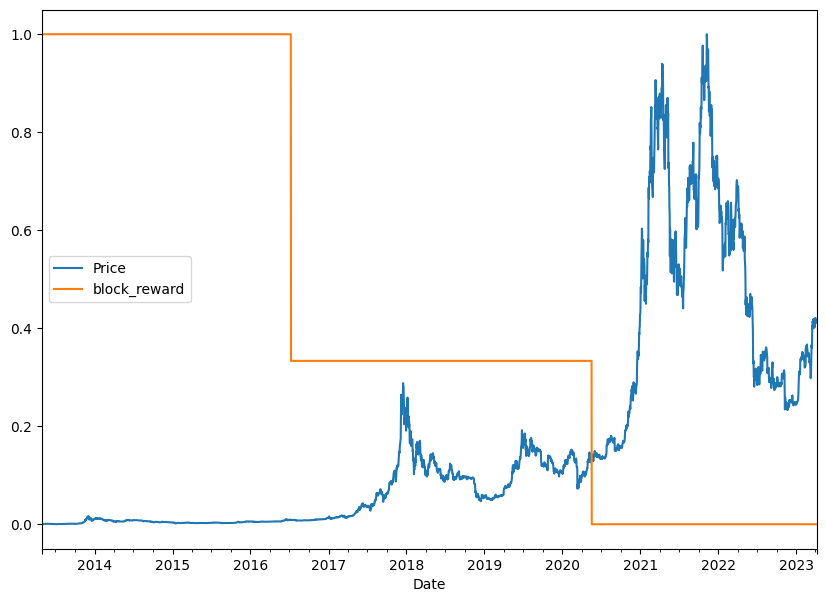

In [ ]:
# Plot the blcok_reward vs price overtime
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                    columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

## Making a windowed dataset with pandas

Previously I've turned the univariate time series into windowed dataset using the functions above.

However, since this is multivariate data, these functions won't work for this data. We can use from pandas library the shift() method.

In [ ]:
# Make a copy of the Bitcoin historical data with the block_reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-04-28,134.210007,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,144.539993,25,134.210007,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,139.000000,25,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN
2013-05-01,116.989998,25,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN
2013-05-02,105.209999,25,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN
2013-05-03,97.750000,25,105.209999,116.989998,139.000000,144.539993,134.210007,NaN,NaN
2013-05-04,112.500000,25,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007,NaN
2013-05-05,115.910004,25,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007
2013-05-06,112.300003,25,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993


In [ ]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2023-04-03,27790.220855,6.25,28199.308384,28462.943893,28478.484606,28033.563150,28348.442343,27268.131483,27139.888531
2023-04-04,28168.089816,6.25,27790.220855,28199.308384,28462.943893,28478.484606,28033.563150,28348.442343,27268.131483
2023-04-05,28177.983557,6.25,28168.089816,27790.220855,28199.308384,28462.943893,28478.484606,28033.563150,28348.442343
2023-04-06,28044.139755,6.25,28177.983557,28168.089816,27790.220855,28199.308384,28462.943893,28478.484606,28033.563150
2023-04-07,27925.859408,6.25,28044.139755,28177.983557,28168.089816,27790.220855,28199.308384,28462.943893,28478.484606


What I've done with the data is to create a way to window the dataset directly from a pandas DataFrame.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [ ]:
# Create X (windows) and y
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-05-05,25.0,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007
2013-05-06,25.0,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993
2013-05-07,25.0,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000
2013-05-08,25.0,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998
2013-05-09,25.0,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999


In [ ]:
y.head()

Date
2013-05-05    115.910004
2013-05-06    112.300003
2013-05-07    111.500000
2013-05-08    113.566002
2013-05-09    112.669998
Name: Price, dtype: float32

In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(3262, 3262, 363, 363)

## Model 6: Dense (multivariate time series)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile the model
model_6.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_6.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[create_model_checkpoint(model_name=model_6.name)]
)

Epoch 1/100
 1/26 [>.............................] - ETA: 11s - loss: 3460.0034 - mae: 3460.0034 - mse: 41931204.0000

26/26 [==============================] - 2s 61ms/step - loss: 915.4685 - mae: 915.4685 - mse: 5142752.5000 - val_loss: 1448.1388 - val_mae: 1448.1388 - val_mse: 3720197.2500
Epoch 2/100
 1/26 [>.............................] - ETA: 0s - loss: 471.8330 - mae: 471.8330 - mse: 1433225.2500

26/26 [==============================] - 0s 19ms/step - loss: 546.3315 - mae: 546.3315 - mse: 1631972.5000 - val_loss: 800.2697 - val_mae: 800.2697 - val_mse: 1550581.1250
Epoch 3/100
 1/26 [>.............................] - ETA: 0s - loss: 518.5475 - mae: 518.5475 - mse: 1280496.5000

26/26 [==============================] - 1s 22ms/step - loss: 455.0450 - mae: 455.0450 - mse: 1123842.5000 - val_loss: 714.5348 - val_mae: 714.5348 - val_mse: 1173782.2500
Epoch 4/100
 1/26 [>.............................] - ETA: 0s - loss: 314.6098 - mae: 314.6098 - mse: 592621.6250

26/26 [==============================] - 0s 20ms/step - loss: 414.5020 - mae: 414.5020 - mse: 951199.0000 - val_loss: 695.3218 - val_mae: 695.3218 - val_mse: 1124531.5000
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 397.8309 - mae: 397.8309 - mse: 877818.8125 - val_loss: 701.3179 - val_mae: 701.3179 - val_mse: 1107237.2500
Epoch 6/100
 1/26 [>.............................] - ETA: 0s - loss: 494.8415 - mae: 494.8415 - mse: 1177568.8750

26/26 [==============================] - 1s 23ms/step - loss: 397.2155 - mae: 397.2155 - mse: 887114.3125 - val_loss: 659.8456 - val_mae: 659.8456 - val_mse: 947764.5625
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 373.1123 - mae: 373.1123 - mse: 789979.1250 - val_loss: 674.8780 - val_mae: 674.8780 - val_mse: 1008373.6875
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 368.2397 - mae: 368.2397 - mse: 767928.5625 - val_loss: 662.5564 - val_mae: 662.5564 - val_mse: 962042.8125
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 353.2805 - mae: 353.2805 - mse: 709260.5625 - val_loss: 811.5916 - val_mae: 811.5916 - val_mse: 1251136.5000
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 375.9867 - mae: 375.9867 - mse: 786703.9375 - val_loss: 692.2879 - val_mae: 692.2879 - val_mse: 1002217.0625
Epoch 11/100
26/26 [==============================] - 0s 3ms/step - loss: 354.5785 - mae: 354.5785 - m

26/26 [==============================] - 1s 21ms/step - loss: 356.3799 - mae: 356.3799 - mse: 724003.3750 - val_loss: 595.7168 - val_mae: 595.7168 - val_mse: 801039.8750
Epoch 13/100
 1/26 [>.............................] - ETA: 0s - loss: 411.0944 - mae: 411.0944 - mse: 898063.0625

26/26 [==============================] - 1s 22ms/step - loss: 348.6786 - mae: 348.6786 - mse: 706215.3125 - val_loss: 590.9431 - val_mae: 590.9431 - val_mse: 760577.9375
Epoch 14/100
26/26 [==============================] - 0s 3ms/step - loss: 337.6562 - mae: 337.6562 - mse: 665177.3125 - val_loss: 641.9040 - val_mae: 641.9040 - val_mse: 882983.3125
Epoch 15/100
 1/26 [>.............................] - ETA: 0s - loss: 296.9617 - mae: 296.9617 - mse: 498591.3750

26/26 [==============================] - 1s 21ms/step - loss: 333.4982 - mae: 333.4982 - mse: 646463.1250 - val_loss: 575.5248 - val_mae: 575.5248 - val_mse: 750918.0000
Epoch 16/100
26/26 [==============================] - 0s 2ms/step - loss: 341.0924 - mae: 341.0924 - mse: 679671.1250 - val_loss: 683.2471 - val_mae: 683.2471 - val_mse: 949913.0625
Epoch 17/100
 1/26 [>.............................] - ETA: 0s - loss: 386.0082 - mae: 386.0082 - mse: 860272.2500

26/26 [==============================] - 1s 21ms/step - loss: 350.1538 - mae: 350.1538 - mse: 710366.1875 - val_loss: 568.1057 - val_mae: 568.1057 - val_mse: 733521.3750
Epoch 18/100
26/26 [==============================] - 0s 2ms/step - loss: 327.4641 - mae: 327.4641 - mse: 631703.4375 - val_loss: 653.4773 - val_mae: 653.4773 - val_mse: 885790.5000
Epoch 19/100
 1/26 [>.............................] - ETA: 0s - loss: 401.9604 - mae: 401.9604 - mse: 937870.6250

26/26 [==============================] - 1s 23ms/step - loss: 320.8138 - mae: 320.8138 - mse: 618269.3750 - val_loss: 557.6440 - val_mae: 557.6440 - val_mse: 695632.2500
Epoch 20/100
26/26 [==============================] - 0s 2ms/step - loss: 332.6539 - mae: 332.6539 - mse: 652435.7500 - val_loss: 606.3033 - val_mae: 606.3033 - val_mse: 796364.0625
Epoch 21/100
26/26 [==============================] - 0s 2ms/step - loss: 329.4343 - mae: 329.4343 - mse: 639528.8750 - val_loss: 706.8162 - val_mae: 706.8162 - val_mse: 975250.3125
Epoch 22/100
26/26 [==============================] - 0s 2ms/step - loss: 337.9199 - mae: 337.9199 - mse: 664573.1875 - val_loss: 595.5335 - val_mae: 595.5335 - val_mse: 773961.8750
Epoch 23/100
26/26 [==============================] - 0s 3ms/step - loss: 323.6389 - mae: 323.6389 - mse: 619037.3750 - val_loss: 679.4026 - val_mae: 679.4026 - val_mse: 840606.0625
Epoch 24/100
26/26 [==============================] - 0s 2ms/step - loss: 328.4717 - mae: 328.4717 - m

26/26 [==============================] - 1s 20ms/step - loss: 329.9715 - mae: 329.9715 - mse: 627421.0000 - val_loss: 553.8257 - val_mae: 553.8257 - val_mse: 699107.8125
Epoch 27/100
26/26 [==============================] - 0s 2ms/step - loss: 311.7310 - mae: 311.7310 - mse: 588039.4375 - val_loss: 596.1065 - val_mae: 596.1065 - val_mse: 768516.9375
Epoch 28/100
 1/26 [>.............................] - ETA: 0s - loss: 296.6363 - mae: 296.6363 - mse: 471495.6250

26/26 [==============================] - 1s 27ms/step - loss: 361.4413 - mae: 361.4413 - mse: 715695.2500 - val_loss: 551.4626 - val_mae: 551.4626 - val_mse: 695044.5625
Epoch 29/100
26/26 [==============================] - 0s 3ms/step - loss: 320.2520 - mae: 320.2520 - mse: 618884.5625 - val_loss: 567.2220 - val_mae: 567.2220 - val_mse: 681718.9375
Epoch 30/100
 1/26 [>.............................] - ETA: 0s - loss: 345.5105 - mae: 345.5105 - mse: 567372.8125

26/26 [==============================] - 1s 28ms/step - loss: 323.3128 - mae: 323.3128 - mse: 615438.8125 - val_loss: 532.0524 - val_mae: 532.0524 - val_mse: 657323.0625
Epoch 31/100
 1/26 [>.............................] - ETA: 0s - loss: 320.1130 - mae: 320.1130 - mse: 731712.5000

26/26 [==============================] - 1s 27ms/step - loss: 309.4400 - mae: 309.4400 - mse: 574645.3750 - val_loss: 529.8661 - val_mae: 529.8661 - val_mse: 650009.4375
Epoch 32/100
 1/26 [>.............................] - ETA: 0s - loss: 230.9255 - mae: 230.9255 - mse: 316030.1875

26/26 [==============================] - 1s 26ms/step - loss: 302.6902 - mae: 302.6902 - mse: 575923.5000 - val_loss: 528.0648 - val_mae: 528.0648 - val_mse: 646572.6250
Epoch 33/100
26/26 [==============================] - 0s 4ms/step - loss: 315.6633 - mae: 315.6633 - mse: 606366.1250 - val_loss: 559.8060 - val_mae: 559.8060 - val_mse: 703233.7500
Epoch 34/100
26/26 [==============================] - 0s 2ms/step - loss: 306.5998 - mae: 306.5998 - mse: 578741.3125 - val_loss: 568.4902 - val_mae: 568.4902 - val_mse: 717666.1875
Epoch 35/100
26/26 [==============================] - 0s 3ms/step - loss: 310.1800 - mae: 310.1800 - mse: 569800.1875 - val_loss: 530.8842 - val_mae: 530.8842 - val_mse: 654460.3125
Epoch 36/100
26/26 [==============================] - 0s 3ms/step - loss: 305.5074 - mae: 305.5074 - mse: 580412.2500 - val_loss: 588.8809 - val_mae: 588.8809 - val_mse: 749567.8125
Epoch 37/100
26/26 [==============================] - 0s 2ms/step - loss: 298.5016 - mae: 298.5016 - m

26/26 [==============================] - 1s 22ms/step - loss: 324.9244 - mae: 324.9244 - mse: 614517.7500 - val_loss: 522.5548 - val_mae: 522.5548 - val_mse: 629729.4375
Epoch 39/100
26/26 [==============================] - 0s 3ms/step - loss: 321.0539 - mae: 321.0539 - mse: 623942.0625 - val_loss: 793.2261 - val_mae: 793.2261 - val_mse: 1009918.7500
Epoch 40/100
 1/26 [>.............................] - ETA: 0s - loss: 406.1467 - mae: 406.1467 - mse: 867057.6250

26/26 [==============================] - 1s 21ms/step - loss: 307.6995 - mae: 307.6995 - mse: 567479.8125 - val_loss: 522.2252 - val_mae: 522.2252 - val_mse: 638865.3750
Epoch 41/100
26/26 [==============================] - 0s 2ms/step - loss: 299.7079 - mae: 299.7079 - mse: 561635.6875 - val_loss: 570.4062 - val_mae: 570.4062 - val_mse: 718574.9375
Epoch 42/100
26/26 [==============================] - 0s 3ms/step - loss: 312.0383 - mae: 312.0383 - mse: 594515.4375 - val_loss: 585.4276 - val_mae: 585.4276 - val_mse: 695093.0000
Epoch 43/100
26/26 [==============================] - 0s 3ms/step - loss: 334.3394 - mae: 334.3394 - mse: 646651.1875 - val_loss: 676.9783 - val_mae: 676.9783 - val_mse: 898388.8750
Epoch 44/100
26/26 [==============================] - 0s 3ms/step - loss: 306.7097 - mae: 306.7097 - mse: 583291.1875 - val_loss: 573.2108 - val_mae: 573.2108 - val_mse: 678988.3125
Epoch 45/100
26/26 [==============================] - 0s 3ms/step - loss: 323.2333 - mae: 323.2333 - m

26/26 [==============================] - 1s 39ms/step - loss: 308.0060 - mae: 308.0060 - mse: 573716.9375 - val_loss: 521.5432 - val_mae: 521.5432 - val_mse: 623445.9375
Epoch 61/100
26/26 [==============================] - 0s 3ms/step - loss: 309.1700 - mae: 309.1700 - mse: 564764.9375 - val_loss: 530.7164 - val_mae: 530.7164 - val_mse: 631732.1250
Epoch 62/100
 1/26 [>.............................] - ETA: 0s - loss: 318.4778 - mae: 318.4778 - mse: 616372.8125

26/26 [==============================] - 1s 22ms/step - loss: 298.2881 - mae: 298.2881 - mse: 560012.1875 - val_loss: 518.3796 - val_mae: 518.3796 - val_mse: 633805.2500
Epoch 63/100
26/26 [==============================] - 0s 2ms/step - loss: 298.3680 - mae: 298.3680 - mse: 535675.3750 - val_loss: 667.5176 - val_mae: 667.5176 - val_mse: 880289.9375
Epoch 64/100
26/26 [==============================] - 0s 2ms/step - loss: 304.0253 - mae: 304.0253 - mse: 571041.1875 - val_loss: 523.6097 - val_mae: 523.6097 - val_mse: 624799.9375
Epoch 65/100
26/26 [==============================] - 0s 3ms/step - loss: 294.9250 - mae: 294.9250 - mse: 553842.3750 - val_loss: 522.7426 - val_mae: 522.7426 - val_mse: 639990.1875
Epoch 66/100
26/26 [==============================] - 0s 3ms/step - loss: 324.1821 - mae: 324.1821 - mse: 636494.6875 - val_loss: 663.4916 - val_mae: 663.4916 - val_mse: 873958.1875
Epoch 67/100
 1/26 [>.............................] - ETA: 0s - loss: 346.4929 - mae: 346.4929 - mse: 

26/26 [==============================] - 1s 22ms/step - loss: 309.0663 - mae: 309.0663 - mse: 592776.2500 - val_loss: 517.5694 - val_mae: 517.5694 - val_mse: 622155.1250
Epoch 68/100
26/26 [==============================] - 0s 3ms/step - loss: 315.1708 - mae: 315.1708 - mse: 593967.3125 - val_loss: 759.7361 - val_mae: 759.7361 - val_mse: 947142.3750
Epoch 69/100
26/26 [==============================] - 0s 2ms/step - loss: 330.2051 - mae: 330.2051 - mse: 609288.1875 - val_loss: 592.0535 - val_mae: 592.0535 - val_mse: 700990.3750
Epoch 70/100
26/26 [==============================] - 0s 2ms/step - loss: 307.3380 - mae: 307.3380 - mse: 558985.0000 - val_loss: 533.0549 - val_mae: 533.0549 - val_mse: 656493.3125
Epoch 71/100
 1/26 [>.............................] - ETA: 0s - loss: 266.4966 - mae: 266.4966 - mse: 364502.0938

26/26 [==============================] - 1s 21ms/step - loss: 305.9162 - mae: 305.9162 - mse: 578239.1250 - val_loss: 516.7587 - val_mae: 516.7587 - val_mse: 625411.6875
Epoch 72/100
26/26 [==============================] - 0s 3ms/step - loss: 315.8237 - mae: 315.8237 - mse: 598244.1250 - val_loss: 576.3256 - val_mae: 576.3256 - val_mse: 682581.4375
Epoch 73/100
26/26 [==============================] - 0s 2ms/step - loss: 312.8477 - mae: 312.8477 - mse: 593522.2500 - val_loss: 605.7535 - val_mae: 605.7535 - val_mse: 774511.7500
Epoch 74/100
26/26 [==============================] - 0s 3ms/step - loss: 297.4134 - mae: 297.4134 - mse: 545938.5625 - val_loss: 546.4717 - val_mae: 546.4717 - val_mse: 646207.9375
Epoch 75/100
26/26 [==============================] - 0s 3ms/step - loss: 315.5602 - mae: 315.5602 - mse: 599249.0000 - val_loss: 520.9561 - val_mae: 520.9561 - val_mse: 621970.6250
Epoch 76/100
26/26 [==============================] - 0s 2ms/step - loss: 314.2610 - mae: 314.2610 - m

26/26 [==============================] - 1s 21ms/step - loss: 297.7354 - mae: 297.7354 - mse: 548813.4375 - val_loss: 514.9565 - val_mae: 514.9565 - val_mse: 628016.4375
Epoch 85/100
26/26 [==============================] - 0s 2ms/step - loss: 309.7018 - mae: 309.7018 - mse: 585759.2500 - val_loss: 546.4044 - val_mae: 546.4044 - val_mse: 683124.2500
Epoch 86/100
26/26 [==============================] - 0s 2ms/step - loss: 332.5468 - mae: 332.5468 - mse: 648875.7500 - val_loss: 516.7648 - val_mae: 516.7648 - val_mse: 640400.3125
Epoch 87/100
26/26 [==============================] - 0s 4ms/step - loss: 304.6026 - mae: 304.6026 - mse: 570976.6875 - val_loss: 524.6276 - val_mae: 524.6276 - val_mse: 634634.1250
Epoch 88/100
26/26 [==============================] - 0s 2ms/step - loss: 301.2216 - mae: 301.2216 - mse: 553866.5000 - val_loss: 515.3649 - val_mae: 515.3649 - val_mse: 631930.3750
Epoch 89/100
26/26 [==============================] - 0s 2ms/step - loss: 294.5697 - mae: 294.5697 - m

In [ ]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

12/12 [==============================] - 0s 2ms/step - loss: 515.7724 - mae: 515.7724 - mse: 622587.5625


[515.7723999023438, 515.7723999023438, 622587.5625]

In [ ]:
# Load in and evaluating the best peforming model
model_6 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

12/12 [==============================] - 0s 1ms/step - loss: 514.9567 - mae: 514.9567 - mse: 628016.5000


[514.9566650390625, 514.9566650390625, 628016.5]

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

12/12 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([42624.766, 42105.887, 39608.316, 39991.67 , 40836.72 , 39994.54 ,
       40455.6  , 40241.566, 39736.043, 40695.91 ], dtype=float32)>

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 514.956549694387,
 'mse': 628016.4008483755,
 'rmse': 792.4748581806085,
 'mape': 2.166600615684667,
 'mase': 1.0023725585659748}

In [ ]:
model_1_results

{'mae': 514.3972509476023,
 'mse': 619117.758227413,
 'rmse': 786.8403638778409,
 'mape': 2.161884110645021,
 'mase': 1.0012840192680927}

## Model 7: N-BEATS algorithm

I will try to replicate the following algorithm from the following paper: https://arxiv.org/pdf/1905.10437.pdf

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, I've got to create it.

To create custom layers and models in TensorFlow I will use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [ ]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Test the N-Beats layer by using some dummy inputs and outputs

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# There are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.20056215  0.3758043   0.11920279  0.43082842  0.5908094  -0.80088496
 -0.17794344]
Forecast: 0.3144152760505676


### Preparing data for the N-BEATS algorithm using `tf.data`

To make the input data load as fast as possible I need to be adhering to the performant data pipeline steps in the tf.data guide.

In [ ]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-04-28,134.210007
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=(i+1))
bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-04-28,134.210007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN,NaN
2013-05-01,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN,NaN
2013-05-02,105.209999,116.989998,139.000000,144.539993,134.210007,NaN,NaN,NaN
2013-05-03,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007,NaN,NaN
2013-05-04,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007,NaN
2013-05-05,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,134.210007
2013-05-06,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test stes
split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(3262, 3262, 363, 363)

In [ ]:
# Time to make the dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping togheter -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before I can craft the N-BEATS model, I need two layers for the residual connections (substract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture.

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

tensor_1, tensor_2

# Substract
subtracted = tf.keras.layers.subtract([tensor_1, tensor_2])

# Add
added = tf.keras.layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm
1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [ ]:
%%time

# Set the random seed
tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name="InitialBlock"
)

# 2. Create input to stack
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS - 1)): # first stack is already in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(
    train_dataset,
    epochs=N_EPOCHS,
    validation_data=test_dataset,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor="val_loss",
                  patience=200,
                  restore_best_weights=True
               ),
               tf.keras.callbacks.ReduceLROnPlateau(
                   monitor="val_loss",
                   patience=100,
                   verbose=1
               ),
               create_model_checkpoint(model_name=model_7.name)
    ]
)

Epoch 1/5000
4/4 [==============================] - ETA: 0s - loss: 104183.1094

4/4 [==============================] - 48s 8s/step - loss: 104183.1094 - val_loss: 10933.2158 - lr: 0.0010
Epoch 2/5000
4/4 [==============================] - ETA: 0s - loss: 7137.1343

4/4 [==============================] - 27s 8s/step - loss: 7137.1343 - val_loss: 5203.4927 - lr: 0.0010
Epoch 3/5000
4/4 [==============================] - 7s 2s/step - loss: 3947.7402 - val_loss: 21592.2207 - lr: 0.0010
Epoch 4/5000
4/4 [==============================] - 8s 2s/step - loss: 18806.6055 - val_loss: 41038.8906 - lr: 0.0010
Epoch 5/5000
4/4 [==============================] - 7s 2s/step - loss: 21569.4414 - val_loss: 21618.3984 - lr: 0.0010
Epoch 6/5000
4/4 [==============================] - 7s 2s/step - loss: 9597.9688 - val_loss: 20733.6289 - lr: 0.0010
Epoch 7/5000
4/4 [==============================] - 7s 2s/step - loss: 8352.4473 - val_loss: 15809.4600 - lr: 0.0010
Epoch 8/5000
4/4 [==============================] - ETA: 0s - loss: 3257.3262

4/4 [==============================] - 25s 8s/step - loss: 3257.3262 - val_loss: 2657.2205 - lr: 0.0010
Epoch 9/5000
4/4 [==============================] - 8s 2s/step - loss: 2006.9904 - val_loss: 10826.8730 - lr: 0.0010
Epoch 10/5000
4/4 [==============================] - ETA: 0s - loss: 14926.4648

4/4 [==============================] - 27s 8s/step - loss: 14926.4648 - val_loss: 2619.5920 - lr: 0.0010
Epoch 11/5000
4/4 [==============================] - 7s 2s/step - loss: 4584.7305 - val_loss: 12180.9805 - lr: 0.0010
Epoch 12/5000
4/4 [==============================] - 7s 2s/step - loss: 5272.1646 - val_loss: 8902.7354 - lr: 0.0010
Epoch 13/5000
4/4 [==============================] - ETA: 0s - loss: 2115.5432

4/4 [==============================] - 27s 8s/step - loss: 2115.5432 - val_loss: 1791.0702 - lr: 0.0010
Epoch 14/5000
4/4 [==============================] - 7s 2s/step - loss: 3255.7849 - val_loss: 7160.6421 - lr: 0.0010
Epoch 15/5000
4/4 [==============================] - 7s 2s/step - loss: 2234.1030 - val_loss: 2074.7759 - lr: 0.0010
Epoch 16/5000
4/4 [==============================] - 8s 2s/step - loss: 4879.0557 - val_loss: 3033.5588 - lr: 0.0010
Epoch 17/5000
4/4 [==============================] - 7s 2s/step - loss: 1134.5708 - val_loss: 2057.4558 - lr: 0.0010
Epoch 18/5000
4/4 [==============================] - ETA: 0s - loss: 601.9335

4/4 [==============================] - 27s 8s/step - loss: 601.9335 - val_loss: 1324.8284 - lr: 0.0010
Epoch 19/5000
4/4 [==============================] - ETA: 0s - loss: 1637.9635

4/4 [==============================] - 27s 8s/step - loss: 1637.9635 - val_loss: 962.4631 - lr: 0.0010
Epoch 20/5000
4/4 [==============================] - 7s 2s/step - loss: 1059.5594 - val_loss: 989.7468 - lr: 0.0010
Epoch 21/5000
4/4 [==============================] - 8s 2s/step - loss: 1231.8839 - val_loss: 1775.4858 - lr: 0.0010
Epoch 22/5000
4/4 [==============================] - 7s 2s/step - loss: 564.9744 - val_loss: 1202.3335 - lr: 0.0010
Epoch 23/5000
4/4 [==============================] - ETA: 0s - loss: 531.0612

4/4 [==============================] - 27s 8s/step - loss: 531.0612 - val_loss: 915.5659 - lr: 0.0010
Epoch 24/5000
4/4 [==============================] - ETA: 0s - loss: 616.3715

4/4 [==============================] - 27s 8s/step - loss: 616.3715 - val_loss: 909.2013 - lr: 0.0010
Epoch 25/5000
4/4 [==============================] - 7s 2s/step - loss: 659.5784 - val_loss: 1077.0209 - lr: 0.0010
Epoch 26/5000
4/4 [==============================] - 8s 2s/step - loss: 636.9802 - val_loss: 1039.9847 - lr: 0.0010
Epoch 27/5000
4/4 [==============================] - 8s 2s/step - loss: 523.7858 - val_loss: 990.2207 - lr: 0.0010
Epoch 28/5000
4/4 [==============================] - ETA: 0s - loss: 509.0277

4/4 [==============================] - 27s 8s/step - loss: 509.0277 - val_loss: 874.4745 - lr: 0.0010
Epoch 29/5000
4/4 [==============================] - 7s 2s/step - loss: 515.3271 - val_loss: 886.4545 - lr: 0.0010
Epoch 30/5000
4/4 [==============================] - ETA: 0s - loss: 508.1709

4/4 [==============================] - 28s 8s/step - loss: 508.1709 - val_loss: 853.1740 - lr: 0.0010
Epoch 31/5000
4/4 [==============================] - ETA: 0s - loss: 593.1542

4/4 [==============================] - 27s 8s/step - loss: 593.1542 - val_loss: 847.7620 - lr: 0.0010
Epoch 32/5000
4/4 [==============================] - 7s 2s/step - loss: 647.6055 - val_loss: 953.2932 - lr: 0.0010
Epoch 33/5000
4/4 [==============================] - 8s 2s/step - loss: 712.6786 - val_loss: 1063.1836 - lr: 0.0010
Epoch 34/5000
4/4 [==============================] - 7s 2s/step - loss: 535.0875 - val_loss: 1017.6653 - lr: 0.0010
Epoch 35/5000
4/4 [==============================] - ETA: 0s - loss: 519.7096

4/4 [==============================] - 26s 8s/step - loss: 519.7096 - val_loss: 830.2356 - lr: 0.0010
Epoch 36/5000
4/4 [==============================] - 7s 2s/step - loss: 496.8959 - val_loss: 833.7433 - lr: 0.0010
Epoch 37/5000
4/4 [==============================] - ETA: 0s - loss: 584.6259

4/4 [==============================] - 28s 8s/step - loss: 584.6259 - val_loss: 810.1389 - lr: 0.0010
Epoch 38/5000
4/4 [==============================] - 7s 2s/step - loss: 577.6411 - val_loss: 900.5360 - lr: 0.0010
Epoch 39/5000
4/4 [==============================] - ETA: 0s - loss: 598.2546

4/4 [==============================] - 28s 9s/step - loss: 598.2546 - val_loss: 802.0567 - lr: 0.0010
Epoch 40/5000
4/4 [==============================] - ETA: 0s - loss: 605.2979

4/4 [==============================] - 30s 9s/step - loss: 605.2979 - val_loss: 791.0446 - lr: 0.0010
Epoch 41/5000
4/4 [==============================] - 7s 2s/step - loss: 928.8472 - val_loss: 1069.8182 - lr: 0.0010
Epoch 42/5000
4/4 [==============================] - 8s 2s/step - loss: 704.0920 - val_loss: 872.0360 - lr: 0.0010
Epoch 43/5000
4/4 [==============================] - 7s 2s/step - loss: 807.5975 - val_loss: 1110.4005 - lr: 0.0010
Epoch 44/5000
4/4 [==============================] - 8s 2s/step - loss: 535.1525 - val_loss: 939.6814 - lr: 0.0010
Epoch 45/5000
4/4 [==============================] - 7s 2s/step - loss: 578.3604 - val_loss: 815.0428 - lr: 0.0010
Epoch 46/5000
4/4 [==============================] - ETA: 0s - loss: 742.4067

4/4 [==============================] - 27s 8s/step - loss: 742.4067 - val_loss: 774.1980 - lr: 0.0010
Epoch 47/5000
4/4 [==============================] - 7s 2s/step - loss: 1186.7588 - val_loss: 1753.5490 - lr: 0.0010
Epoch 48/5000
4/4 [==============================] - 7s 2s/step - loss: 503.0348 - val_loss: 1108.5914 - lr: 0.0010
Epoch 49/5000
4/4 [==============================] - 7s 2s/step - loss: 458.0697 - val_loss: 797.1772 - lr: 0.0010
Epoch 50/5000
4/4 [==============================] - 7s 2s/step - loss: 573.5407 - val_loss: 808.7765 - lr: 0.0010
Epoch 51/5000
4/4 [==============================] - 7s 2s/step - loss: 763.5356 - val_loss: 913.4547 - lr: 0.0010
Epoch 52/5000
4/4 [==============================] - 7s 2s/step - loss: 860.1619 - val_loss: 1385.1272 - lr: 0.0010
Epoch 53/5000
4/4 [==============================] - 7s 2s/step - loss: 486.2556 - val_loss: 1029.0951 - lr: 0.0010
Epoch 54/5000
4/4 [==============================] - ETA: 0s - loss: 443.0035

4/4 [==============================] - 27s 8s/step - loss: 443.0035 - val_loss: 764.4167 - lr: 0.0010
Epoch 55/5000
4/4 [==============================] - 7s 2s/step - loss: 453.3253 - val_loss: 781.1626 - lr: 0.0010
Epoch 56/5000
4/4 [==============================] - ETA: 0s - loss: 455.9647

4/4 [==============================] - 28s 9s/step - loss: 455.9647 - val_loss: 746.3786 - lr: 0.0010
Epoch 57/5000
4/4 [==============================] - ETA: 0s - loss: 587.5286

4/4 [==============================] - 28s 9s/step - loss: 587.5286 - val_loss: 742.7357 - lr: 0.0010
Epoch 58/5000
4/4 [==============================] - 7s 2s/step - loss: 653.5962 - val_loss: 908.5071 - lr: 0.0010
Epoch 59/5000
4/4 [==============================] - 8s 2s/step - loss: 719.4736 - val_loss: 1080.1116 - lr: 0.0010
Epoch 60/5000
4/4 [==============================] - 8s 2s/step - loss: 493.1122 - val_loss: 904.1269 - lr: 0.0010
Epoch 61/5000
4/4 [==============================] - ETA: 0s - loss: 499.8421

4/4 [==============================] - 26s 8s/step - loss: 499.8421 - val_loss: 742.6336 - lr: 0.0010
Epoch 62/5000
4/4 [==============================] - 7s 2s/step - loss: 491.9538 - val_loss: 769.5558 - lr: 0.0010
Epoch 63/5000
4/4 [==============================] - 8s 2s/step - loss: 598.7633 - val_loss: 767.6336 - lr: 0.0010
Epoch 64/5000
4/4 [==============================] - 7s 2s/step - loss: 584.2356 - val_loss: 861.4083 - lr: 0.0010
Epoch 65/5000
4/4 [==============================] - 7s 2s/step - loss: 659.9512 - val_loss: 910.5941 - lr: 0.0010
Epoch 66/5000
4/4 [==============================] - 8s 2s/step - loss: 529.5975 - val_loss: 864.2273 - lr: 0.0010
Epoch 67/5000
4/4 [==============================] - 7s 2s/step - loss: 580.1645 - val_loss: 788.8792 - lr: 0.0010
Epoch 68/5000
4/4 [==============================] - 7s 2s/step - loss: 530.5228 - val_loss: 804.1254 - lr: 0.0010
Epoch 69/5000
4/4 [==============================] - 7s 2s/step - loss: 640.1929 - val_loss: 

4/4 [==============================] - 29s 9s/step - loss: 580.4560 - val_loss: 733.7210 - lr: 0.0010
Epoch 77/5000
4/4 [==============================] - 8s 2s/step - loss: 819.5384 - val_loss: 825.0432 - lr: 0.0010
Epoch 78/5000
4/4 [==============================] - 7s 2s/step - loss: 647.6285 - val_loss: 909.3033 - lr: 0.0010
Epoch 79/5000
4/4 [==============================] - 7s 2s/step - loss: 634.5020 - val_loss: 784.0696 - lr: 0.0010
Epoch 80/5000
4/4 [==============================] - ETA: 0s - loss: 579.1531

4/4 [==============================] - 27s 8s/step - loss: 579.1531 - val_loss: 703.8608 - lr: 0.0010
Epoch 81/5000
4/4 [==============================] - 8s 2s/step - loss: 896.9605 - val_loss: 973.2802 - lr: 0.0010
Epoch 82/5000
4/4 [==============================] - 7s 2s/step - loss: 657.3983 - val_loss: 856.3167 - lr: 0.0010
Epoch 83/5000
4/4 [==============================] - 7s 2s/step - loss: 718.6239 - val_loss: 888.9890 - lr: 0.0010
Epoch 84/5000
4/4 [==============================] - 6s 2s/step - loss: 587.5455 - val_loss: 788.3695 - lr: 0.0010
Epoch 85/5000
4/4 [==============================] - 8s 2s/step - loss: 682.7679 - val_loss: 886.9249 - lr: 0.0010
Epoch 86/5000
4/4 [==============================] - 7s 2s/step - loss: 551.6139 - val_loss: 802.5352 - lr: 0.0010
Epoch 87/5000
4/4 [==============================] - 10s 2s/step - loss: 654.9415 - val_loss: 791.9489 - lr: 0.0010
Epoch 88/5000
4/4 [==============================] - 8s 2s/step - loss: 605.6671 - val_loss:

4/4 [==============================] - 27s 8s/step - loss: 647.1047 - val_loss: 688.2543 - lr: 0.0010
Epoch 128/5000
4/4 [==============================] - ETA: 0s - loss: 732.1268

4/4 [==============================] - 27s 8s/step - loss: 732.1268 - val_loss: 666.4157 - lr: 0.0010
Epoch 129/5000
4/4 [==============================] - 7s 2s/step - loss: 897.6753 - val_loss: 1459.7662 - lr: 0.0010
Epoch 130/5000
4/4 [==============================] - 7s 2s/step - loss: 421.9572 - val_loss: 820.7259 - lr: 0.0010
Epoch 131/5000
4/4 [==============================] - ETA: 0s - loss: 392.7859

4/4 [==============================] - 27s 8s/step - loss: 392.7859 - val_loss: 658.5632 - lr: 0.0010
Epoch 132/5000
4/4 [==============================] - 7s 2s/step - loss: 406.3243 - val_loss: 661.0110 - lr: 0.0010
Epoch 133/5000
4/4 [==============================] - 8s 2s/step - loss: 600.8043 - val_loss: 738.4296 - lr: 0.0010
Epoch 134/5000
4/4 [==============================] - 7s 2s/step - loss: 1087.2826 - val_loss: 1375.9020 - lr: 0.0010
Epoch 135/5000
4/4 [==============================] - 7s 2s/step - loss: 667.7878 - val_loss: 1133.2325 - lr: 0.0010
Epoch 136/5000
4/4 [==============================] - 8s 2s/step - loss: 408.0717 - val_loss: 695.3405 - lr: 0.0010
Epoch 137/5000
4/4 [==============================] - ETA: 0s - loss: 469.7891

4/4 [==============================] - 27s 8s/step - loss: 469.7891 - val_loss: 643.1536 - lr: 0.0010
Epoch 138/5000
4/4 [==============================] - 7s 2s/step - loss: 624.1782 - val_loss: 701.4099 - lr: 0.0010
Epoch 139/5000
4/4 [==============================] - 7s 2s/step - loss: 811.4451 - val_loss: 1266.9515 - lr: 0.0010
Epoch 140/5000
4/4 [==============================] - 7s 2s/step - loss: 425.1241 - val_loss: 767.2108 - lr: 0.0010
Epoch 141/5000
4/4 [==============================] - ETA: 0s - loss: 435.5443

4/4 [==============================] - 32s 10s/step - loss: 435.5443 - val_loss: 638.8792 - lr: 0.0010
Epoch 142/5000
4/4 [==============================] - 7s 2s/step - loss: 515.4460 - val_loss: 643.0390 - lr: 0.0010
Epoch 143/5000
4/4 [==============================] - 7s 2s/step - loss: 785.4043 - val_loss: 1132.5676 - lr: 0.0010
Epoch 144/5000
4/4 [==============================] - 7s 2s/step - loss: 452.4654 - val_loss: 795.0356 - lr: 0.0010
Epoch 145/5000
4/4 [==============================] - 7s 2s/step - loss: 458.1763 - val_loss: 640.1613 - lr: 0.0010
Epoch 146/5000
4/4 [==============================] - 7s 2s/step - loss: 522.5578 - val_loss: 655.6472 - lr: 0.0010
Epoch 147/5000
4/4 [==============================] - 7s 2s/step - loss: 744.7708 - val_loss: 1051.5802 - lr: 0.0010
Epoch 148/5000
4/4 [==============================] - 6s 2s/step - loss: 465.4608 - val_loss: 779.1235 - lr: 0.0010
Epoch 149/5000
4/4 [==============================] - 7s 2s/step - loss: 493.3696 -

4/4 [==============================] - 26s 8s/step - loss: 409.6931 - val_loss: 623.2637 - lr: 0.0010
Epoch 203/5000
4/4 [==============================] - 7s 2s/step - loss: 729.8618 - val_loss: 672.9773 - lr: 0.0010
Epoch 204/5000
4/4 [==============================] - 7s 2s/step - loss: 1377.7129 - val_loss: 1682.3595 - lr: 0.0010
Epoch 205/5000
4/4 [==============================] - 7s 2s/step - loss: 635.4161 - val_loss: 1032.9065 - lr: 0.0010
Epoch 206/5000
4/4 [==============================] - 7s 2s/step - loss: 423.5622 - val_loss: 666.3803 - lr: 0.0010
Epoch 207/5000
4/4 [==============================] - 7s 2s/step - loss: 550.3947 - val_loss: 633.5244 - lr: 0.0010
Epoch 208/5000
4/4 [==============================] - 7s 2s/step - loss: 645.3129 - val_loss: 754.9438 - lr: 0.0010
Epoch 209/5000
4/4 [==============================] - 7s 2s/step - loss: 737.2240 - val_loss: 1086.4829 - lr: 0.0010
Epoch 210/5000
4/4 [==============================] - 10s 2s/step - loss: 431.2564

4/4 [==============================] - 26s 8s/step - loss: 339.6087 - val_loss: 593.3624 - lr: 1.0000e-04
Epoch 304/5000
4/4 [==============================] - 7s 2s/step - loss: 343.2670 - val_loss: 602.0546 - lr: 1.0000e-04
Epoch 305/5000
4/4 [==============================] - 7s 2s/step - loss: 347.9453 - val_loss: 600.4621 - lr: 1.0000e-04
Epoch 306/5000
4/4 [==============================] - ETA: 0s - loss: 341.4827

4/4 [==============================] - 26s 8s/step - loss: 341.4827 - val_loss: 589.8770 - lr: 1.0000e-04
Epoch 307/5000
4/4 [==============================] - 7s 2s/step - loss: 336.4584 - val_loss: 598.4954 - lr: 1.0000e-04
Epoch 308/5000
4/4 [==============================] - 7s 2s/step - loss: 336.0571 - val_loss: 608.7184 - lr: 1.0000e-04
Epoch 309/5000
4/4 [==============================] - 7s 2s/step - loss: 335.6370 - val_loss: 603.6328 - lr: 1.0000e-04
Epoch 310/5000
4/4 [==============================] - 7s 2s/step - loss: 333.8080 - val_loss: 591.5175 - lr: 1.0000e-04
Epoch 311/5000
4/4 [==============================] - ETA: 0s - loss: 332.3996

4/4 [==============================] - 26s 8s/step - loss: 332.3996 - val_loss: 583.2745 - lr: 1.0000e-04
Epoch 312/5000
4/4 [==============================] - ETA: 0s - loss: 331.9043

4/4 [==============================] - 30s 9s/step - loss: 331.9043 - val_loss: 580.4477 - lr: 1.0000e-04
Epoch 313/5000
4/4 [==============================] - ETA: 0s - loss: 330.8733

4/4 [==============================] - 28s 8s/step - loss: 330.8733 - val_loss: 579.0280 - lr: 1.0000e-04
Epoch 314/5000
4/4 [==============================] - 7s 2s/step - loss: 329.2601 - val_loss: 579.1458 - lr: 1.0000e-04
Epoch 315/5000
4/4 [==============================] - 7s 2s/step - loss: 328.0663 - val_loss: 579.4741 - lr: 1.0000e-04
Epoch 316/5000
4/4 [==============================] - ETA: 0s - loss: 327.1438

4/4 [==============================] - 26s 8s/step - loss: 327.1438 - val_loss: 578.9078 - lr: 1.0000e-04
Epoch 317/5000
4/4 [==============================] - ETA: 0s - loss: 326.2972

4/4 [==============================] - 26s 8s/step - loss: 326.2972 - val_loss: 577.2695 - lr: 1.0000e-04
Epoch 318/5000
4/4 [==============================] - ETA: 0s - loss: 325.4787

4/4 [==============================] - 25s 8s/step - loss: 325.4787 - val_loss: 574.8902 - lr: 1.0000e-04
Epoch 319/5000
4/4 [==============================] - ETA: 0s - loss: 324.6969

4/4 [==============================] - 26s 8s/step - loss: 324.6969 - val_loss: 572.7617 - lr: 1.0000e-04
Epoch 320/5000
4/4 [==============================] - ETA: 0s - loss: 324.0077

4/4 [==============================] - 26s 8s/step - loss: 324.0077 - val_loss: 571.4065 - lr: 1.0000e-04
Epoch 321/5000
4/4 [==============================] - ETA: 0s - loss: 323.3622

4/4 [==============================] - 25s 8s/step - loss: 323.3622 - val_loss: 570.7396 - lr: 1.0000e-04
Epoch 322/5000
4/4 [==============================] - ETA: 0s - loss: 322.7846

4/4 [==============================] - 26s 8s/step - loss: 322.7846 - val_loss: 570.7233 - lr: 1.0000e-04
Epoch 323/5000
4/4 [==============================] - ETA: 0s - loss: 322.2961

4/4 [==============================] - 25s 8s/step - loss: 322.2961 - val_loss: 570.6592 - lr: 1.0000e-04
Epoch 324/5000
4/4 [==============================] - ETA: 0s - loss: 321.8240

4/4 [==============================] - 28s 9s/step - loss: 321.8240 - val_loss: 569.6839 - lr: 1.0000e-04
Epoch 325/5000
4/4 [==============================] - ETA: 0s - loss: 321.3518

4/4 [==============================] - 27s 8s/step - loss: 321.3518 - val_loss: 568.4671 - lr: 1.0000e-04
Epoch 326/5000
4/4 [==============================] - ETA: 0s - loss: 320.9452

4/4 [==============================] - 28s 8s/step - loss: 320.9452 - val_loss: 567.5545 - lr: 1.0000e-04
Epoch 327/5000
4/4 [==============================] - ETA: 0s - loss: 320.5947

4/4 [==============================] - 26s 8s/step - loss: 320.5947 - val_loss: 567.3058 - lr: 1.0000e-04
Epoch 328/5000
4/4 [==============================] - 7s 2s/step - loss: 320.2170 - val_loss: 567.5951 - lr: 1.0000e-04
Epoch 329/5000
4/4 [==============================] - 7s 2s/step - loss: 319.8960 - val_loss: 567.6189 - lr: 1.0000e-04
Epoch 330/5000
4/4 [==============================] - ETA: 0s - loss: 319.6187

4/4 [==============================] - 26s 8s/step - loss: 319.6187 - val_loss: 567.3044 - lr: 1.0000e-04
Epoch 331/5000
4/4 [==============================] - ETA: 0s - loss: 319.3516

4/4 [==============================] - 26s 8s/step - loss: 319.3516 - val_loss: 566.8384 - lr: 1.0000e-04
Epoch 332/5000
4/4 [==============================] - ETA: 0s - loss: 319.0944

4/4 [==============================] - 31s 10s/step - loss: 319.0944 - val_loss: 566.2842 - lr: 1.0000e-04
Epoch 333/5000
4/4 [==============================] - ETA: 0s - loss: 318.8434

4/4 [==============================] - 27s 8s/step - loss: 318.8434 - val_loss: 565.7272 - lr: 1.0000e-04
Epoch 334/5000
4/4 [==============================] - ETA: 0s - loss: 318.6051

4/4 [==============================] - 27s 8s/step - loss: 318.6051 - val_loss: 565.3094 - lr: 1.0000e-04
Epoch 335/5000
4/4 [==============================] - ETA: 0s - loss: 318.3723

4/4 [==============================] - 27s 8s/step - loss: 318.3723 - val_loss: 564.9345 - lr: 1.0000e-04
Epoch 336/5000
4/4 [==============================] - ETA: 0s - loss: 318.1205

4/4 [==============================] - 27s 8s/step - loss: 318.1205 - val_loss: 564.5734 - lr: 1.0000e-04
Epoch 337/5000
4/4 [==============================] - ETA: 0s - loss: 317.8732

4/4 [==============================] - 26s 8s/step - loss: 317.8732 - val_loss: 564.3622 - lr: 1.0000e-04
Epoch 338/5000
4/4 [==============================] - 7s 2s/step - loss: 317.6445 - val_loss: 564.3923 - lr: 1.0000e-04
Epoch 339/5000
4/4 [==============================] - ETA: 0s - loss: 317.4410

4/4 [==============================] - 26s 8s/step - loss: 317.4410 - val_loss: 564.2908 - lr: 1.0000e-04
Epoch 340/5000
4/4 [==============================] - ETA: 0s - loss: 317.2485

4/4 [==============================] - 26s 8s/step - loss: 317.2485 - val_loss: 564.2286 - lr: 1.0000e-04
Epoch 341/5000
4/4 [==============================] - ETA: 0s - loss: 317.0312

4/4 [==============================] - 26s 8s/step - loss: 317.0312 - val_loss: 563.9186 - lr: 1.0000e-04
Epoch 342/5000
4/4 [==============================] - ETA: 0s - loss: 316.8146

4/4 [==============================] - 27s 8s/step - loss: 316.8146 - val_loss: 563.8072 - lr: 1.0000e-04
Epoch 343/5000
4/4 [==============================] - 7s 2s/step - loss: 316.6175 - val_loss: 563.8413 - lr: 1.0000e-04
Epoch 344/5000
4/4 [==============================] - ETA: 0s - loss: 316.4491

4/4 [==============================] - 26s 8s/step - loss: 316.4491 - val_loss: 563.7026 - lr: 1.0000e-04
Epoch 345/5000
4/4 [==============================] - ETA: 0s - loss: 316.2482

4/4 [==============================] - 27s 8s/step - loss: 316.2482 - val_loss: 563.1757 - lr: 1.0000e-04
Epoch 346/5000
4/4 [==============================] - ETA: 0s - loss: 316.0410

4/4 [==============================] - 29s 9s/step - loss: 316.0410 - val_loss: 562.7714 - lr: 1.0000e-04
Epoch 347/5000
4/4 [==============================] - ETA: 0s - loss: 315.8404

4/4 [==============================] - 27s 8s/step - loss: 315.8404 - val_loss: 562.5019 - lr: 1.0000e-04
Epoch 348/5000
4/4 [==============================] - ETA: 0s - loss: 315.6506

4/4 [==============================] - 26s 8s/step - loss: 315.6506 - val_loss: 562.3781 - lr: 1.0000e-04
Epoch 349/5000
4/4 [==============================] - ETA: 0s - loss: 315.4696

4/4 [==============================] - 27s 8s/step - loss: 315.4696 - val_loss: 562.1156 - lr: 1.0000e-04
Epoch 350/5000
4/4 [==============================] - ETA: 0s - loss: 315.2963

4/4 [==============================] - 27s 8s/step - loss: 315.2963 - val_loss: 561.7167 - lr: 1.0000e-04
Epoch 351/5000
4/4 [==============================] - ETA: 0s - loss: 315.1198

4/4 [==============================] - 28s 9s/step - loss: 315.1198 - val_loss: 561.5826 - lr: 1.0000e-04
Epoch 352/5000
4/4 [==============================] - ETA: 0s - loss: 314.9614

4/4 [==============================] - 31s 10s/step - loss: 314.9614 - val_loss: 561.3079 - lr: 1.0000e-04
Epoch 353/5000
4/4 [==============================] - ETA: 0s - loss: 314.8035

4/4 [==============================] - 27s 8s/step - loss: 314.8035 - val_loss: 561.1348 - lr: 1.0000e-04
Epoch 354/5000
4/4 [==============================] - ETA: 0s - loss: 314.6602

4/4 [==============================] - 28s 8s/step - loss: 314.6602 - val_loss: 560.4963 - lr: 1.0000e-04
Epoch 355/5000
4/4 [==============================] - ETA: 0s - loss: 314.5164

4/4 [==============================] - 26s 8s/step - loss: 314.5164 - val_loss: 560.2578 - lr: 1.0000e-04
Epoch 356/5000
4/4 [==============================] - ETA: 0s - loss: 314.3608

4/4 [==============================] - 27s 8s/step - loss: 314.3608 - val_loss: 560.1335 - lr: 1.0000e-04
Epoch 357/5000
4/4 [==============================] - ETA: 0s - loss: 314.2224

4/4 [==============================] - 27s 8s/step - loss: 314.2224 - val_loss: 559.7803 - lr: 1.0000e-04
Epoch 358/5000
4/4 [==============================] - ETA: 0s - loss: 314.0919

4/4 [==============================] - 27s 8s/step - loss: 314.0919 - val_loss: 559.4065 - lr: 1.0000e-04
Epoch 359/5000
4/4 [==============================] - ETA: 0s - loss: 313.9440

4/4 [==============================] - 26s 8s/step - loss: 313.9440 - val_loss: 559.2184 - lr: 1.0000e-04
Epoch 360/5000
4/4 [==============================] - ETA: 0s - loss: 313.8083

4/4 [==============================] - 26s 8s/step - loss: 313.8083 - val_loss: 558.9763 - lr: 1.0000e-04
Epoch 361/5000
4/4 [==============================] - ETA: 0s - loss: 313.6670

4/4 [==============================] - 28s 9s/step - loss: 313.6670 - val_loss: 558.8701 - lr: 1.0000e-04
Epoch 362/5000
4/4 [==============================] - ETA: 0s - loss: 313.5287

4/4 [==============================] - 28s 8s/step - loss: 313.5287 - val_loss: 558.4590 - lr: 1.0000e-04
Epoch 363/5000
4/4 [==============================] - ETA: 0s - loss: 313.3997

4/4 [==============================] - 26s 8s/step - loss: 313.3997 - val_loss: 558.0744 - lr: 1.0000e-04
Epoch 364/5000
4/4 [==============================] - 7s 2s/step - loss: 313.2488 - val_loss: 558.1230 - lr: 1.0000e-04
Epoch 365/5000
4/4 [==============================] - 7s 2s/step - loss: 313.0934 - val_loss: 558.1257 - lr: 1.0000e-04
Epoch 366/5000
4/4 [==============================] - ETA: 0s - loss: 312.9557

4/4 [==============================] - 26s 8s/step - loss: 312.9557 - val_loss: 557.4199 - lr: 1.0000e-04
Epoch 367/5000
4/4 [==============================] - ETA: 0s - loss: 312.8462

4/4 [==============================] - 26s 8s/step - loss: 312.8462 - val_loss: 557.0251 - lr: 1.0000e-04
Epoch 368/5000
4/4 [==============================] - 7s 2s/step - loss: 312.6904 - val_loss: 557.1924 - lr: 1.0000e-04
Epoch 369/5000
4/4 [==============================] - 8s 2s/step - loss: 312.5075 - val_loss: 557.4322 - lr: 1.0000e-04
Epoch 370/5000
4/4 [==============================] - ETA: 0s - loss: 312.3612

4/4 [==============================] - 26s 8s/step - loss: 312.3612 - val_loss: 556.9692 - lr: 1.0000e-04
Epoch 371/5000
4/4 [==============================] - ETA: 0s - loss: 312.2271

4/4 [==============================] - 27s 8s/step - loss: 312.2271 - val_loss: 556.5661 - lr: 1.0000e-04
Epoch 372/5000
4/4 [==============================] - ETA: 0s - loss: 312.0987

4/4 [==============================] - 27s 8s/step - loss: 312.0987 - val_loss: 556.5239 - lr: 1.0000e-04
Epoch 373/5000
4/4 [==============================] - 7s 2s/step - loss: 311.9190 - val_loss: 556.9683 - lr: 1.0000e-04
Epoch 374/5000
4/4 [==============================] - ETA: 0s - loss: 311.7729

4/4 [==============================] - 26s 8s/step - loss: 311.7729 - val_loss: 556.3267 - lr: 1.0000e-04
Epoch 375/5000
4/4 [==============================] - ETA: 0s - loss: 311.6939

4/4 [==============================] - 27s 8s/step - loss: 311.6939 - val_loss: 555.8696 - lr: 1.0000e-04
Epoch 376/5000
4/4 [==============================] - 7s 2s/step - loss: 311.4896 - val_loss: 556.2766 - lr: 1.0000e-04
Epoch 377/5000
4/4 [==============================] - 7s 2s/step - loss: 311.3468 - val_loss: 555.8799 - lr: 1.0000e-04
Epoch 378/5000
4/4 [==============================] - ETA: 0s - loss: 311.2221

4/4 [==============================] - 26s 8s/step - loss: 311.2221 - val_loss: 555.7020 - lr: 1.0000e-04
Epoch 379/5000
4/4 [==============================] - 7s 2s/step - loss: 311.0545 - val_loss: 555.8677 - lr: 1.0000e-04
Epoch 380/5000
4/4 [==============================] - ETA: 0s - loss: 310.9229

4/4 [==============================] - 26s 8s/step - loss: 310.9229 - val_loss: 555.5009 - lr: 1.0000e-04
Epoch 381/5000
4/4 [==============================] - 7s 2s/step - loss: 310.7745 - val_loss: 555.5955 - lr: 1.0000e-04
Epoch 382/5000
4/4 [==============================] - ETA: 0s - loss: 310.6435

4/4 [==============================] - 27s 8s/step - loss: 310.6435 - val_loss: 555.2927 - lr: 1.0000e-04
Epoch 383/5000
4/4 [==============================] - ETA: 0s - loss: 310.5091

4/4 [==============================] - 27s 8s/step - loss: 310.5091 - val_loss: 555.0776 - lr: 1.0000e-04
Epoch 384/5000
4/4 [==============================] - ETA: 0s - loss: 310.3798

4/4 [==============================] - 26s 8s/step - loss: 310.3798 - val_loss: 554.9033 - lr: 1.0000e-04
Epoch 385/5000
4/4 [==============================] - ETA: 0s - loss: 310.2483

4/4 [==============================] - 26s 8s/step - loss: 310.2483 - val_loss: 554.6995 - lr: 1.0000e-04
Epoch 386/5000
4/4 [==============================] - ETA: 0s - loss: 310.1116

4/4 [==============================] - 26s 8s/step - loss: 310.1116 - val_loss: 554.5148 - lr: 1.0000e-04
Epoch 387/5000
4/4 [==============================] - ETA: 0s - loss: 309.9714

4/4 [==============================] - 27s 8s/step - loss: 309.9714 - val_loss: 554.3806 - lr: 1.0000e-04
Epoch 388/5000
4/4 [==============================] - ETA: 0s - loss: 309.8356

4/4 [==============================] - 26s 8s/step - loss: 309.8356 - val_loss: 554.3109 - lr: 1.0000e-04
Epoch 389/5000
4/4 [==============================] - ETA: 0s - loss: 309.7069

4/4 [==============================] - 26s 8s/step - loss: 309.7069 - val_loss: 554.2524 - lr: 1.0000e-04
Epoch 390/5000
4/4 [==============================] - ETA: 0s - loss: 309.5753

4/4 [==============================] - 27s 8s/step - loss: 309.5753 - val_loss: 554.1435 - lr: 1.0000e-04
Epoch 391/5000
4/4 [==============================] - ETA: 0s - loss: 309.4478

4/4 [==============================] - 27s 8s/step - loss: 309.4478 - val_loss: 553.9479 - lr: 1.0000e-04
Epoch 392/5000
4/4 [==============================] - ETA: 0s - loss: 309.3187

4/4 [==============================] - 27s 8s/step - loss: 309.3187 - val_loss: 553.6897 - lr: 1.0000e-04
Epoch 393/5000
4/4 [==============================] - ETA: 0s - loss: 309.1903

4/4 [==============================] - 25s 8s/step - loss: 309.1903 - val_loss: 553.3978 - lr: 1.0000e-04
Epoch 394/5000
4/4 [==============================] - ETA: 0s - loss: 309.0644

4/4 [==============================] - 27s 8s/step - loss: 309.0644 - val_loss: 553.0815 - lr: 1.0000e-04
Epoch 395/5000
4/4 [==============================] - ETA: 0s - loss: 308.9327

4/4 [==============================] - 31s 10s/step - loss: 308.9327 - val_loss: 552.7202 - lr: 1.0000e-04
Epoch 396/5000
4/4 [==============================] - ETA: 0s - loss: 308.7946

4/4 [==============================] - 27s 8s/step - loss: 308.7946 - val_loss: 552.3967 - lr: 1.0000e-04
Epoch 397/5000
4/4 [==============================] - ETA: 0s - loss: 308.6537

4/4 [==============================] - 27s 8s/step - loss: 308.6537 - val_loss: 552.1220 - lr: 1.0000e-04
Epoch 398/5000
4/4 [==============================] - ETA: 0s - loss: 308.5136

4/4 [==============================] - 26s 8s/step - loss: 308.5136 - val_loss: 551.9528 - lr: 1.0000e-04
Epoch 399/5000
4/4 [==============================] - ETA: 0s - loss: 308.3870

4/4 [==============================] - 26s 8s/step - loss: 308.3870 - val_loss: 551.6390 - lr: 1.0000e-04
Epoch 400/5000
4/4 [==============================] - ETA: 0s - loss: 308.2901

4/4 [==============================] - 27s 8s/step - loss: 308.2901 - val_loss: 551.3297 - lr: 1.0000e-04
Epoch 401/5000
4/4 [==============================] - 7s 2s/step - loss: 308.1537 - val_loss: 551.7496 - lr: 1.0000e-04
Epoch 402/5000
4/4 [==============================] - ETA: 0s - loss: 308.0311

4/4 [==============================] - 26s 8s/step - loss: 308.0311 - val_loss: 550.7473 - lr: 1.0000e-04
Epoch 403/5000
4/4 [==============================] - ETA: 0s - loss: 307.9253

4/4 [==============================] - 26s 8s/step - loss: 307.9253 - val_loss: 550.6640 - lr: 1.0000e-04
Epoch 404/5000
4/4 [==============================] - 7s 2s/step - loss: 307.8140 - val_loss: 551.2851 - lr: 1.0000e-04
Epoch 405/5000
4/4 [==============================] - ETA: 0s - loss: 307.7169

4/4 [==============================] - 26s 8s/step - loss: 307.7169 - val_loss: 550.4951 - lr: 1.0000e-04
Epoch 406/5000
4/4 [==============================] - ETA: 0s - loss: 307.5999

4/4 [==============================] - 27s 8s/step - loss: 307.5999 - val_loss: 549.8759 - lr: 1.0000e-04
Epoch 407/5000
4/4 [==============================] - ETA: 0s - loss: 307.4895

4/4 [==============================] - 27s 8s/step - loss: 307.4895 - val_loss: 549.8250 - lr: 1.0000e-04
Epoch 408/5000
4/4 [==============================] - 7s 2s/step - loss: 307.3663 - val_loss: 550.0908 - lr: 1.0000e-04
Epoch 409/5000
4/4 [==============================] - 7s 2s/step - loss: 307.2690 - val_loss: 549.9609 - lr: 1.0000e-04
Epoch 410/5000
4/4 [==============================] - ETA: 0s - loss: 307.1691

4/4 [==============================] - 26s 8s/step - loss: 307.1691 - val_loss: 549.2479 - lr: 1.0000e-04
Epoch 411/5000
4/4 [==============================] - ETA: 0s - loss: 307.0706

4/4 [==============================] - 26s 8s/step - loss: 307.0706 - val_loss: 549.1747 - lr: 1.0000e-04
Epoch 412/5000
4/4 [==============================] - 7s 2s/step - loss: 306.9523 - val_loss: 549.5001 - lr: 1.0000e-04
Epoch 413/5000
4/4 [==============================] - 7s 2s/step - loss: 306.8706 - val_loss: 549.3706 - lr: 1.0000e-04
Epoch 414/5000
4/4 [==============================] - ETA: 0s - loss: 306.7686

4/4 [==============================] - 27s 8s/step - loss: 306.7686 - val_loss: 548.5991 - lr: 1.0000e-04
Epoch 415/5000
4/4 [==============================] - ETA: 0s - loss: 306.6680

4/4 [==============================] - 27s 8s/step - loss: 306.6680 - val_loss: 548.4888 - lr: 1.0000e-04
Epoch 416/5000
4/4 [==============================] - 8s 2s/step - loss: 306.5373 - val_loss: 548.8423 - lr: 1.0000e-04
Epoch 417/5000
4/4 [==============================] - 7s 2s/step - loss: 306.4591 - val_loss: 548.8383 - lr: 1.0000e-04
Epoch 418/5000
4/4 [==============================] - ETA: 0s - loss: 306.3464

4/4 [==============================] - 27s 8s/step - loss: 306.3464 - val_loss: 548.1087 - lr: 1.0000e-04
Epoch 419/5000
4/4 [==============================] - ETA: 0s - loss: 306.2446

4/4 [==============================] - 31s 10s/step - loss: 306.2446 - val_loss: 547.9535 - lr: 1.0000e-04
Epoch 420/5000
4/4 [==============================] - ETA: 0s - loss: 306.1168

4/4 [==============================] - 27s 8s/step - loss: 306.1168 - val_loss: 547.8828 - lr: 1.0000e-04
Epoch 421/5000
4/4 [==============================] - ETA: 0s - loss: 306.0154

4/4 [==============================] - 28s 8s/step - loss: 306.0154 - val_loss: 547.6685 - lr: 1.0000e-04
Epoch 422/5000
4/4 [==============================] - ETA: 0s - loss: 305.9040

4/4 [==============================] - 28s 9s/step - loss: 305.9040 - val_loss: 547.5870 - lr: 1.0000e-04
Epoch 423/5000
4/4 [==============================] - ETA: 0s - loss: 305.7993

4/4 [==============================] - 27s 8s/step - loss: 305.7993 - val_loss: 547.3051 - lr: 1.0000e-04
Epoch 424/5000
4/4 [==============================] - ETA: 0s - loss: 305.6849

4/4 [==============================] - 27s 8s/step - loss: 305.6849 - val_loss: 547.1248 - lr: 1.0000e-04
Epoch 425/5000
4/4 [==============================] - ETA: 0s - loss: 305.5787

4/4 [==============================] - 27s 8s/step - loss: 305.5787 - val_loss: 546.9204 - lr: 1.0000e-04
Epoch 426/5000
4/4 [==============================] - 7s 2s/step - loss: 305.4713 - val_loss: 547.1321 - lr: 1.0000e-04
Epoch 427/5000
4/4 [==============================] - ETA: 0s - loss: 305.3771

4/4 [==============================] - 27s 8s/step - loss: 305.3771 - val_loss: 546.7240 - lr: 1.0000e-04
Epoch 428/5000
4/4 [==============================] - ETA: 0s - loss: 305.2778

4/4 [==============================] - 26s 8s/step - loss: 305.2778 - val_loss: 546.3937 - lr: 1.0000e-04
Epoch 429/5000
4/4 [==============================] - 7s 2s/step - loss: 305.1551 - val_loss: 546.5214 - lr: 1.0000e-04
Epoch 430/5000
4/4 [==============================] - ETA: 0s - loss: 305.0443

4/4 [==============================] - 26s 8s/step - loss: 305.0443 - val_loss: 546.0761 - lr: 1.0000e-04
Epoch 431/5000
4/4 [==============================] - 7s 2s/step - loss: 304.9547 - val_loss: 546.1122 - lr: 1.0000e-04
Epoch 432/5000
4/4 [==============================] - 7s 2s/step - loss: 304.9384 - val_loss: 547.5141 - lr: 1.0000e-04
Epoch 433/5000
4/4 [==============================] - ETA: 0s - loss: 304.7852

4/4 [==============================] - 26s 8s/step - loss: 304.7852 - val_loss: 545.9133 - lr: 1.0000e-04
Epoch 434/5000
4/4 [==============================] - ETA: 0s - loss: 304.6052

4/4 [==============================] - 27s 8s/step - loss: 304.6052 - val_loss: 545.2977 - lr: 1.0000e-04
Epoch 435/5000
4/4 [==============================] - 7s 2s/step - loss: 304.4628 - val_loss: 545.8416 - lr: 1.0000e-04
Epoch 436/5000
4/4 [==============================] - 7s 2s/step - loss: 304.3690 - val_loss: 545.4425 - lr: 1.0000e-04
Epoch 437/5000
4/4 [==============================] - ETA: 0s - loss: 304.2531

4/4 [==============================] - 26s 8s/step - loss: 304.2531 - val_loss: 544.9210 - lr: 1.0000e-04
Epoch 438/5000
4/4 [==============================] - 7s 2s/step - loss: 304.1355 - val_loss: 544.9355 - lr: 1.0000e-04
Epoch 439/5000
4/4 [==============================] - ETA: 0s - loss: 304.0329

4/4 [==============================] - 27s 8s/step - loss: 304.0329 - val_loss: 544.4490 - lr: 1.0000e-04
Epoch 440/5000
4/4 [==============================] - ETA: 0s - loss: 303.9562

4/4 [==============================] - 27s 8s/step - loss: 303.9562 - val_loss: 544.1634 - lr: 1.0000e-04
Epoch 441/5000
4/4 [==============================] - 7s 2s/step - loss: 303.8082 - val_loss: 544.4905 - lr: 1.0000e-04
Epoch 442/5000
4/4 [==============================] - 8s 2s/step - loss: 303.6977 - val_loss: 544.2819 - lr: 1.0000e-04
Epoch 443/5000
4/4 [==============================] - ETA: 0s - loss: 303.5850

4/4 [==============================] - 26s 8s/step - loss: 303.5850 - val_loss: 543.7964 - lr: 1.0000e-04
Epoch 444/5000
4/4 [==============================] - ETA: 0s - loss: 303.5342

4/4 [==============================] - 32s 10s/step - loss: 303.5342 - val_loss: 543.2601 - lr: 1.0000e-04
Epoch 445/5000
4/4 [==============================] - 8s 2s/step - loss: 303.3159 - val_loss: 544.0078 - lr: 1.0000e-04
Epoch 446/5000
4/4 [==============================] - 7s 2s/step - loss: 303.2240 - val_loss: 543.6530 - lr: 1.0000e-04
Epoch 447/5000
4/4 [==============================] - ETA: 0s - loss: 303.1407

4/4 [==============================] - 26s 8s/step - loss: 303.1407 - val_loss: 543.0397 - lr: 1.0000e-04
Epoch 448/5000
4/4 [==============================] - 7s 2s/step - loss: 302.9625 - val_loss: 543.9840 - lr: 1.0000e-04
Epoch 449/5000
4/4 [==============================] - 7s 2s/step - loss: 302.8989 - val_loss: 543.5480 - lr: 1.0000e-04
Epoch 450/5000
4/4 [==============================] - ETA: 0s - loss: 302.7578

4/4 [==============================] - 27s 8s/step - loss: 302.7578 - val_loss: 542.6252 - lr: 1.0000e-04
Epoch 451/5000
4/4 [==============================] - 7s 2s/step - loss: 302.5888 - val_loss: 543.1851 - lr: 1.0000e-04
Epoch 452/5000
4/4 [==============================] - 8s 2s/step - loss: 302.4783 - val_loss: 543.5538 - lr: 1.0000e-04
Epoch 453/5000
4/4 [==============================] - 8s 2s/step - loss: 302.3406 - val_loss: 542.8444 - lr: 1.0000e-04
Epoch 454/5000
4/4 [==============================] - ETA: 0s - loss: 302.2253

4/4 [==============================] - 27s 8s/step - loss: 302.2253 - val_loss: 542.4703 - lr: 1.0000e-04
Epoch 455/5000
4/4 [==============================] - 7s 2s/step - loss: 302.0602 - val_loss: 542.9999 - lr: 1.0000e-04
Epoch 456/5000
4/4 [==============================] - ETA: 0s - loss: 301.9667

4/4 [==============================] - 28s 8s/step - loss: 301.9667 - val_loss: 542.4303 - lr: 1.0000e-04
Epoch 457/5000
4/4 [==============================] - ETA: 0s - loss: 301.8506

4/4 [==============================] - 27s 8s/step - loss: 301.8506 - val_loss: 542.0107 - lr: 1.0000e-04
Epoch 458/5000
4/4 [==============================] - 8s 2s/step - loss: 301.7047 - val_loss: 542.5369 - lr: 1.0000e-04
Epoch 459/5000
4/4 [==============================] - 7s 2s/step - loss: 301.6200 - val_loss: 542.3177 - lr: 1.0000e-04
Epoch 460/5000
4/4 [==============================] - ETA: 0s - loss: 301.5203

4/4 [==============================] - 26s 8s/step - loss: 301.5203 - val_loss: 541.5090 - lr: 1.0000e-04
Epoch 461/5000
4/4 [==============================] - 7s 2s/step - loss: 301.3574 - val_loss: 542.0229 - lr: 1.0000e-04
Epoch 462/5000
4/4 [==============================] - 7s 2s/step - loss: 301.3097 - val_loss: 541.6586 - lr: 1.0000e-04
Epoch 463/5000
4/4 [==============================] - ETA: 0s - loss: 301.2036

4/4 [==============================] - 26s 8s/step - loss: 301.2036 - val_loss: 540.8405 - lr: 1.0000e-04
Epoch 464/5000
4/4 [==============================] - 7s 2s/step - loss: 301.0406 - val_loss: 541.2952 - lr: 1.0000e-04
Epoch 465/5000
4/4 [==============================] - ETA: 0s - loss: 300.9349

4/4 [==============================] - 25s 8s/step - loss: 300.9349 - val_loss: 540.8148 - lr: 1.0000e-04
Epoch 466/5000
4/4 [==============================] - ETA: 0s - loss: 300.8432

4/4 [==============================] - 26s 8s/step - loss: 300.8432 - val_loss: 540.4111 - lr: 1.0000e-04
Epoch 467/5000
4/4 [==============================] - 7s 2s/step - loss: 300.6936 - val_loss: 540.6178 - lr: 1.0000e-04
Epoch 468/5000
4/4 [==============================] - 8s 2s/step - loss: 300.5897 - val_loss: 540.4426 - lr: 1.0000e-04
Epoch 469/5000
4/4 [==============================] - ETA: 0s - loss: 300.4856

4/4 [==============================] - 26s 8s/step - loss: 300.4856 - val_loss: 539.9602 - lr: 1.0000e-04
Epoch 470/5000
4/4 [==============================] - ETA: 0s - loss: 300.3897

4/4 [==============================] - 27s 8s/step - loss: 300.3897 - val_loss: 539.7073 - lr: 1.0000e-04
Epoch 471/5000
4/4 [==============================] - 7s 2s/step - loss: 300.2759 - val_loss: 539.7175 - lr: 1.0000e-04
Epoch 472/5000
4/4 [==============================] - ETA: 0s - loss: 300.1576

4/4 [==============================] - 26s 8s/step - loss: 300.1576 - val_loss: 539.6042 - lr: 1.0000e-04
Epoch 473/5000
4/4 [==============================] - ETA: 0s - loss: 300.0515

4/4 [==============================] - 27s 8s/step - loss: 300.0515 - val_loss: 539.3389 - lr: 1.0000e-04
Epoch 474/5000
4/4 [==============================] - ETA: 0s - loss: 299.9482

4/4 [==============================] - 27s 8s/step - loss: 299.9482 - val_loss: 539.3328 - lr: 1.0000e-04
Epoch 475/5000
4/4 [==============================] - 7s 2s/step - loss: 299.8759 - val_loss: 539.3611 - lr: 1.0000e-04
Epoch 476/5000
4/4 [==============================] - ETA: 0s - loss: 299.7653

4/4 [==============================] - 26s 8s/step - loss: 299.7653 - val_loss: 538.7687 - lr: 1.0000e-04
Epoch 477/5000
4/4 [==============================] - 7s 2s/step - loss: 299.6479 - val_loss: 539.1513 - lr: 1.0000e-04
Epoch 478/5000
4/4 [==============================] - ETA: 0s - loss: 299.6318

4/4 [==============================] - 28s 9s/step - loss: 299.6318 - val_loss: 538.5752 - lr: 1.0000e-04
Epoch 479/5000
4/4 [==============================] - ETA: 0s - loss: 299.7010

4/4 [==============================] - 26s 8s/step - loss: 299.7010 - val_loss: 538.0591 - lr: 1.0000e-04
Epoch 480/5000
4/4 [==============================] - 7s 2s/step - loss: 299.4346 - val_loss: 538.4884 - lr: 1.0000e-04
Epoch 481/5000
4/4 [==============================] - ETA: 0s - loss: 299.4857

4/4 [==============================] - 26s 8s/step - loss: 299.4857 - val_loss: 537.6478 - lr: 1.0000e-04
Epoch 482/5000
4/4 [==============================] - 7s 2s/step - loss: 299.1682 - val_loss: 538.5453 - lr: 1.0000e-04
Epoch 483/5000
4/4 [==============================] - ETA: 0s - loss: 299.0769

4/4 [==============================] - 28s 9s/step - loss: 299.0769 - val_loss: 537.5128 - lr: 1.0000e-04
Epoch 484/5000
4/4 [==============================] - 7s 2s/step - loss: 298.9680 - val_loss: 537.5289 - lr: 1.0000e-04
Epoch 485/5000
4/4 [==============================] - 7s 2s/step - loss: 298.8519 - val_loss: 537.8027 - lr: 1.0000e-04
Epoch 486/5000
4/4 [==============================] - ETA: 0s - loss: 298.7682

4/4 [==============================] - 26s 8s/step - loss: 298.7682 - val_loss: 537.3809 - lr: 1.0000e-04
Epoch 487/5000
4/4 [==============================] - ETA: 0s - loss: 298.6765

4/4 [==============================] - 28s 9s/step - loss: 298.6765 - val_loss: 537.2339 - lr: 1.0000e-04
Epoch 488/5000
4/4 [==============================] - ETA: 0s - loss: 298.5877

4/4 [==============================] - 27s 8s/step - loss: 298.5877 - val_loss: 536.9442 - lr: 1.0000e-04
Epoch 489/5000
4/4 [==============================] - ETA: 0s - loss: 298.5176

4/4 [==============================] - 27s 8s/step - loss: 298.5176 - val_loss: 536.7053 - lr: 1.0000e-04
Epoch 490/5000
4/4 [==============================] - ETA: 0s - loss: 298.4172

4/4 [==============================] - 26s 8s/step - loss: 298.4172 - val_loss: 536.2963 - lr: 1.0000e-04
Epoch 491/5000
4/4 [==============================] - ETA: 0s - loss: 298.3141

4/4 [==============================] - 26s 8s/step - loss: 298.3141 - val_loss: 536.1882 - lr: 1.0000e-04
Epoch 492/5000
4/4 [==============================] - ETA: 0s - loss: 298.2199

4/4 [==============================] - 26s 8s/step - loss: 298.2199 - val_loss: 535.9203 - lr: 1.0000e-04
Epoch 493/5000
4/4 [==============================] - ETA: 0s - loss: 298.1249

4/4 [==============================] - 26s 8s/step - loss: 298.1249 - val_loss: 535.8501 - lr: 1.0000e-04
Epoch 494/5000
4/4 [==============================] - ETA: 0s - loss: 298.0342

4/4 [==============================] - 27s 8s/step - loss: 298.0342 - val_loss: 535.6594 - lr: 1.0000e-04
Epoch 495/5000
4/4 [==============================] - 7s 2s/step - loss: 297.9920 - val_loss: 536.0734 - lr: 1.0000e-04
Epoch 496/5000
4/4 [==============================] - ETA: 0s - loss: 297.8593

4/4 [==============================] - 25s 8s/step - loss: 297.8593 - val_loss: 535.2493 - lr: 1.0000e-04
Epoch 497/5000
4/4 [==============================] - ETA: 0s - loss: 297.7509

4/4 [==============================] - 27s 8s/step - loss: 297.7509 - val_loss: 535.1414 - lr: 1.0000e-04
Epoch 498/5000
4/4 [==============================] - 7s 2s/step - loss: 297.7165 - val_loss: 535.5702 - lr: 1.0000e-04
Epoch 499/5000
4/4 [==============================] - ETA: 0s - loss: 297.5710

4/4 [==============================] - 26s 8s/step - loss: 297.5710 - val_loss: 534.8001 - lr: 1.0000e-04
Epoch 500/5000
4/4 [==============================] - 7s 2s/step - loss: 297.4508 - val_loss: 534.9019 - lr: 1.0000e-04
Epoch 501/5000
4/4 [==============================] - 7s 2s/step - loss: 297.4303 - val_loss: 534.8969 - lr: 1.0000e-04
Epoch 502/5000
4/4 [==============================] - ETA: 0s - loss: 297.2735

4/4 [==============================] - 26s 8s/step - loss: 297.2735 - val_loss: 534.1899 - lr: 1.0000e-04
Epoch 503/5000
4/4 [==============================] - 7s 2s/step - loss: 297.1459 - val_loss: 534.5455 - lr: 1.0000e-04
Epoch 504/5000
4/4 [==============================] - 7s 2s/step - loss: 297.1950 - val_loss: 534.3926 - lr: 1.0000e-04
Epoch 505/5000
4/4 [==============================] - ETA: 0s - loss: 297.1044

4/4 [==============================] - 26s 8s/step - loss: 297.1044 - val_loss: 533.6508 - lr: 1.0000e-04
Epoch 506/5000
4/4 [==============================] - 7s 2s/step - loss: 297.0004 - val_loss: 534.4000 - lr: 1.0000e-04
Epoch 507/5000
4/4 [==============================] - ETA: 0s - loss: 296.8696

4/4 [==============================] - 26s 8s/step - loss: 296.8696 - val_loss: 533.3273 - lr: 1.0000e-04
Epoch 508/5000
4/4 [==============================] - 7s 2s/step - loss: 296.7939 - val_loss: 534.3354 - lr: 1.0000e-04
Epoch 509/5000
4/4 [==============================] - ETA: 0s - loss: 296.6129

4/4 [==============================] - 27s 8s/step - loss: 296.6129 - val_loss: 533.0271 - lr: 1.0000e-04
Epoch 510/5000
4/4 [==============================] - 7s 2s/step - loss: 296.5036 - val_loss: 533.0815 - lr: 1.0000e-04
Epoch 511/5000
4/4 [==============================] - 7s 2s/step - loss: 296.4268 - val_loss: 533.2904 - lr: 1.0000e-04
Epoch 512/5000
4/4 [==============================] - ETA: 0s - loss: 296.3311

4/4 [==============================] - 26s 8s/step - loss: 296.3311 - val_loss: 532.5846 - lr: 1.0000e-04
Epoch 513/5000
4/4 [==============================] - 7s 2s/step - loss: 296.2132 - val_loss: 532.9076 - lr: 1.0000e-04
Epoch 514/5000
4/4 [==============================] - 8s 2s/step - loss: 296.1768 - val_loss: 533.0276 - lr: 1.0000e-04
Epoch 515/5000
4/4 [==============================] - ETA: 0s - loss: 296.0468

4/4 [==============================] - 26s 8s/step - loss: 296.0468 - val_loss: 532.1656 - lr: 1.0000e-04
Epoch 516/5000
4/4 [==============================] - 7s 2s/step - loss: 295.9188 - val_loss: 532.3129 - lr: 1.0000e-04
Epoch 517/5000
4/4 [==============================] - 7s 2s/step - loss: 295.8456 - val_loss: 532.4548 - lr: 1.0000e-04
Epoch 518/5000
4/4 [==============================] - ETA: 0s - loss: 295.7270

4/4 [==============================] - 25s 8s/step - loss: 295.7270 - val_loss: 531.6545 - lr: 1.0000e-04
Epoch 519/5000
4/4 [==============================] - 7s 2s/step - loss: 295.5949 - val_loss: 531.8835 - lr: 1.0000e-04
Epoch 520/5000
4/4 [==============================] - 7s 2s/step - loss: 295.5384 - val_loss: 532.0226 - lr: 1.0000e-04
Epoch 521/5000
4/4 [==============================] - ETA: 0s - loss: 295.4282

4/4 [==============================] - 25s 8s/step - loss: 295.4282 - val_loss: 531.3597 - lr: 1.0000e-04
Epoch 522/5000
4/4 [==============================] - 7s 2s/step - loss: 295.2968 - val_loss: 531.5599 - lr: 1.0000e-04
Epoch 523/5000
4/4 [==============================] - ETA: 0s - loss: 295.2606

4/4 [==============================] - 29s 9s/step - loss: 295.2606 - val_loss: 531.2883 - lr: 1.0000e-04
Epoch 524/5000
4/4 [==============================] - ETA: 0s - loss: 295.3293

4/4 [==============================] - 26s 8s/step - loss: 295.3293 - val_loss: 530.7805 - lr: 1.0000e-04
Epoch 525/5000
4/4 [==============================] - 7s 2s/step - loss: 295.4063 - val_loss: 530.9216 - lr: 1.0000e-04
Epoch 526/5000
4/4 [==============================] - ETA: 0s - loss: 296.5400

4/4 [==============================] - 28s 9s/step - loss: 296.5400 - val_loss: 530.6979 - lr: 1.0000e-04
Epoch 527/5000
4/4 [==============================] - 7s 2s/step - loss: 296.1866 - val_loss: 530.9753 - lr: 1.0000e-04
Epoch 528/5000
4/4 [==============================] - 8s 2s/step - loss: 298.3570 - val_loss: 532.0417 - lr: 1.0000e-04
Epoch 529/5000
4/4 [==============================] - 7s 2s/step - loss: 295.7205 - val_loss: 532.5708 - lr: 1.0000e-04
Epoch 530/5000
4/4 [==============================] - ETA: 0s - loss: 295.3666

4/4 [==============================] - 26s 8s/step - loss: 295.3666 - val_loss: 529.8951 - lr: 1.0000e-04
Epoch 531/5000
4/4 [==============================] - 7s 2s/step - loss: 294.7580 - val_loss: 531.2001 - lr: 1.0000e-04
Epoch 532/5000
4/4 [==============================] - ETA: 0s - loss: 294.4675

4/4 [==============================] - 26s 8s/step - loss: 294.4675 - val_loss: 529.5928 - lr: 1.0000e-04
Epoch 533/5000
4/4 [==============================] - 7s 2s/step - loss: 294.2088 - val_loss: 530.0926 - lr: 1.0000e-04
Epoch 534/5000
4/4 [==============================] - 8s 2s/step - loss: 294.1178 - val_loss: 529.8781 - lr: 1.0000e-04
Epoch 535/5000
4/4 [==============================] - 7s 2s/step - loss: 293.9935 - val_loss: 530.0513 - lr: 1.0000e-04
Epoch 536/5000
4/4 [==============================] - 7s 2s/step - loss: 293.9715 - val_loss: 529.7611 - lr: 1.0000e-04
Epoch 537/5000
4/4 [==============================] - 7s 2s/step - loss: 294.0328 - val_loss: 529.6955 - lr: 1.0000e-04
Epoch 538/5000
4/4 [==============================] - ETA: 0s - loss: 294.9272

4/4 [==============================] - 26s 8s/step - loss: 294.9272 - val_loss: 529.3507 - lr: 1.0000e-04
Epoch 539/5000
4/4 [==============================] - 7s 2s/step - loss: 298.1118 - val_loss: 529.8957 - lr: 1.0000e-04
Epoch 540/5000
4/4 [==============================] - 7s 2s/step - loss: 298.7227 - val_loss: 531.1235 - lr: 1.0000e-04
Epoch 541/5000
4/4 [==============================] - 7s 2s/step - loss: 300.7244 - val_loss: 532.5950 - lr: 1.0000e-04
Epoch 542/5000
4/4 [==============================] - 7s 2s/step - loss: 295.5995 - val_loss: 532.3478 - lr: 1.0000e-04
Epoch 543/5000
4/4 [==============================] - ETA: 0s - loss: 295.1230

4/4 [==============================] - 27s 8s/step - loss: 295.1230 - val_loss: 528.5500 - lr: 1.0000e-04
Epoch 544/5000
4/4 [==============================] - 7s 2s/step - loss: 293.8888 - val_loss: 529.0155 - lr: 1.0000e-04
Epoch 545/5000
4/4 [==============================] - ETA: 0s - loss: 294.2858

4/4 [==============================] - 27s 8s/step - loss: 294.2858 - val_loss: 528.2590 - lr: 1.0000e-04
Epoch 546/5000
4/4 [==============================] - ETA: 0s - loss: 294.0300

4/4 [==============================] - 28s 9s/step - loss: 294.0300 - val_loss: 527.9233 - lr: 1.0000e-04
Epoch 547/5000
4/4 [==============================] - 7s 2s/step - loss: 293.6342 - val_loss: 528.5219 - lr: 1.0000e-04
Epoch 548/5000
4/4 [==============================] - 8s 2s/step - loss: 293.8338 - val_loss: 528.4816 - lr: 1.0000e-04
Epoch 549/5000
4/4 [==============================] - 7s 2s/step - loss: 293.2453 - val_loss: 528.6071 - lr: 1.0000e-04
Epoch 550/5000
4/4 [==============================] - 7s 2s/step - loss: 293.9257 - val_loss: 528.6722 - lr: 1.0000e-04
Epoch 551/5000
4/4 [==============================] - 7s 2s/step - loss: 293.1034 - val_loss: 528.1337 - lr: 1.0000e-04
Epoch 552/5000
4/4 [==============================] - ETA: 0s - loss: 294.1732

4/4 [==============================] - 26s 8s/step - loss: 294.1732 - val_loss: 527.9155 - lr: 1.0000e-04
Epoch 553/5000
4/4 [==============================] - ETA: 0s - loss: 293.9547

4/4 [==============================] - 27s 8s/step - loss: 293.9547 - val_loss: 527.5307 - lr: 1.0000e-04
Epoch 554/5000
4/4 [==============================] - 7s 2s/step - loss: 296.0669 - val_loss: 529.1747 - lr: 1.0000e-04
Epoch 555/5000
4/4 [==============================] - 8s 2s/step - loss: 293.5399 - val_loss: 527.7831 - lr: 1.0000e-04
Epoch 556/5000
4/4 [==============================] - 7s 2s/step - loss: 294.3562 - val_loss: 527.5638 - lr: 1.0000e-04
Epoch 557/5000
4/4 [==============================] - 7s 2s/step - loss: 293.1255 - val_loss: 527.5543 - lr: 1.0000e-04
Epoch 558/5000
4/4 [==============================] - ETA: 0s - loss: 293.1588

4/4 [==============================] - 26s 8s/step - loss: 293.1588 - val_loss: 526.7581 - lr: 1.0000e-04
Epoch 559/5000
4/4 [==============================] - 7s 2s/step - loss: 292.6584 - val_loss: 526.9990 - lr: 1.0000e-04
Epoch 560/5000
4/4 [==============================] - 7s 2s/step - loss: 292.9362 - val_loss: 526.9343 - lr: 1.0000e-04
Epoch 561/5000
4/4 [==============================] - 7s 2s/step - loss: 292.6144 - val_loss: 526.9512 - lr: 1.0000e-04
Epoch 562/5000
4/4 [==============================] - 7s 2s/step - loss: 293.7828 - val_loss: 527.1252 - lr: 1.0000e-04
Epoch 563/5000
4/4 [==============================] - 7s 2s/step - loss: 293.8149 - val_loss: 527.1243 - lr: 1.0000e-04
Epoch 564/5000
4/4 [==============================] - 7s 2s/step - loss: 295.4486 - val_loss: 528.3873 - lr: 1.0000e-04
Epoch 565/5000
4/4 [==============================] - 7s 2s/step - loss: 293.4498 - val_loss: 527.0729 - lr: 1.0000e-04
Epoch 566/5000
4/4 [==============================] - 

4/4 [==============================] - 26s 8s/step - loss: 292.7160 - val_loss: 526.0602 - lr: 1.0000e-04
Epoch 569/5000
4/4 [==============================] - 7s 2s/step - loss: 292.2115 - val_loss: 526.1895 - lr: 1.0000e-04
Epoch 570/5000
4/4 [==============================] - 8s 2s/step - loss: 292.5977 - val_loss: 526.1368 - lr: 1.0000e-04
Epoch 571/5000
4/4 [==============================] - 7s 2s/step - loss: 292.4975 - val_loss: 526.1208 - lr: 1.0000e-04
Epoch 572/5000
4/4 [==============================] - 7s 2s/step - loss: 296.5828 - val_loss: 527.0598 - lr: 1.0000e-04
Epoch 573/5000
4/4 [==============================] - 7s 2s/step - loss: 296.8347 - val_loss: 530.3608 - lr: 1.0000e-04
Epoch 574/5000
4/4 [==============================] - 7s 2s/step - loss: 295.4820 - val_loss: 528.9285 - lr: 1.0000e-04
Epoch 575/5000
4/4 [==============================] - 7s 2s/step - loss: 292.1215 - val_loss: 527.6296 - lr: 1.0000e-04
Epoch 576/5000
4/4 [==============================] - 

4/4 [==============================] - 27s 8s/step - loss: 291.8582 - val_loss: 525.1388 - lr: 1.0000e-04
Epoch 577/5000
4/4 [==============================] - 7s 2s/step - loss: 292.1897 - val_loss: 525.2701 - lr: 1.0000e-04
Epoch 578/5000
4/4 [==============================] - 7s 2s/step - loss: 293.5207 - val_loss: 525.5592 - lr: 1.0000e-04
Epoch 579/5000
4/4 [==============================] - 7s 2s/step - loss: 297.0063 - val_loss: 527.4313 - lr: 1.0000e-04
Epoch 580/5000
4/4 [==============================] - 7s 2s/step - loss: 295.3900 - val_loss: 529.1307 - lr: 1.0000e-04
Epoch 581/5000
4/4 [==============================] - 7s 2s/step - loss: 294.4188 - val_loss: 527.8254 - lr: 1.0000e-04
Epoch 582/5000
4/4 [==============================] - 7s 2s/step - loss: 291.5628 - val_loss: 526.8022 - lr: 1.0000e-04
Epoch 583/5000
4/4 [==============================] - ETA: 0s - loss: 291.4547

4/4 [==============================] - 26s 8s/step - loss: 291.4547 - val_loss: 524.6796 - lr: 1.0000e-04
Epoch 584/5000
4/4 [==============================] - 7s 2s/step - loss: 292.1807 - val_loss: 524.6803 - lr: 1.0000e-04
Epoch 585/5000
4/4 [==============================] - 7s 2s/step - loss: 293.6045 - val_loss: 525.0921 - lr: 1.0000e-04
Epoch 586/5000
4/4 [==============================] - 7s 2s/step - loss: 296.4964 - val_loss: 526.9226 - lr: 1.0000e-04
Epoch 587/5000
4/4 [==============================] - 7s 2s/step - loss: 294.1219 - val_loss: 527.5354 - lr: 1.0000e-04
Epoch 588/5000
4/4 [==============================] - 7s 2s/step - loss: 293.6132 - val_loss: 526.1581 - lr: 1.0000e-04
Epoch 589/5000
4/4 [==============================] - 7s 2s/step - loss: 291.3026 - val_loss: 525.7111 - lr: 1.0000e-04
Epoch 590/5000
4/4 [==============================] - ETA: 0s - loss: 291.0117

4/4 [==============================] - 26s 8s/step - loss: 291.0117 - val_loss: 523.8771 - lr: 1.0000e-04
Epoch 591/5000
4/4 [==============================] - 7s 2s/step - loss: 291.5643 - val_loss: 523.9586 - lr: 1.0000e-04
Epoch 592/5000
4/4 [==============================] - 7s 2s/step - loss: 294.1062 - val_loss: 523.9327 - lr: 1.0000e-04
Epoch 593/5000
4/4 [==============================] - 7s 2s/step - loss: 298.8401 - val_loss: 525.6403 - lr: 1.0000e-04
Epoch 594/5000
4/4 [==============================] - 7s 2s/step - loss: 297.6602 - val_loss: 529.9714 - lr: 1.0000e-04
Epoch 595/5000
4/4 [==============================] - 7s 2s/step - loss: 296.3168 - val_loss: 526.1202 - lr: 1.0000e-04
Epoch 596/5000
4/4 [==============================] - 7s 2s/step - loss: 293.0102 - val_loss: 528.5146 - lr: 1.0000e-04
Epoch 597/5000
4/4 [==============================] - ETA: 0s - loss: 292.0108

4/4 [==============================] - 25s 8s/step - loss: 292.0108 - val_loss: 523.4106 - lr: 1.0000e-04
Epoch 598/5000
4/4 [==============================] - 7s 2s/step - loss: 291.2114 - val_loss: 524.0797 - lr: 1.0000e-04
Epoch 599/5000
4/4 [==============================] - ETA: 0s - loss: 291.7392

4/4 [==============================] - 28s 8s/step - loss: 291.7392 - val_loss: 522.9327 - lr: 1.0000e-04
Epoch 600/5000
4/4 [==============================] - 7s 2s/step - loss: 292.8469 - val_loss: 524.1281 - lr: 1.0000e-04
Epoch 601/5000
4/4 [==============================] - 7s 2s/step - loss: 290.7855 - val_loss: 523.1259 - lr: 1.0000e-04
Epoch 602/5000
4/4 [==============================] - 7s 2s/step - loss: 292.5485 - val_loss: 523.9857 - lr: 1.0000e-04
Epoch 603/5000
4/4 [==============================] - ETA: 0s - loss: 291.0603

4/4 [==============================] - 26s 8s/step - loss: 291.0603 - val_loss: 522.8291 - lr: 1.0000e-04
Epoch 604/5000
4/4 [==============================] - 7s 2s/step - loss: 293.3633 - val_loss: 523.6995 - lr: 1.0000e-04
Epoch 605/5000
4/4 [==============================] - 11s 2s/step - loss: 292.0182 - val_loss: 523.4500 - lr: 1.0000e-04
Epoch 606/5000
4/4 [==============================] - 8s 2s/step - loss: 293.6688 - val_loss: 523.9095 - lr: 1.0000e-04
Epoch 607/5000
4/4 [==============================] - 7s 2s/step - loss: 290.8904 - val_loss: 523.8229 - lr: 1.0000e-04
Epoch 608/5000
4/4 [==============================] - ETA: 0s - loss: 290.9030

4/4 [==============================] - 26s 8s/step - loss: 290.9030 - val_loss: 522.0201 - lr: 1.0000e-04
Epoch 609/5000
4/4 [==============================] - 7s 2s/step - loss: 290.7441 - val_loss: 522.4019 - lr: 1.0000e-04
Epoch 610/5000
4/4 [==============================] - 7s 2s/step - loss: 291.4164 - val_loss: 522.3767 - lr: 1.0000e-04
Epoch 611/5000
4/4 [==============================] - 7s 2s/step - loss: 290.2592 - val_loss: 522.1429 - lr: 1.0000e-04
Epoch 612/5000
4/4 [==============================] - 7s 2s/step - loss: 291.1289 - val_loss: 522.0716 - lr: 1.0000e-04
Epoch 613/5000
4/4 [==============================] - ETA: 0s - loss: 290.5663

4/4 [==============================] - 27s 8s/step - loss: 290.5663 - val_loss: 521.8600 - lr: 1.0000e-04
Epoch 614/5000
4/4 [==============================] - 7s 2s/step - loss: 292.4308 - val_loss: 522.6481 - lr: 1.0000e-04
Epoch 615/5000
4/4 [==============================] - ETA: 0s - loss: 290.6816

4/4 [==============================] - 28s 8s/step - loss: 290.6816 - val_loss: 521.7610 - lr: 1.0000e-04
Epoch 616/5000
4/4 [==============================] - 7s 2s/step - loss: 293.0285 - val_loss: 521.9877 - lr: 1.0000e-04
Epoch 617/5000
4/4 [==============================] - 8s 2s/step - loss: 291.7213 - val_loss: 522.0024 - lr: 1.0000e-04
Epoch 618/5000
4/4 [==============================] - 7s 2s/step - loss: 294.7374 - val_loss: 521.8346 - lr: 1.0000e-04
Epoch 619/5000
4/4 [==============================] - 7s 2s/step - loss: 293.4673 - val_loss: 526.0783 - lr: 1.0000e-04
Epoch 620/5000
4/4 [==============================] - 7s 2s/step - loss: 292.5874 - val_loss: 521.9836 - lr: 1.0000e-04
Epoch 621/5000
4/4 [==============================] - 7s 2s/step - loss: 290.4353 - val_loss: 523.6257 - lr: 1.0000e-04
Epoch 622/5000
4/4 [==============================] - ETA: 0s - loss: 289.8327

4/4 [==============================] - 27s 8s/step - loss: 289.8327 - val_loss: 521.0358 - lr: 1.0000e-04
Epoch 623/5000
4/4 [==============================] - 7s 2s/step - loss: 290.1901 - val_loss: 521.3095 - lr: 1.0000e-04
Epoch 624/5000
4/4 [==============================] - 7s 2s/step - loss: 293.2306 - val_loss: 521.2552 - lr: 1.0000e-04
Epoch 625/5000
4/4 [==============================] - 7s 2s/step - loss: 300.8401 - val_loss: 522.3458 - lr: 1.0000e-04
Epoch 626/5000
4/4 [==============================] - 7s 2s/step - loss: 305.6117 - val_loss: 536.8359 - lr: 1.0000e-04
Epoch 627/5000
4/4 [==============================] - 7s 2s/step - loss: 299.9291 - val_loss: 528.2431 - lr: 1.0000e-04
Epoch 628/5000
4/4 [==============================] - 7s 2s/step - loss: 291.8875 - val_loss: 528.4536 - lr: 1.0000e-04
Epoch 629/5000
4/4 [==============================] - 7s 2s/step - loss: 291.0608 - val_loss: 521.9952 - lr: 1.0000e-04
Epoch 630/5000
4/4 [==============================] - 

4/4 [==============================] - 26s 8s/step - loss: 289.8646 - val_loss: 520.4135 - lr: 1.0000e-04
Epoch 643/5000
4/4 [==============================] - 7s 2s/step - loss: 291.0296 - val_loss: 520.5093 - lr: 1.0000e-04
Epoch 644/5000
4/4 [==============================] - 7s 2s/step - loss: 290.5865 - val_loss: 520.5822 - lr: 1.0000e-04
Epoch 645/5000
4/4 [==============================] - 7s 2s/step - loss: 294.7278 - val_loss: 521.0179 - lr: 1.0000e-04
Epoch 646/5000
4/4 [==============================] - 7s 2s/step - loss: 296.1108 - val_loss: 525.7826 - lr: 1.0000e-04
Epoch 647/5000
4/4 [==============================] - 7s 2s/step - loss: 296.5536 - val_loss: 522.6281 - lr: 1.0000e-04
Epoch 648/5000
4/4 [==============================] - 7s 2s/step - loss: 293.9853 - val_loss: 528.7548 - lr: 1.0000e-04
Epoch 649/5000
4/4 [==============================] - 7s 2s/step - loss: 291.9565 - val_loss: 522.2231 - lr: 1.0000e-04
Epoch 650/5000
4/4 [==============================] - 

4/4 [==============================] - 30s 9s/step - loss: 289.0424 - val_loss: 520.0912 - lr: 1.0000e-04
Epoch 661/5000
4/4 [==============================] - 7s 2s/step - loss: 288.6130 - val_loss: 520.3110 - lr: 1.0000e-04
Epoch 662/5000
4/4 [==============================] - 7s 2s/step - loss: 288.5487 - val_loss: 520.4227 - lr: 1.0000e-04
Epoch 663/5000
4/4 [==============================] - 7s 2s/step - loss: 288.8723 - val_loss: 520.5080 - lr: 1.0000e-04
Epoch 664/5000
4/4 [==============================] - 7s 2s/step - loss: 291.1196 - val_loss: 520.4431 - lr: 1.0000e-04
Epoch 665/5000
4/4 [==============================] - 7s 2s/step - loss: 294.2723 - val_loss: 523.1545 - lr: 1.0000e-04
Epoch 666/5000
4/4 [==============================] - 7s 2s/step - loss: 296.1259 - val_loss: 521.7745 - lr: 1.0000e-04
Epoch 667/5000
4/4 [==============================] - 7s 2s/step - loss: 294.3240 - val_loss: 527.3591 - lr: 1.0000e-04
Epoch 668/5000
4/4 [==============================] - 

4/4 [==============================] - 27s 8s/step - loss: 289.2914 - val_loss: 520.0568 - lr: 1.0000e-04
Epoch 671/5000
4/4 [==============================] - ETA: 0s - loss: 290.0493

4/4 [==============================] - 26s 8s/step - loss: 290.0493 - val_loss: 519.9479 - lr: 1.0000e-04
Epoch 672/5000
4/4 [==============================] - 7s 2s/step - loss: 290.9615 - val_loss: 520.0785 - lr: 1.0000e-04
Epoch 673/5000
4/4 [==============================] - 7s 2s/step - loss: 296.7657 - val_loss: 521.5276 - lr: 1.0000e-04
Epoch 674/5000
4/4 [==============================] - 7s 2s/step - loss: 296.1745 - val_loss: 526.7722 - lr: 1.0000e-04
Epoch 675/5000
4/4 [==============================] - 7s 2s/step - loss: 296.0075 - val_loss: 522.4104 - lr: 1.0000e-04
Epoch 676/5000
4/4 [==============================] - 7s 2s/step - loss: 292.8501 - val_loss: 528.4731 - lr: 1.0000e-04
Epoch 677/5000
4/4 [==============================] - 7s 2s/step - loss: 290.4651 - val_loss: 520.9357 - lr: 1.0000e-04
Epoch 678/5000
4/4 [==============================] - 7s 2s/step - loss: 289.1796 - val_loss: 521.4704 - lr: 1.0000e-04
Epoch 679/5000
4/4 [==============================] - 

4/4 [==============================] - 26s 8s/step - loss: 290.0042 - val_loss: 519.8912 - lr: 1.0000e-04
Epoch 681/5000
4/4 [==============================] - 7s 2s/step - loss: 289.6230 - val_loss: 519.9125 - lr: 1.0000e-04
Epoch 682/5000
4/4 [==============================] - 7s 2s/step - loss: 294.1463 - val_loss: 520.7100 - lr: 1.0000e-04
Epoch 683/5000
4/4 [==============================] - 7s 2s/step - loss: 294.6096 - val_loss: 525.5097 - lr: 1.0000e-04
Epoch 684/5000
4/4 [==============================] - 7s 2s/step - loss: 294.0585 - val_loss: 521.1055 - lr: 1.0000e-04
Epoch 685/5000
4/4 [==============================] - 7s 2s/step - loss: 292.1853 - val_loss: 525.8391 - lr: 1.0000e-04
Epoch 686/5000
4/4 [==============================] - 7s 2s/step - loss: 290.7577 - val_loss: 520.4601 - lr: 1.0000e-04
Epoch 687/5000
4/4 [==============================] - 7s 2s/step - loss: 289.0072 - val_loss: 521.1629 - lr: 1.0000e-04
Epoch 688/5000
4/4 [==============================] - 

4/4 [==============================] - 26s 8s/step - loss: 288.7665 - val_loss: 519.4265 - lr: 1.0000e-04
Epoch 689/5000
4/4 [==============================] - ETA: 0s - loss: 288.9778

4/4 [==============================] - 27s 8s/step - loss: 288.9778 - val_loss: 519.3173 - lr: 1.0000e-04
Epoch 690/5000
4/4 [==============================] - 7s 2s/step - loss: 289.6665 - val_loss: 519.3992 - lr: 1.0000e-04
Epoch 691/5000
4/4 [==============================] - 7s 2s/step - loss: 296.8169 - val_loss: 520.5587 - lr: 1.0000e-04
Epoch 692/5000
4/4 [==============================] - 7s 2s/step - loss: 297.7416 - val_loss: 525.7602 - lr: 1.0000e-04
Epoch 693/5000
4/4 [==============================] - 7s 2s/step - loss: 299.1709 - val_loss: 521.5541 - lr: 1.0000e-04
Epoch 694/5000
4/4 [==============================] - 7s 2s/step - loss: 297.9486 - val_loss: 530.2036 - lr: 1.0000e-04
Epoch 695/5000
4/4 [==============================] - 7s 2s/step - loss: 296.2259 - val_loss: 523.4306 - lr: 1.0000e-04
Epoch 696/5000
4/4 [==============================] - 7s 2s/step - loss: 291.9982 - val_loss: 527.2982 - lr: 1.0000e-04
Epoch 697/5000
4/4 [==============================] - 

4/4 [==============================] - 26s 8s/step - loss: 289.4630 - val_loss: 519.0101 - lr: 1.0000e-04
Epoch 702/5000
4/4 [==============================] - 7s 2s/step - loss: 293.6995 - val_loss: 519.7959 - lr: 1.0000e-04
Epoch 703/5000
4/4 [==============================] - 7s 2s/step - loss: 293.1803 - val_loss: 525.6277 - lr: 1.0000e-04
Epoch 704/5000
4/4 [==============================] - 7s 2s/step - loss: 291.4978 - val_loss: 520.5718 - lr: 1.0000e-04
Epoch 705/5000
4/4 [==============================] - 7s 2s/step - loss: 289.1219 - val_loss: 521.0352 - lr: 1.0000e-04
Epoch 706/5000
4/4 [==============================] - 7s 2s/step - loss: 289.6583 - val_loss: 519.0359 - lr: 1.0000e-04
Epoch 707/5000
4/4 [==============================] - 7s 2s/step - loss: 289.0649 - val_loss: 519.5010 - lr: 1.0000e-04
Epoch 708/5000
4/4 [==============================] - ETA: 0s - loss: 291.1723

4/4 [==============================] - 31s 10s/step - loss: 291.1723 - val_loss: 518.9209 - lr: 1.0000e-04
Epoch 709/5000
4/4 [==============================] - 8s 2s/step - loss: 290.6382 - val_loss: 520.0765 - lr: 1.0000e-04
Epoch 710/5000
4/4 [==============================] - ETA: 0s - loss: 293.4501

4/4 [==============================] - 26s 8s/step - loss: 293.4501 - val_loss: 518.7195 - lr: 1.0000e-04
Epoch 711/5000
4/4 [==============================] - 7s 2s/step - loss: 295.0067 - val_loss: 525.1747 - lr: 1.0000e-04
Epoch 712/5000
4/4 [==============================] - 7s 2s/step - loss: 294.5513 - val_loss: 520.1683 - lr: 1.0000e-04
Epoch 713/5000
4/4 [==============================] - 7s 2s/step - loss: 291.6938 - val_loss: 525.3209 - lr: 1.0000e-04
Epoch 714/5000
4/4 [==============================] - 7s 2s/step - loss: 290.0403 - val_loss: 519.1400 - lr: 1.0000e-04
Epoch 715/5000
4/4 [==============================] - 7s 2s/step - loss: 288.2917 - val_loss: 520.1989 - lr: 1.0000e-04
Epoch 716/5000
4/4 [==============================] - ETA: 0s - loss: 287.9949

4/4 [==============================] - 26s 8s/step - loss: 287.9949 - val_loss: 518.5062 - lr: 1.0000e-04
Epoch 717/5000
4/4 [==============================] - ETA: 0s - loss: 287.7811

4/4 [==============================] - 27s 8s/step - loss: 287.7811 - val_loss: 518.2299 - lr: 1.0000e-04
Epoch 718/5000
4/4 [==============================] - 7s 2s/step - loss: 287.7401 - val_loss: 518.3876 - lr: 1.0000e-04
Epoch 719/5000
4/4 [==============================] - 7s 2s/step - loss: 289.0352 - val_loss: 518.7463 - lr: 1.0000e-04
Epoch 720/5000
4/4 [==============================] - 7s 2s/step - loss: 291.8045 - val_loss: 519.6230 - lr: 1.0000e-04
Epoch 721/5000
4/4 [==============================] - 7s 2s/step - loss: 296.6312 - val_loss: 519.7968 - lr: 1.0000e-04
Epoch 722/5000
4/4 [==============================] - 7s 2s/step - loss: 296.9326 - val_loss: 525.6536 - lr: 1.0000e-04
Epoch 723/5000
4/4 [==============================] - 7s 2s/step - loss: 298.5116 - val_loss: 521.9791 - lr: 1.0000e-04
Epoch 724/5000
4/4 [==============================] - 7s 2s/step - loss: 293.4464 - val_loss: 526.8654 - lr: 1.0000e-04
Epoch 725/5000
4/4 [==============================] - 

4/4 [==============================] - 27s 8s/step - loss: 288.6495 - val_loss: 518.1930 - lr: 1.0000e-04
Epoch 729/5000
4/4 [==============================] - 7s 2s/step - loss: 291.1446 - val_loss: 518.5814 - lr: 1.0000e-04
Epoch 730/5000
4/4 [==============================] - 7s 2s/step - loss: 290.1929 - val_loss: 519.3690 - lr: 1.0000e-04
Epoch 731/5000
4/4 [==============================] - 7s 2s/step - loss: 294.4316 - val_loss: 518.9510 - lr: 1.0000e-04
Epoch 732/5000
4/4 [==============================] - 7s 2s/step - loss: 296.2932 - val_loss: 526.3257 - lr: 1.0000e-04
Epoch 733/5000
4/4 [==============================] - 7s 2s/step - loss: 295.8979 - val_loss: 520.2105 - lr: 1.0000e-04
Epoch 734/5000
4/4 [==============================] - 7s 2s/step - loss: 293.5845 - val_loss: 526.2980 - lr: 1.0000e-04
Epoch 735/5000
4/4 [==============================] - 7s 2s/step - loss: 292.0552 - val_loss: 519.2361 - lr: 1.0000e-04
Epoch 736/5000
4/4 [==============================] - 

4/4 [==============================] - 26s 8s/step - loss: 287.2632 - val_loss: 517.3825 - lr: 1.0000e-04
Epoch 757/5000
4/4 [==============================] - 7s 2s/step - loss: 287.1381 - val_loss: 518.1340 - lr: 1.0000e-04
Epoch 758/5000
4/4 [==============================] - 7s 2s/step - loss: 287.4516 - val_loss: 518.1520 - lr: 1.0000e-04
Epoch 759/5000
4/4 [==============================] - 7s 2s/step - loss: 289.6114 - val_loss: 518.0860 - lr: 1.0000e-04
Epoch 760/5000
4/4 [==============================] - 8s 2s/step - loss: 292.7314 - val_loss: 519.8553 - lr: 1.0000e-04
Epoch 761/5000
4/4 [==============================] - 9s 2s/step - loss: 297.7866 - val_loss: 518.0906 - lr: 1.0000e-04
Epoch 762/5000
4/4 [==============================] - 7s 2s/step - loss: 301.4961 - val_loss: 528.8306 - lr: 1.0000e-04
Epoch 763/5000
4/4 [==============================] - 7s 2s/step - loss: 302.1415 - val_loss: 526.7519 - lr: 1.0000e-04
Epoch 764/5000
4/4 [==============================] - 

4/4 [==============================] - 26s 8s/step - loss: 287.2104 - val_loss: 517.2133 - lr: 1.0000e-04
Epoch 775/5000
4/4 [==============================] - 7s 2s/step - loss: 286.9751 - val_loss: 517.7410 - lr: 1.0000e-04
Epoch 776/5000
4/4 [==============================] - 7s 2s/step - loss: 286.9218 - val_loss: 517.7195 - lr: 1.0000e-04
Epoch 777/5000
4/4 [==============================] - 7s 2s/step - loss: 287.0150 - val_loss: 517.6259 - lr: 1.0000e-04
Epoch 778/5000
4/4 [==============================] - 7s 2s/step - loss: 288.0904 - val_loss: 517.6752 - lr: 1.0000e-04
Epoch 779/5000
4/4 [==============================] - 7s 2s/step - loss: 289.1440 - val_loss: 518.0189 - lr: 1.0000e-04
Epoch 780/5000
4/4 [==============================] - 7s 2s/step - loss: 295.8761 - val_loss: 517.9548 - lr: 1.0000e-04
Epoch 781/5000
4/4 [==============================] - 7s 2s/step - loss: 305.1523 - val_loss: 531.2821 - lr: 1.0000e-04
Epoch 782/5000
4/4 [==============================] - 

4/4 [==============================] - 27s 8s/step - loss: 289.3509 - val_loss: 516.7705 - lr: 1.0000e-04
Epoch 834/5000
4/4 [==============================] - 7s 2s/step - loss: 288.0849 - val_loss: 517.6209 - lr: 1.0000e-04
Epoch 835/5000
4/4 [==============================] - 7s 2s/step - loss: 291.5966 - val_loss: 516.9528 - lr: 1.0000e-04
Epoch 836/5000
4/4 [==============================] - 7s 2s/step - loss: 295.3966 - val_loss: 521.7238 - lr: 1.0000e-04
Epoch 837/5000
4/4 [==============================] - 7s 2s/step - loss: 300.0166 - val_loss: 519.0693 - lr: 1.0000e-04
Epoch 838/5000
4/4 [==============================] - 7s 2s/step - loss: 298.9227 - val_loss: 529.8416 - lr: 1.0000e-04
Epoch 839/5000
4/4 [==============================] - 7s 2s/step - loss: 298.3232 - val_loss: 523.9529 - lr: 1.0000e-04
Epoch 840/5000
4/4 [==============================] - 7s 2s/step - loss: 290.9185 - val_loss: 526.7704 - lr: 1.0000e-04
Epoch 841/5000
4/4 [==============================] - 

4/4 [==============================] - 25s 8s/step - loss: 289.8521 - val_loss: 516.7577 - lr: 1.0000e-04
Epoch 848/5000
4/4 [==============================] - 7s 2s/step - loss: 295.0925 - val_loss: 519.6998 - lr: 1.0000e-04
Epoch 849/5000
4/4 [==============================] - 8s 2s/step - loss: 301.8576 - val_loss: 520.1315 - lr: 1.0000e-04
Epoch 850/5000
4/4 [==============================] - 7s 2s/step - loss: 298.2304 - val_loss: 532.4516 - lr: 1.0000e-04
Epoch 851/5000
4/4 [==============================] - 7s 2s/step - loss: 295.2290 - val_loss: 521.4886 - lr: 1.0000e-04
Epoch 852/5000
4/4 [==============================] - 7s 2s/step - loss: 290.8733 - val_loss: 524.7484 - lr: 1.0000e-04
Epoch 853/5000
4/4 [==============================] - 7s 2s/step - loss: 289.7437 - val_loss: 519.2393 - lr: 1.0000e-04
Epoch 854/5000
4/4 [==============================] - 7s 2s/step - loss: 287.7607 - val_loss: 519.5918 - lr: 1.0000e-04
Epoch 855/5000
4/4 [==============================] - 

4/4 [==============================] - 26s 8s/step - loss: 291.7075 - val_loss: 516.1426 - lr: 1.0000e-04
Epoch 858/5000
4/4 [==============================] - 7s 2s/step - loss: 294.2392 - val_loss: 521.2089 - lr: 1.0000e-04
Epoch 859/5000
4/4 [==============================] - 8s 2s/step - loss: 297.5165 - val_loss: 518.2218 - lr: 1.0000e-04
Epoch 860/5000
4/4 [==============================] - 7s 2s/step - loss: 298.3642 - val_loss: 527.1955 - lr: 1.0000e-04
Epoch 861/5000
4/4 [==============================] - 7s 2s/step - loss: 300.0625 - val_loss: 523.6815 - lr: 1.0000e-04
Epoch 862/5000
4/4 [==============================] - 7s 2s/step - loss: 292.3900 - val_loss: 526.2508 - lr: 1.0000e-04
Epoch 863/5000
4/4 [==============================] - 7s 2s/step - loss: 291.4973 - val_loss: 518.5792 - lr: 1.0000e-04
Epoch 864/5000
4/4 [==============================] - 7s 2s/step - loss: 289.7495 - val_loss: 520.7181 - lr: 1.0000e-04
Epoch 865/5000
4/4 [==============================] - 

4/4 [==============================] - 27s 8s/step - loss: 291.8034 - val_loss: 516.1058 - lr: 1.0000e-04
Epoch 872/5000
4/4 [==============================] - 7s 2s/step - loss: 291.9475 - val_loss: 521.5477 - lr: 1.0000e-04
Epoch 873/5000
4/4 [==============================] - 7s 2s/step - loss: 292.3506 - val_loss: 516.1537 - lr: 1.0000e-04
Epoch 874/5000
4/4 [==============================] - 7s 2s/step - loss: 292.9914 - val_loss: 521.6424 - lr: 1.0000e-04
Epoch 875/5000
4/4 [==============================] - 7s 2s/step - loss: 295.5579 - val_loss: 518.1578 - lr: 1.0000e-04
Epoch 876/5000
4/4 [==============================] - 7s 2s/step - loss: 294.0495 - val_loss: 525.8881 - lr: 1.0000e-04
Epoch 877/5000
4/4 [==============================] - 7s 2s/step - loss: 293.5420 - val_loss: 517.7685 - lr: 1.0000e-04
Epoch 878/5000
4/4 [==============================] - 7s 2s/step - loss: 292.8585 - val_loss: 523.4282 - lr: 1.0000e-04
Epoch 879/5000
4/4 [==============================] - 

4/4 [==============================] - 26s 8s/step - loss: 290.9678 - val_loss: 515.5258 - lr: 1.0000e-04
Epoch 900/5000
4/4 [==============================] - 7s 2s/step - loss: 291.0261 - val_loss: 520.0776 - lr: 1.0000e-04
Epoch 901/5000
4/4 [==============================] - 12s 3s/step - loss: 292.0380 - val_loss: 515.9241 - lr: 1.0000e-04
Epoch 902/5000
4/4 [==============================] - 7s 2s/step - loss: 291.2373 - val_loss: 522.4390 - lr: 1.0000e-04
Epoch 903/5000
4/4 [==============================] - 7s 2s/step - loss: 291.0293 - val_loss: 516.8692 - lr: 1.0000e-04
Epoch 904/5000
4/4 [==============================] - 7s 2s/step - loss: 289.4253 - val_loss: 520.5582 - lr: 1.0000e-04
Epoch 905/5000
4/4 [==============================] - 7s 2s/step - loss: 289.9531 - val_loss: 516.0911 - lr: 1.0000e-04
Epoch 906/5000
4/4 [==============================] - 7s 2s/step - loss: 290.8660 - val_loss: 520.1666 - lr: 1.0000e-04
Epoch 907/5000
4/4 [==============================] -

4/4 [==============================] - 27s 8s/step - loss: 289.3078 - val_loss: 515.0938 - lr: 1.0000e-04
Epoch 914/5000
4/4 [==============================] - 8s 2s/step - loss: 288.3537 - val_loss: 517.1973 - lr: 1.0000e-04
Epoch 915/5000
4/4 [==============================] - ETA: 0s - loss: 290.4734

4/4 [==============================] - 27s 8s/step - loss: 290.4734 - val_loss: 514.8067 - lr: 1.0000e-04
Epoch 916/5000
4/4 [==============================] - 7s 2s/step - loss: 292.7622 - val_loss: 520.4213 - lr: 1.0000e-04
Epoch 917/5000
4/4 [==============================] - 7s 2s/step - loss: 294.8782 - val_loss: 516.6256 - lr: 1.0000e-04
Epoch 918/5000
4/4 [==============================] - 7s 2s/step - loss: 293.3293 - val_loss: 523.7844 - lr: 1.0000e-04
Epoch 919/5000
4/4 [==============================] - 7s 2s/step - loss: 294.1455 - val_loss: 517.5654 - lr: 1.0000e-04
Epoch 920/5000
4/4 [==============================] - 7s 2s/step - loss: 292.4849 - val_loss: 522.6155 - lr: 1.0000e-04
Epoch 921/5000
4/4 [==============================] - 7s 2s/step - loss: 293.5808 - val_loss: 516.8713 - lr: 1.0000e-04
Epoch 922/5000
4/4 [==============================] - 7s 2s/step - loss: 293.8554 - val_loss: 523.7424 - lr: 1.0000e-04
Epoch 923/5000
4/4 [==============================] - 

4/4 [==============================] - 27s 8s/step - loss: 289.4196 - val_loss: 514.8041 - lr: 1.0000e-04
Epoch 944/5000
4/4 [==============================] - 7s 2s/step - loss: 290.0544 - val_loss: 518.3837 - lr: 1.0000e-04
Epoch 945/5000
4/4 [==============================] - ETA: 0s - loss: 292.3220

4/4 [==============================] - 26s 8s/step - loss: 292.3220 - val_loss: 514.5901 - lr: 1.0000e-04
Epoch 946/5000
4/4 [==============================] - 7s 2s/step - loss: 295.1097 - val_loss: 522.0722 - lr: 1.0000e-04
Epoch 947/5000
4/4 [==============================] - 7s 2s/step - loss: 297.6781 - val_loss: 517.7038 - lr: 1.0000e-04
Epoch 948/5000
4/4 [==============================] - 7s 2s/step - loss: 293.5988 - val_loss: 526.9970 - lr: 1.0000e-04
Epoch 949/5000
4/4 [==============================] - 8s 2s/step - loss: 291.1745 - val_loss: 515.5901 - lr: 1.0000e-04
Epoch 950/5000
4/4 [==============================] - 7s 2s/step - loss: 289.1559 - val_loss: 519.3260 - lr: 1.0000e-04
Epoch 951/5000
4/4 [==============================] - 7s 2s/step - loss: 290.4593 - val_loss: 515.4418 - lr: 1.0000e-04
Epoch 952/5000
4/4 [==============================] - 7s 2s/step - loss: 291.4056 - val_loss: 520.6115 - lr: 1.0000e-04
Epoch 953/5000
4/4 [==============================] - 

4/4 [==============================] - 26s 8s/step - loss: 289.2779 - val_loss: 514.3749 - lr: 1.0000e-04
Epoch 966/5000
4/4 [==============================] - 7s 2s/step - loss: 289.9100 - val_loss: 518.1348 - lr: 1.0000e-04
Epoch 967/5000
4/4 [==============================] - 8s 2s/step - loss: 292.1577 - val_loss: 514.6676 - lr: 1.0000e-04
Epoch 968/5000
4/4 [==============================] - 7s 2s/step - loss: 292.5109 - val_loss: 520.4231 - lr: 1.0000e-04
Epoch 969/5000
4/4 [==============================] - 7s 2s/step - loss: 295.0028 - val_loss: 516.0524 - lr: 1.0000e-04
Epoch 970/5000
4/4 [==============================] - 7s 2s/step - loss: 292.0877 - val_loss: 521.3312 - lr: 1.0000e-04
Epoch 971/5000
4/4 [==============================] - 7s 2s/step - loss: 293.4474 - val_loss: 514.8764 - lr: 1.0000e-04
Epoch 972/5000
4/4 [==============================] - 7s 2s/step - loss: 293.7325 - val_loss: 522.9340 - lr: 1.0000e-04
Epoch 973/5000
4/4 [==============================] - 

4/4 [==============================] - 27s 8s/step - loss: 289.7233 - val_loss: 514.1328 - lr: 1.0000e-04
Epoch 986/5000
4/4 [==============================] - 7s 2s/step - loss: 290.8846 - val_loss: 519.7695 - lr: 1.0000e-04
Epoch 987/5000
4/4 [==============================] - ETA: 0s - loss: 292.1277

4/4 [==============================] - 26s 8s/step - loss: 292.1277 - val_loss: 514.1161 - lr: 1.0000e-04
Epoch 988/5000
4/4 [==============================] - 7s 2s/step - loss: 294.5770 - val_loss: 520.8940 - lr: 1.0000e-04
Epoch 989/5000
4/4 [==============================] - 7s 2s/step - loss: 297.8427 - val_loss: 516.7116 - lr: 1.0000e-04
Epoch 990/5000
4/4 [==============================] - 7s 2s/step - loss: 295.2747 - val_loss: 526.6844 - lr: 1.0000e-04
Epoch 991/5000
4/4 [==============================] - 7s 2s/step - loss: 294.2183 - val_loss: 516.4892 - lr: 1.0000e-04
Epoch 992/5000
4/4 [==============================] - 7s 2s/step - loss: 289.8291 - val_loss: 521.0869 - lr: 1.0000e-04
Epoch 993/5000
4/4 [==============================] - ETA: 0s - loss: 289.2568

4/4 [==============================] - 26s 8s/step - loss: 289.2568 - val_loss: 514.0179 - lr: 1.0000e-04
Epoch 994/5000
4/4 [==============================] - 7s 2s/step - loss: 290.3679 - val_loss: 519.1265 - lr: 1.0000e-04
Epoch 995/5000
4/4 [==============================] - 7s 2s/step - loss: 292.1354 - val_loss: 514.7814 - lr: 1.0000e-04
Epoch 996/5000
4/4 [==============================] - 7s 2s/step - loss: 293.7869 - val_loss: 522.4737 - lr: 1.0000e-04
Epoch 997/5000
4/4 [==============================] - 7s 2s/step - loss: 295.8281 - val_loss: 516.9236 - lr: 1.0000e-04
Epoch 998/5000
4/4 [==============================] - 7s 2s/step - loss: 292.3114 - val_loss: 522.5244 - lr: 1.0000e-04
Epoch 999/5000
4/4 [==============================] - 7s 2s/step - loss: 293.2997 - val_loss: 515.0724 - lr: 1.0000e-04
Epoch 1000/5000
4/4 [==============================] - 7s 2s/step - loss: 293.5477 - val_loss: 523.3690 - lr: 1.0000e-04
Epoch 1001/5000
4/4 [==============================] 

4/4 [==============================] - 30s 9s/step - loss: 290.4080 - val_loss: 513.8901 - lr: 1.0000e-04
Epoch 1020/5000
4/4 [==============================] - 7s 2s/step - loss: 290.8540 - val_loss: 520.1000 - lr: 1.0000e-04
Epoch 1021/5000
4/4 [==============================] - 7s 2s/step - loss: 292.1863 - val_loss: 514.2657 - lr: 1.0000e-04
Epoch 1022/5000
4/4 [==============================] - 7s 2s/step - loss: 292.5297 - val_loss: 519.8105 - lr: 1.0000e-04
Epoch 1023/5000
4/4 [==============================] - 10s 3s/step - loss: 295.8321 - val_loss: 514.5900 - lr: 1.0000e-04
Epoch 1024/5000
4/4 [==============================] - 7s 2s/step - loss: 299.3815 - val_loss: 525.4609 - lr: 1.0000e-04
Epoch 1025/5000
4/4 [==============================] - 7s 2s/step - loss: 302.3053 - val_loss: 523.4387 - lr: 1.0000e-04
Epoch 1026/5000
4/4 [==============================] - 7s 2s/step - loss: 292.2632 - val_loss: 527.8594 - lr: 1.0000e-04
Epoch 1027/5000
4/4 [=========================

4/4 [==============================] - 26s 8s/step - loss: 286.9921 - val_loss: 513.8038 - lr: 1.0000e-04
Epoch 1038/5000
4/4 [==============================] - 7s 2s/step - loss: 285.9565 - val_loss: 516.2936 - lr: 1.0000e-04
Epoch 1039/5000
4/4 [==============================] - 8s 2s/step - loss: 285.8903 - val_loss: 513.9761 - lr: 1.0000e-04
Epoch 1040/5000
4/4 [==============================] - 7s 2s/step - loss: 285.9244 - val_loss: 514.8234 - lr: 1.0000e-04
Epoch 1041/5000
4/4 [==============================] - ETA: 0s - loss: 286.7948

4/4 [==============================] - 26s 8s/step - loss: 286.7948 - val_loss: 513.6055 - lr: 1.0000e-04
Epoch 1042/5000
4/4 [==============================] - 7s 2s/step - loss: 286.0977 - val_loss: 515.4435 - lr: 1.0000e-04
Epoch 1043/5000
4/4 [==============================] - 7s 2s/step - loss: 287.2048 - val_loss: 513.9594 - lr: 1.0000e-04
Epoch 1044/5000
4/4 [==============================] - 7s 2s/step - loss: 287.8889 - val_loss: 515.1577 - lr: 1.0000e-04
Epoch 1045/5000
4/4 [==============================] - 7s 2s/step - loss: 293.0772 - val_loss: 513.7371 - lr: 1.0000e-04
Epoch 1046/5000
4/4 [==============================] - 7s 2s/step - loss: 298.4188 - val_loss: 522.1798 - lr: 1.0000e-04
Epoch 1047/5000
4/4 [==============================] - 7s 2s/step - loss: 304.3642 - val_loss: 522.9060 - lr: 1.0000e-04
Epoch 1048/5000
4/4 [==============================] - 7s 2s/step - loss: 293.6799 - val_loss: 527.9559 - lr: 1.0000e-04
Epoch 1049/5000
4/4 [==========================

4/4 [==============================] - 27s 8s/step - loss: 291.2956 - val_loss: 513.2880 - lr: 1.0000e-04
Epoch 1092/5000
4/4 [==============================] - 7s 2s/step - loss: 292.8759 - val_loss: 520.9650 - lr: 1.0000e-04
Epoch 1093/5000
4/4 [==============================] - 7s 2s/step - loss: 294.9919 - val_loss: 514.7517 - lr: 1.0000e-04
Epoch 1094/5000
4/4 [==============================] - 7s 2s/step - loss: 292.0874 - val_loss: 521.5881 - lr: 1.0000e-04
Epoch 1095/5000
4/4 [==============================] - 7s 2s/step - loss: 293.1373 - val_loss: 514.0075 - lr: 1.0000e-04
Epoch 1096/5000
4/4 [==============================] - 7s 2s/step - loss: 293.9493 - val_loss: 522.0548 - lr: 1.0000e-04
Epoch 1097/5000
4/4 [==============================] - 7s 2s/step - loss: 295.8630 - val_loss: 515.3453 - lr: 1.0000e-04
Epoch 1098/5000
4/4 [==============================] - 7s 2s/step - loss: 292.1870 - val_loss: 522.1587 - lr: 1.0000e-04
Epoch 1099/5000
4/4 [==========================

In [ ]:
# Evaluate N-BEats model on the test dataset
model_7 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_7_NBEATS")
model_7.evaluate(test_dataset)

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(
    y_true=y_test,
    y_pred=model_7_preds
)
model_7_results

In [ ]:
model_1_results, naive_results

### Plotting the N-BEATS architecture I've created

In [ ]:
# Plot the N-BEATS model and inspect the arhictecure
tf.keras.utils.plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models togheter)

An ensemble leverages the wisdom of the crowd effect.

It combines many different models to predict a common goal.

### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]
                        ):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned: 
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty liust for trained ensemble models
  ensemble_models=[]

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing the model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(
          loss=loss_function,
          optimizer=tf.keras.optimizers.Adam(),
          metrics=["mae", "mse"]
      )

      # Fit the current model
      model.fit(
          train_dataset,
          epochs=num_epochs,
          verbose=0,
          validation_data=test_data,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=200,
                                                      restore_best_weights=True),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                patience=100,
                                                verbose=1)
                     ]
      )

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=10,
                                      num_epochs=1000
                                      )

## Make predictions with the ensemble models

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(
    ensemble_models=ensemble_models,
    data=test_dataset
)
ensemble_preds

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds
                                  )
ensemble_results

The  ensemble preds come out in multiple dimensions but to combine into point predictions we can leverage the mean of all of the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

In [ ]:
ensemble_results_mean = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results_mean

In [ ]:
ensemble_results_median = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results_median

In [ ]:
model_1_results

Plotting the prediction intervals (uncertainty estimates) of our ensemble
So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialzed models
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)
* https://en.wikipedia.org/wiki/1.96
* https://eng.uber.com/neural-networks-uncertainty-estimation/

In [ ]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly intialized models
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std
  
  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower, upper

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_media = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, I'll use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Interval")
plt.legend(loc="upper left", fontsize=14)

**Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Model 9: Train a model on the full historical data to make predictions into the future

In [ ]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

In [ ]:
X_all[:10], y_all[:10]

In [ ]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON),

])

# Compile the model
model_9.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)

# Fit the model
model_9.fit(
    dataset_all,
    epochs=100,
    verbose=0
)

In [ ]:
# How many timestesp to predict into the future?
INTO_FUTURE = 14

To make predictions into the future we want a function which:

1. Takes as input:
  * a list of values (Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE numer of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [ ]:
# Make forecast into the future
future_forecast = make_future_forecasts(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

In [ ]:
bitcoin_prices_windowed.tail()

### Plot future forecasts

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [ ]:
# Last timestep of timestpes (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_prices[-1])
next_time_steps, future_forecast

In [ ]:
# Plot future price prediction of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_prices, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Same as model 1 (but with turkey data - turkey problem)

In [ ]:
# Let's introduce a turkey problem to the BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [ ]:
# Create train and test sets for the turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)
turkey_model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[create_model_checkpoint(turkey_model.name)]
)

In [ ]:
# Evaluate the model on test data
turkey_model.evaluate(X_test, y_test)

In [ ]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

In [ ]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

In [ ]:
model_1_results

In [ ]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):], 
                 format="-",
                 label="Turkey Test Data", 
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare results

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)                            

In [ ]:
# Sort model results by MAE and plot them 
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");